# Comparison of PC selection ratios

In [1]:
from mcbj import *
from pca_and_ml import *
from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, StrMethodFormatter
import pandas as pd

import plots

date = "22_03_23"
sample_rate = 50_000
# home_folder = Path(f"D:/BJ_Data/{date}")
home_folder = Path(f'//DATACENTER/BreakJunction_group/BJ_Data/{date}')

In [2]:
# which_group = pc.traces_group1

def collect_traces(which_group, align_val=2e-2):

    cond_pull = []
    piez_pull = []

    #****************************
    ind = []

    for i, trace in enumerate(tqdm(which_group, desc='Collecting traces')):
        try:
            trace_pair=TracePair(trace, load_from=home_folder)
            trace_pair.align_trace(align_at=align_val, interpolate=True)

            cond_pull.append(trace_pair.conductance_pull[np.where(trace_pair.aligned_piezo_pull > 0)[0][0]:])
            piez_pull.append(trace_pair.aligned_piezo_pull[np.where(trace_pair.aligned_piezo_pull > 0)[0][0]:])
        except IndexError:
            print(f'Trace {trace} did not cross align val')
            ind.append(i)

    for i in reversed(ind):
        which_group = np.delete(which_group, i)
        
    return which_group, cond_pull, piez_pull

    #****************************  

def calc_2d_hist_for_collected(which_group, cond_pull, piez_pull):
    hist_2d_group = None
    for i in tqdm(range(len(which_group))):
        x_mesh, y_mesh, hist_2d_single = utils.calc_hist_2d_single(x=piez_pull[i], y=cond_pull[i],
                                                                    xrange=(0, 1), log_scale_x=False,
                                                                    yrange=(1e-6, 10), log_scale_y=True,
                                                                    num_bins=(100, 100),
                                                                    bin_mode_x = 'total',
                                                                    bin_mode_y = 'total')
        if hist_2d_group is None:
            hist_2d_group = hist_2d_single
        else:
            hist_2d_group += hist_2d_single
    
    return x_mesh, y_mesh, hist_2d_group

def noise_analysis(which_group, cond_pull, piez_pull, win_size=256, step_size=None, skip_points=50, end_point=3000):

    #****************************
#     win_size = 256
#     step_size = win_size//4
#     skip_points = 50
#     end_point = 3000  # 6250
    #****************************
    
    if step_size is None:
        step_size = win_size//4

    areas_pull = np.zeros((which_group.shape[0], (len(cond_pull[0][skip_points:end_point])-win_size)//step_size))
    cond_avg_in_win_pull = np.zeros((which_group.shape[0], (len(cond_pull[0][skip_points:end_point])-win_size)//step_size))
    psd_all = {}
    psd_intervals_all = {}

    psd_intervals = []
    ind = []

    for trace in tqdm(range(len(which_group)), desc='Noise analysis'):
        psd_intervals = []
        try:
            if len(cond_pull[trace]) > end_point+skip_points+1:
                for i in range((len(cond_pull[trace][skip_points:end_point])-win_size)//step_size):
        #             print(i)
        #             print(skip_points+i*step_size)
        #             print(skip_points+i*step_size+win_size)
        #             print('---------------------------')
                    small_interval = cond_pull[trace][skip_points+i*step_size: skip_points+i*step_size+win_size]
                    if abs(utils.log_avg(small_interval[:len(small_interval)//16]) / utils.log_avg(small_interval[-1*len(small_interval)//16:])) < 5:
                        psd_intervals.append(small_interval)
                    else:
                        psd_intervals.append(np.ones_like(small_interval)*(-1)*10**(-10))
                
                cond_avg_in_win_pull[trace] = np.array(list(map(utils.log_avg, psd_intervals)))

                fft_freqs, psd_results = scipy.signal.welch(x=psd_intervals, fs=50_000, window='hann',
                                                            nperseg=win_size, noverlap=0, nfft=None,
                                                            detrend=False, scaling='density', average='mean', axis=1)
                psd_all[str(which_group[trace])] = psd_results
                psd_intervals_all[str(which_group[trace])] = psd_intervals

                mask = np.bitwise_and(fft_freqs > 2000, fft_freqs < 5000)

                for i, psd_result in enumerate(psd_results):
                    if cond_avg_in_win_pull[trace, i] > 0:
                        areas_pull[trace, i] = scipy.integrate.trapz(psd_result[mask], x=fft_freqs[mask])
                    else:
                        areas_pull[trace, i] = (-1)*10**(-10)
            else:
                print('hdgjhg')
                raise utils.MyException('shit happens')
        except utils.MyException:
            ind.append(trace)
            print(f'asd {trace}')
#     print(f'gfhf{ind}')
    for i in reversed(ind):
        print(f'deleting {i}')
        areas_pull = np.delete(areas_pull, i, 0)
        cond_avg_in_win_pull = np.delete(cond_avg_in_win_pull, i, 0)

#     psd_all = np.array(psd_all)
    
    return areas_pull, cond_avg_in_win_pull, psd_all, fft_freqs, psd_intervals_all

In [3]:
# before_evap = np.arange(start=1, stop=20201, step=1)
after_evap = np.arange(start=36002, stop=56200, step=1)
# all_traces = np.hstack((before_evap, after_evap))

## Histogram of all 8000 traces

In [4]:
hist = Histogram(folder=home_folder,
                 load_from = Path(f'D:/BJ_Data/{date}/histogram'),
                 traces=None,  #8000
                 conductance_range=(1e-5, 10),  # 4.229e-5
                 conductance_bins_num=100,
                 conductance_bins_mode='total')

(0.0, 300.0)

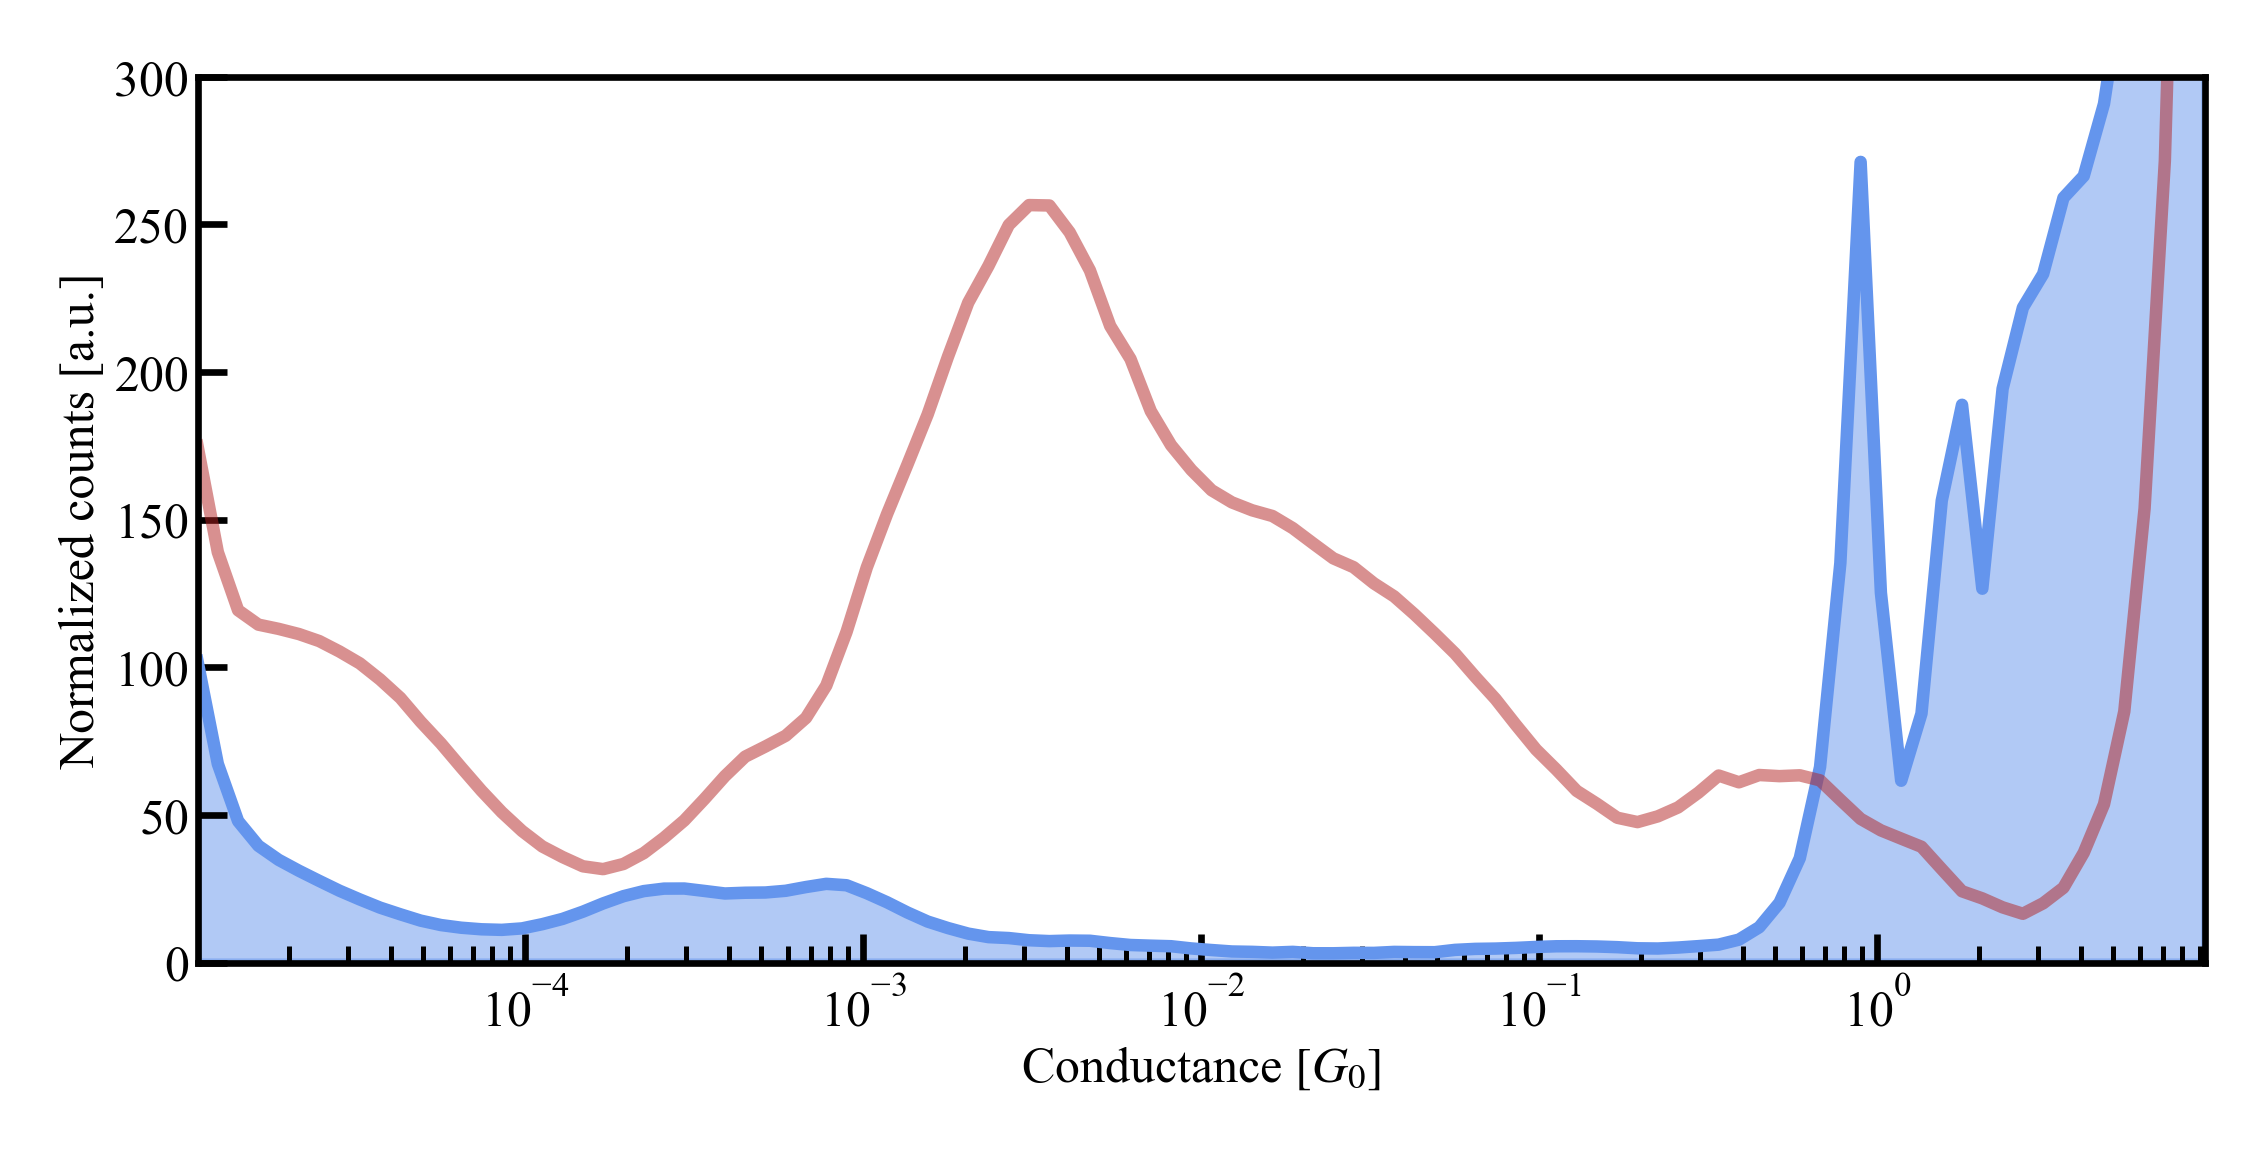

In [5]:
ax = hist.plot_hist_1d()
ax.set_ylim(0, 300)

In [6]:
hist = Histogram(folder=home_folder,
                 traces=after_evap[:8000],  #8000
                 conductance_range=(1e-5, 10),  # 4.229e-5
                 conductance_bins_num=100,
                 conductance_bins_mode='total')

In [7]:
hist.calc_stats(align_at=0.5,
                range_pull=(-1, 1),
                range_push=(-0.5, 1.5))

  0%|          | 0/8000 [00:00<?, ?it/s]

Pull 2D histogram created from 8000 traces
Push 2D histogram created from 8000 traces


(0.0, 300.0)

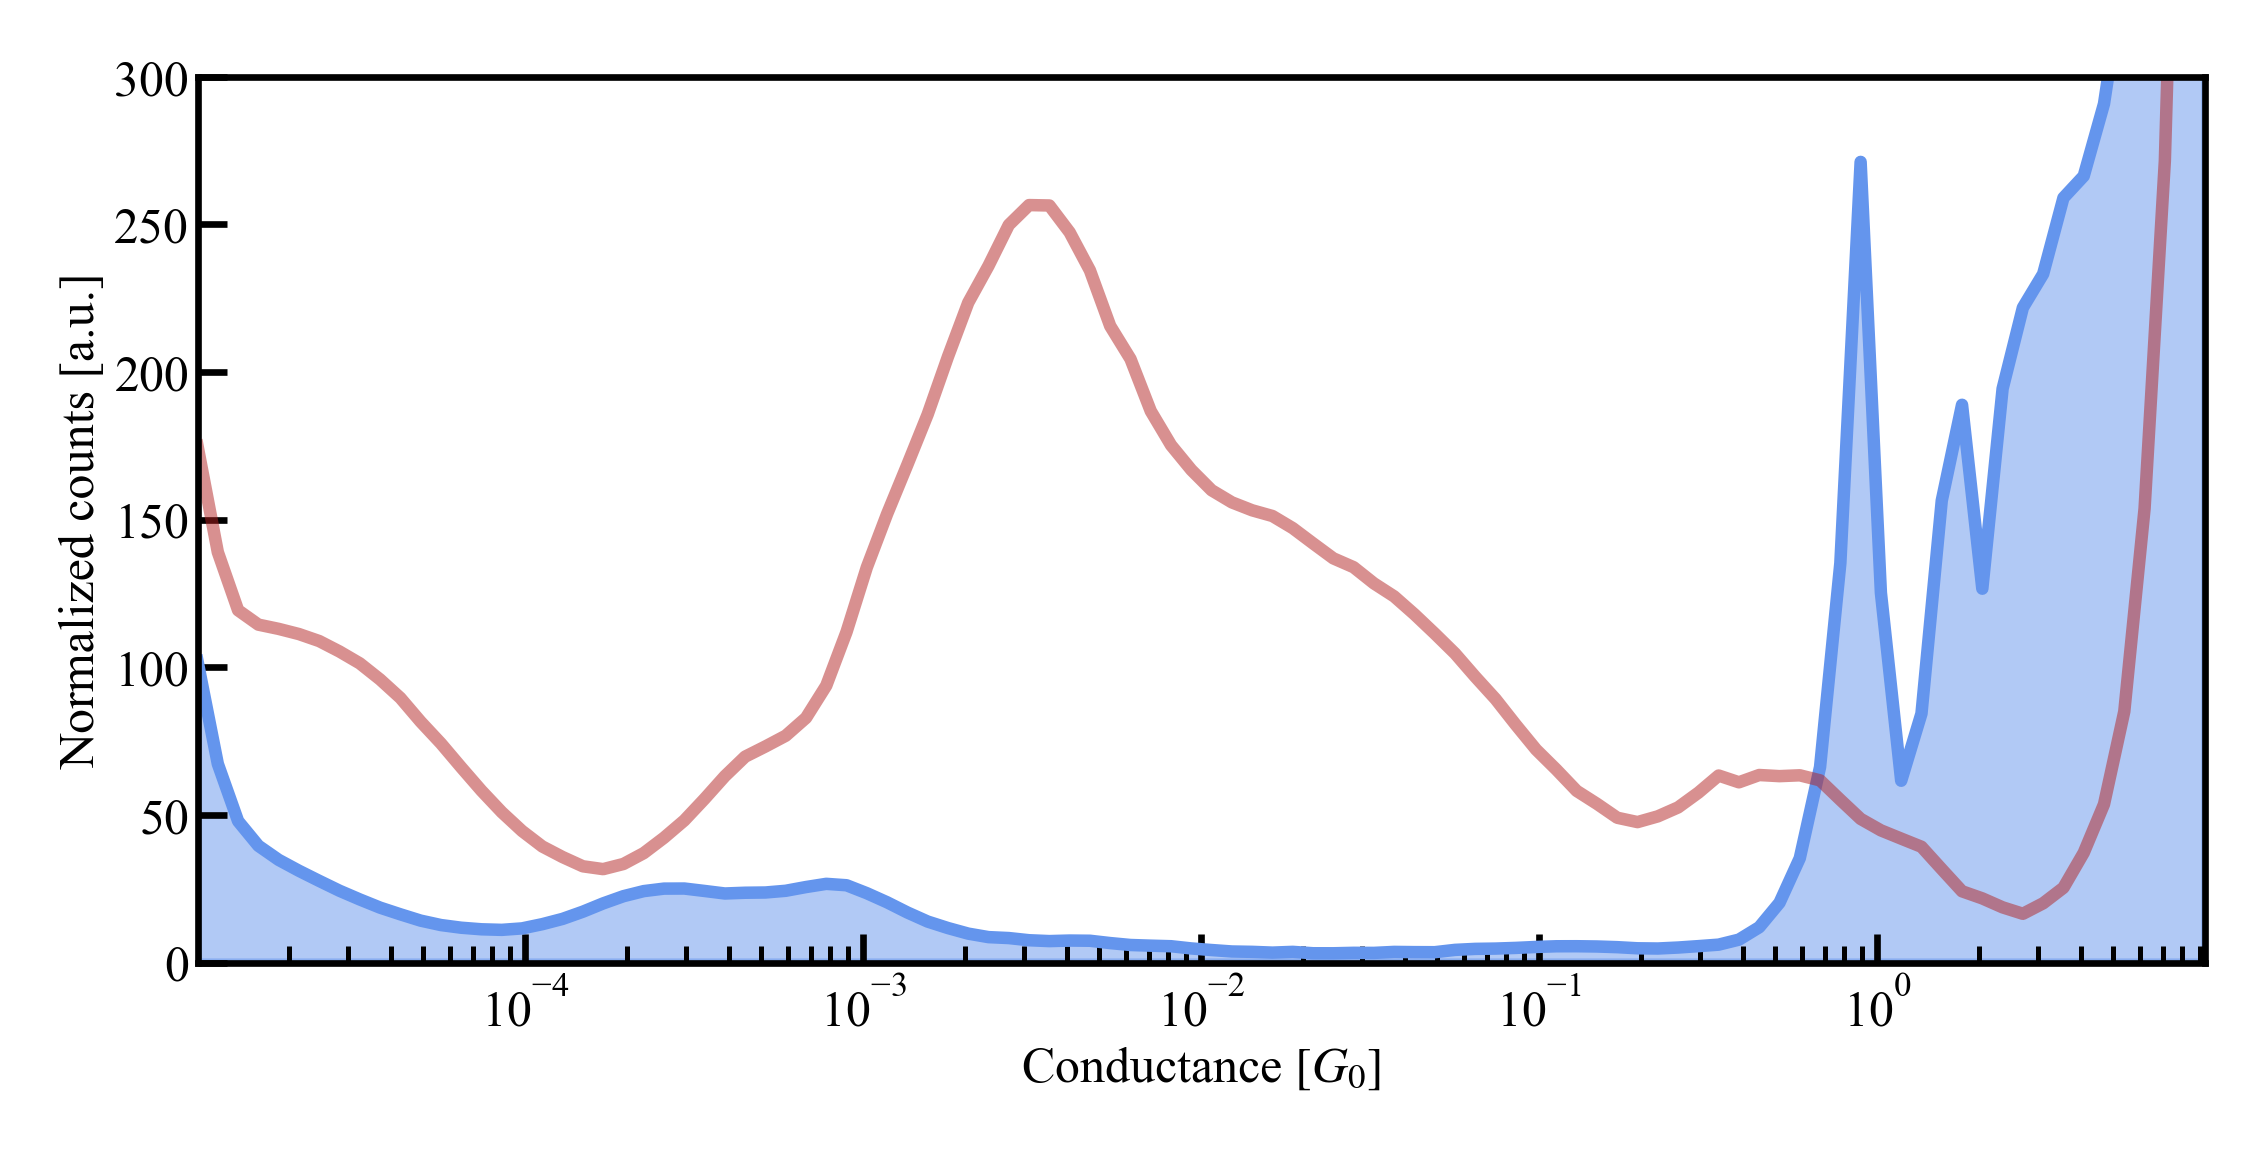

In [8]:
ax = hist.plot_hist_1d()
ax.set_ylim(0, 300)

In [9]:
hist.calc_corr_hist_2d()

  0%|          | 0/8000 [00:00<?, ?it/s]

In [10]:
import os
os.mkdir(home_folder.joinpath('teszt'))

In [11]:
with h5py.File(home_folder.joinpath('results/teszt.h5'), 'w') as f:
    my_gr = f.create_group(name='teszt_group')
    my_gr2 = f.create_group(name='fdfjk')
    my_gr.create_dataset(name='teszt_dset', data=np.ones(10))

In [12]:
with h5py.File(home_folder.joinpath('results/teszt.h5'), 'r') as f:
    for i in f.keys():
        print(i)
        
    print(tuple(f.keys()))
    print(f['teszt_group']['teszt_dset'][:])

fdfjk
teszt_group
('fdfjk', 'teszt_group')
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
Path(f'D:/BJ_Data/{date}/results/histogram.h5').parents[1]

WindowsPath('D:/BJ_Data/22_03_23')

In [14]:
hist.save_histogram(Path(f'D:/BJ_Data/{date}/histogram.h5'))

Histogram saved to D:\BJ_Data\22_03_23\histogram.h5.


In [15]:
tuple(i for i in range(6))

(0, 1, 2, 3, 4, 5)

### Comparison with Nóri's 1D histogram

In [16]:
nori_hist_1d = np.loadtxt('D:/Greta/POConductanceHist1D_all_long.txt', skiprows=1)
nori_hist_bins = 10**np.arange(start=-5.82391, step=0.0689284, stop=-5.82391+100*0.0689284)

OSError: D:/Greta/POConductanceHist1D_all_long.txt not found.

In [ ]:
pc_nori=PCA(hist=Histogram(folder=home_folder,
                 traces=after_evap[:2000],  #8000
                 conductance_range=(1e-5, 10),  # 4.229e-5
                 conductance_bins_num=100,
                 conductance_bins_mode='total'))
pc_nori.load_principal_components(source_file='C:/Users/András/Downloads/STM_PCs.txt', source_type='igor')
pc_nori.hist.hist_1d_bins = nori_hist_bins
pc_nori.hist.hist_1d_pull = nori_hist_1d

In [ ]:
ax = hist.plot_hist_1d()
ax.set_ylim(0, 200)
ax.plot(nori_hist_bins, 3*nori_hist_1d, lw=1, c='orange')

### Temporal histograms

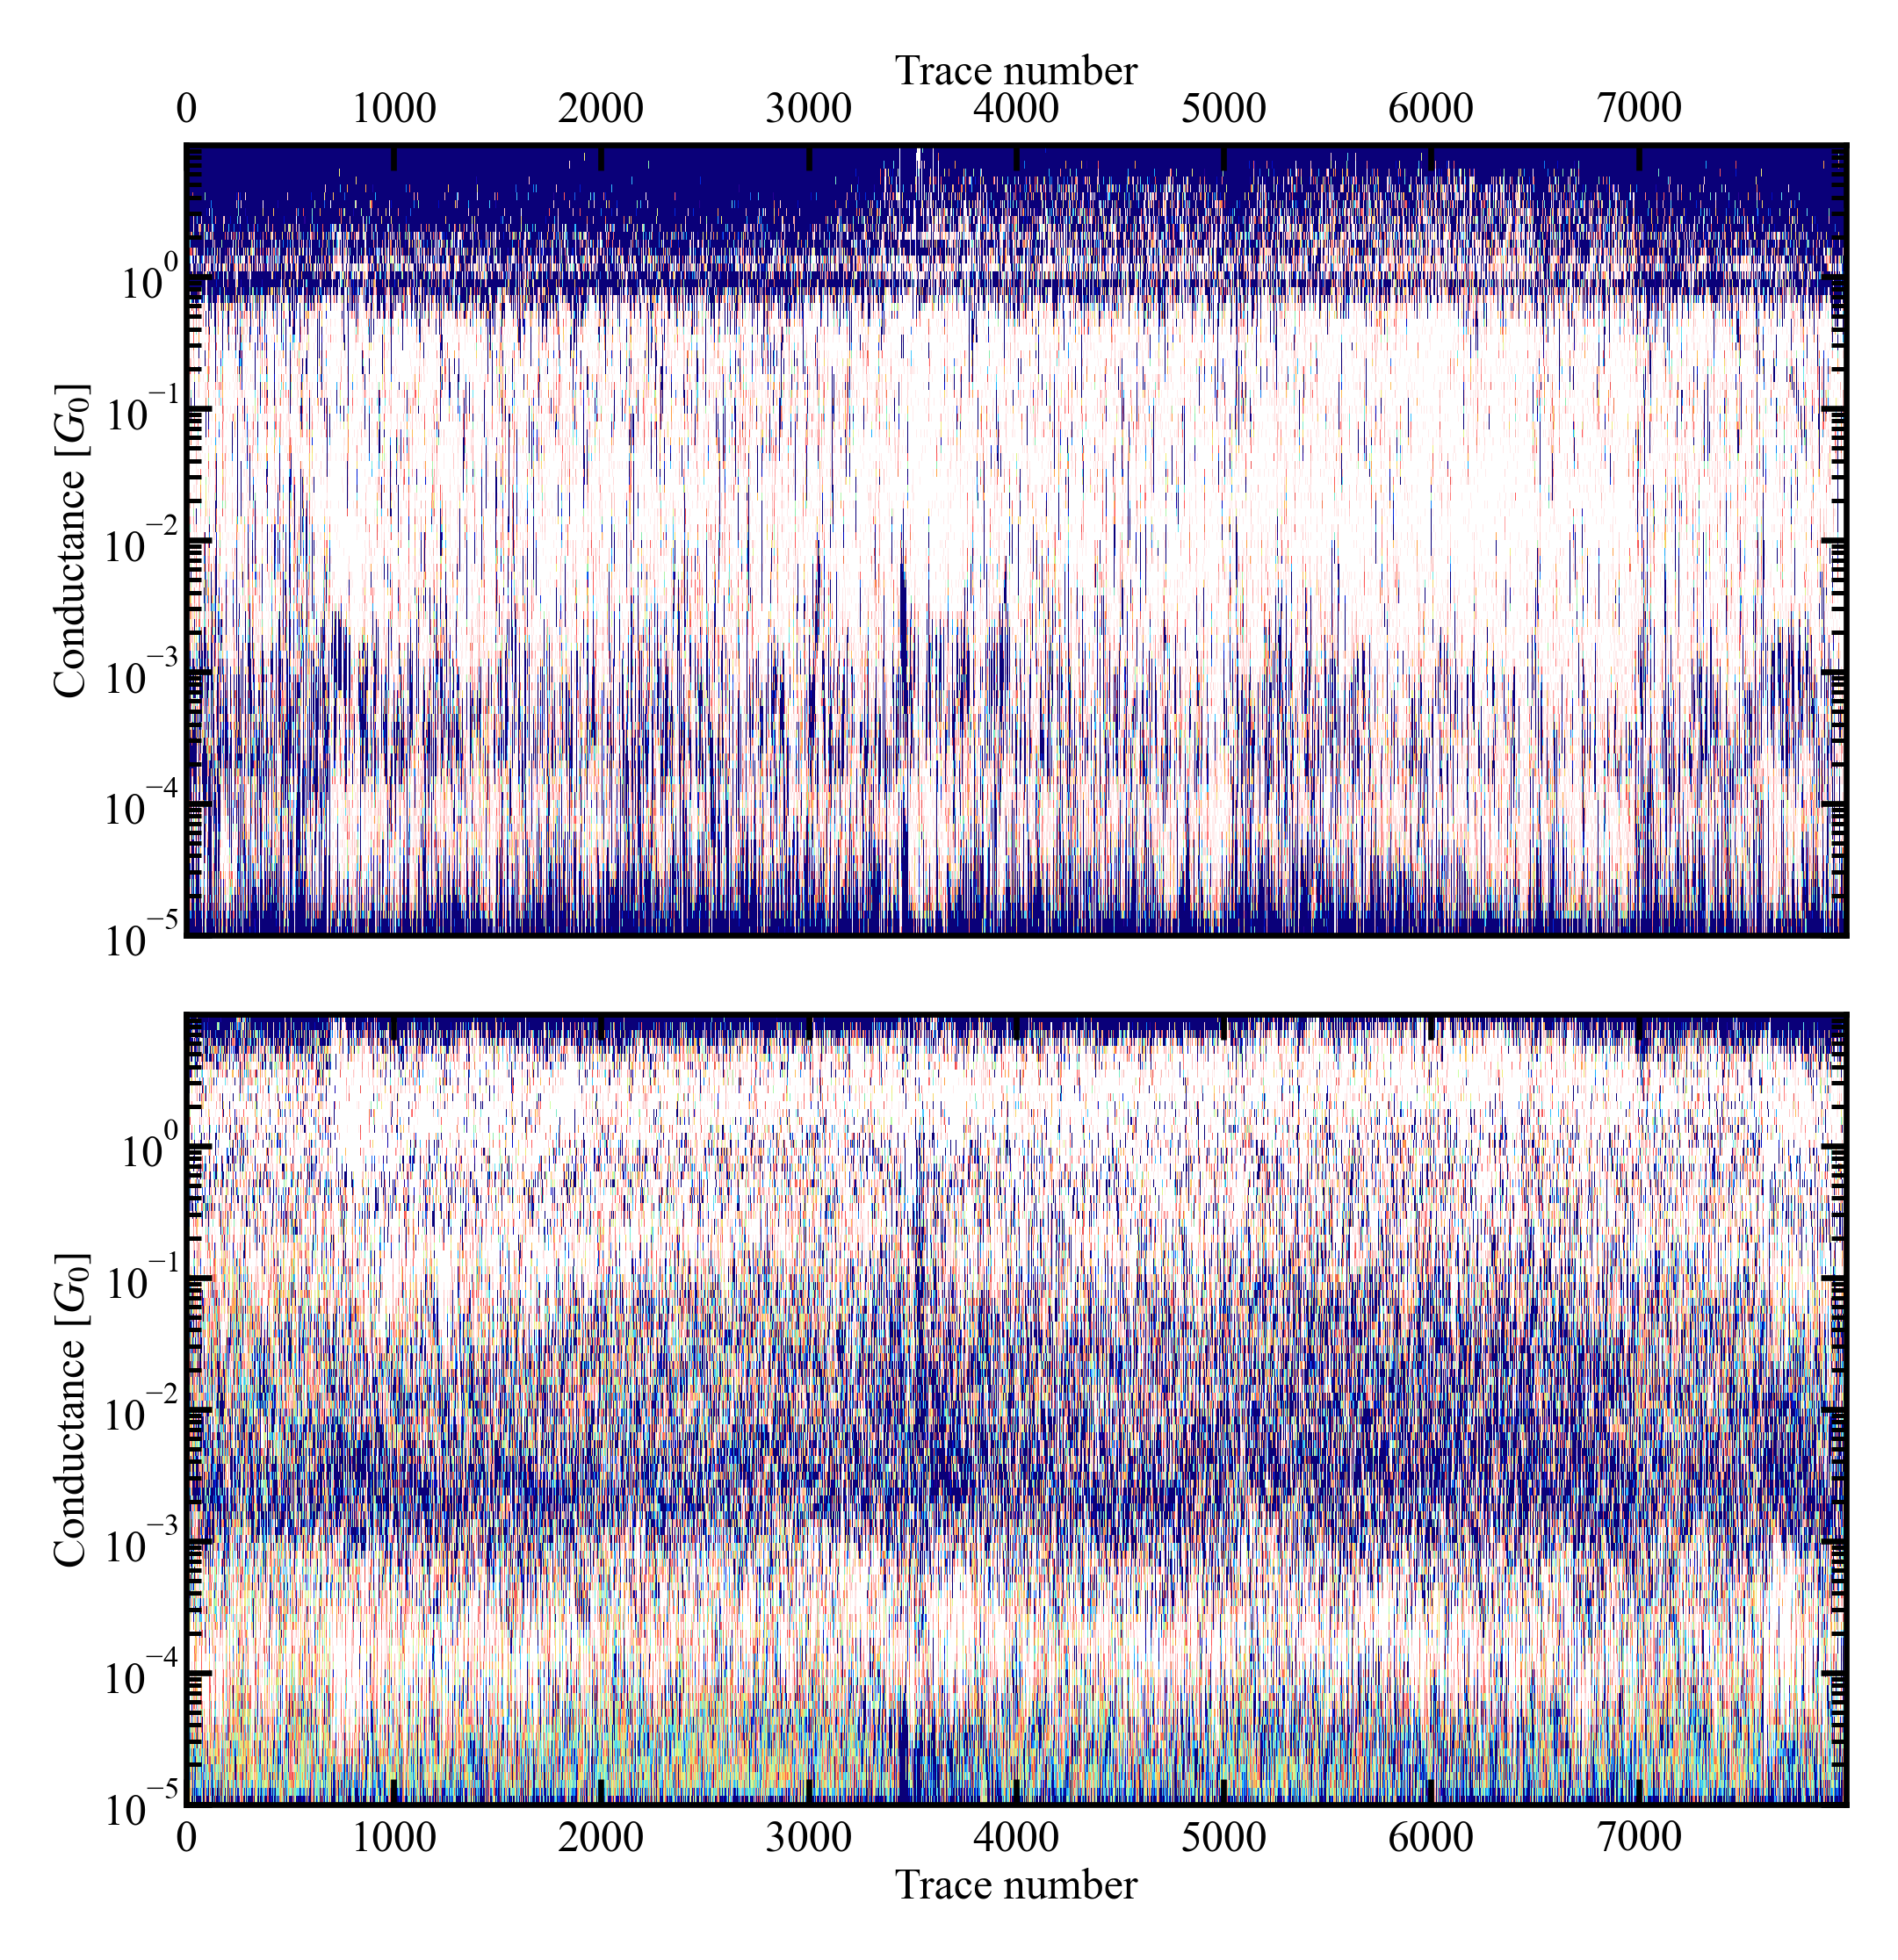

In [17]:
ax_temp_pull, ax_temp_push = hist.plot_temporal_hist(vmax_pull=30, vmax_push=200)

(5e-05, 0.03)

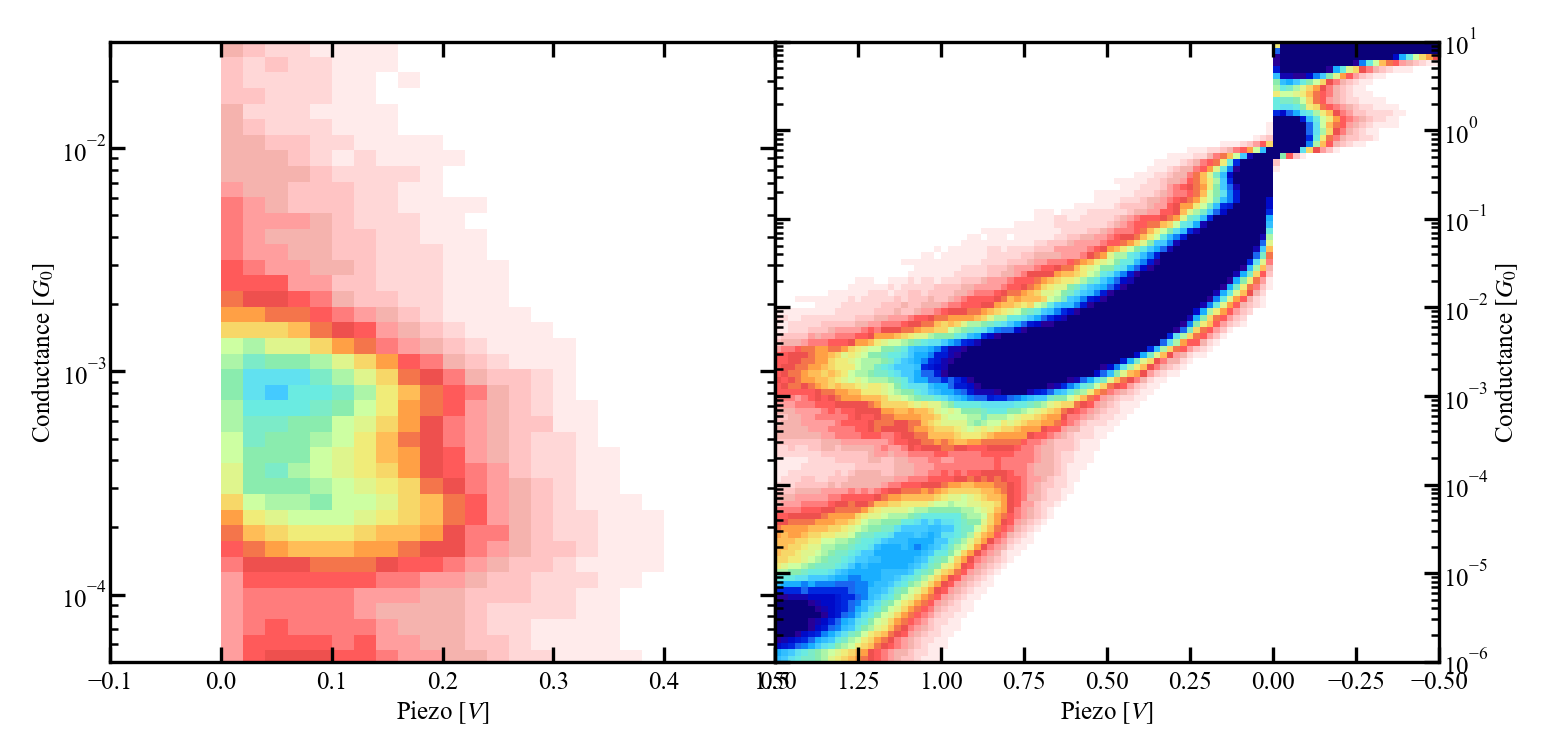

In [73]:
ax = hist.plot_hist_2d_both(dpi=300, vmax=40000)
ax[0].set_xlim(-0.1, 0.5)
ax[0].set_ylim(5e-5, 3e-2)

In [19]:
min(hist.hist_2d_xmesh_push.flatten())

-0.5

### Some example traces randomly selected from the 8000 traces

In [ ]:
example = 0

In [ ]:
example+=1
ax = hist.plot_example_traces(traces=10, shift=0.25, lw=0.5)
ax.set_xlim(-0.2, 3.2)
plt.savefig(f'example_traces_{example}.png', bbox_inches='tight')

In [ ]:
trace_num = 38237
trace_pair = TracePair(trace_num, load_from=home_folder)
trace_pair.plot_trace_pair(dpi=300)

In [ ]:
trace_pair.rate

### Correlation

In [20]:
hist.calc_corr_hist_2d()

  0%|          | 0/8000 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='Conductance $[G_{0}]$', ylabel='Conductance $[G_{0}]$'>,
 <AxesSubplot:>)

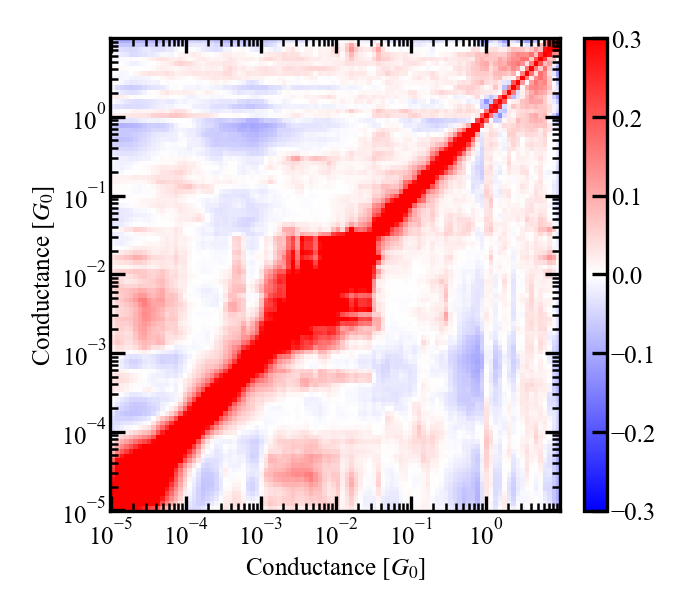

In [21]:
hist.plot_corr(mode='pull', dpi=300, vmin=-0.3, vmax=0.3)

## Principal Component Analysis

In [22]:
pc = PCA(hist=hist, num_of_pcs=5)
pc.calc_principal_components(direction='pull')

NameError: name 'nori_hist_bins' is not defined

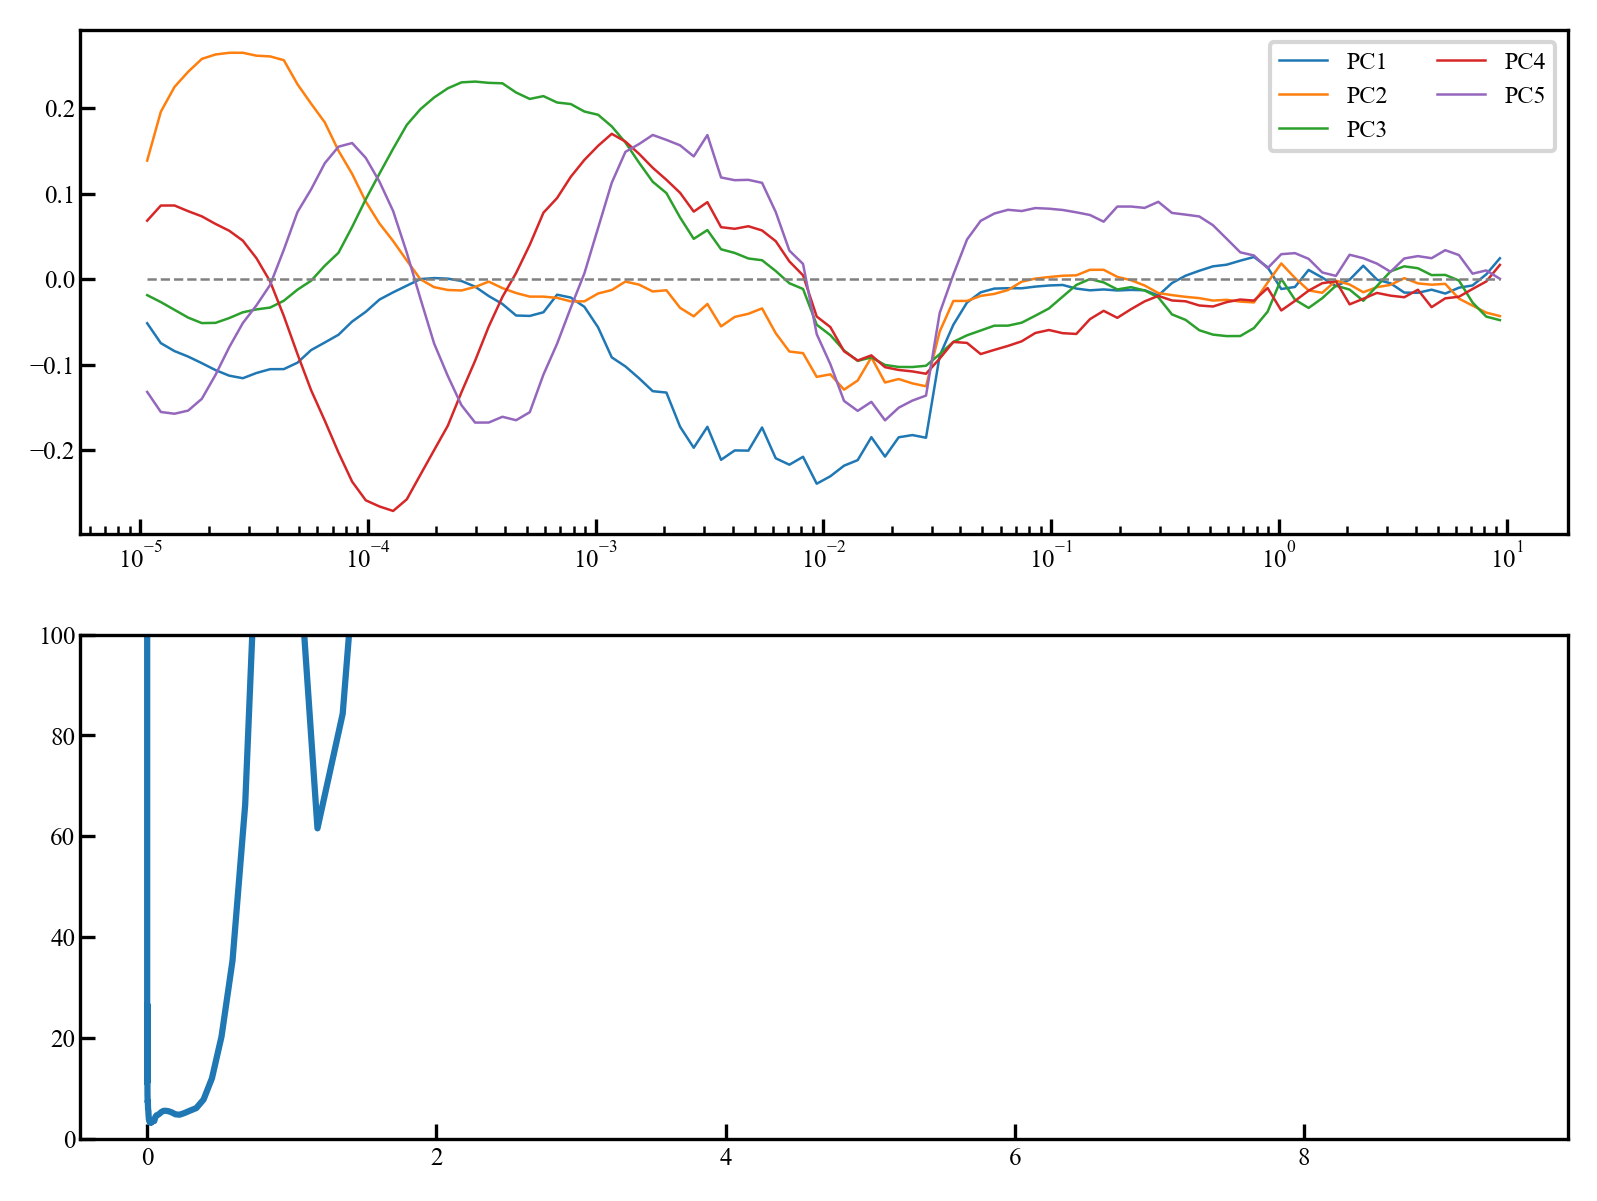

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300)
ax1 = pc.plot_pcs(ax=ax1)
# par = ax.twinx()
ax2.plot(hist.hist_1d_bins, hist.hist_1d_pull, label='22_03_23')
ax2.set_ylim(0, 100)

ax2.plot(nori_hist_bins, nori_hist_1d*3, label='Nóri')
ax2.legend()
ax2.set_xscale('log')
ax1.set_xlim(1e-5, 10)
ax2.set_xlim(1e-5, 10)

### Compare PCs to Nóri's results

In [ ]:
compare_principal_components(pcs=(pc, pc_nori), labels=('22_03_23', 'Nóri'), lw=1)

### Projection

In [24]:
pc.project_to_pcs()

Calculating the projections to PCs.:   0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
pc.calc_pc_hist_all(num_of_bins=100, hist_min=None, hist_max = None)

  0%|          | 0/5 [00:00<?, ?it/s]

### Testing different selections

#### 10 %

In [ ]:
pc.select_percentage(percentage=10, calc_histograms=True)

In [ ]:
pc.calc_group_histograms()

In [ ]:
ax = pc.plot_group_histograms_1d(ylims=(0, 150), group1_color='b', group2_color='r')

In [ ]:
ax = pc.plot_group_histograms_2d()

In [ ]:
pc10_hist_group1 = pc.hist_group1.copy()
pc10_hist_group2 = pc.hist_group2.copy()

#### 20 %

In [26]:
pc.select_percentage(percentage=20, calc_histograms=True)

In [27]:
pc.calc_group_histograms()
pc20_hist_group1 = pc.hist_group1.copy()
pc20_hist_group2 = pc.hist_group2.copy()

Calculating 1D and 2D histograms of PC1 group1.


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

2D histogram pull direction created from 1600 traces
2D histogram push direction created from 1600 traces
Calculating 1D and 2D histograms of PC1 group2.


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

2D histogram pull direction created from 1600 traces
2D histogram push direction created from 1600 traces
Calculating 1D and 2D histograms of PC2 group1.


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

2D histogram pull direction created from 1600 traces
2D histogram push direction created from 1600 traces
Calculating 1D and 2D histograms of PC2 group2.


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

2D histogram pull direction created from 1600 traces
2D histogram push direction created from 1600 traces
Calculating 1D and 2D histograms of PC3 group1.


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

2D histogram pull direction created from 1600 traces
2D histogram push direction created from 1600 traces
Calculating 1D and 2D histograms of PC3 group2.


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

2D histogram pull direction created from 1600 traces
2D histogram push direction created from 1600 traces
Calculating 1D and 2D histograms of PC4 group1.


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

2D histogram pull direction created from 1600 traces
2D histogram push direction created from 1600 traces
Calculating 1D and 2D histograms of PC4 group2.


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

2D histogram pull direction created from 1600 traces
2D histogram push direction created from 1600 traces
Calculating 1D and 2D histograms of PC5 group1.


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

2D histogram pull direction created from 1600 traces
2D histogram push direction created from 1600 traces
Calculating 1D and 2D histograms of PC5 group2.


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

2D histogram pull direction created from 1600 traces
2D histogram push direction created from 1600 traces


#### 30 %

In [ ]:
pc.select_percentage(percentage=30, calc_histograms=True)

In [ ]:
pc.calc_group_histograms()
pc30_hist_group1 = pc.hist_group1.copy()
pc30_hist_group2 = pc.hist_group2.copy()

#### 40 %

In [ ]:
pc.select_percentage(percentage=40, calc_histograms=True)

In [ ]:
pc.calc_group_histograms()
pc40_hist_group1 = pc.hist_group1.copy()
pc40_hist_group2 = pc.hist_group2.copy()

#### 50 %

In [ ]:
pc.select_percentage(percentage=50, calc_histograms=True)

In [ ]:
pc.calc_group_histograms()
pc50_hist_group1 = pc.hist_group1.copy()
pc50_hist_group2 = pc.hist_group2.copy()

#### 60 %

In [ ]:
pc.select_percentage(percentage=60, calc_histograms=True)

In [ ]:
pc.calc_group_histograms()
pc60_hist_group1 = pc.hist_group1.copy()
pc60_hist_group2 = pc.hist_group2.copy()

#### Comparison

In [ ]:
fig, axs = plt.subplots(5, dpi=300, figsize=(10, 4*5))

for i, ax in enumerate(axs):
    ax.set_xscale('log')
    ax.set_ylim(0, 200)
    ax.set_xlim(1e-5, 10)

    ax.plot(hist.hist_1d_bins, hist.hist_1d_pull, label='total', c='cornflowerblue')
    ax.fill_between(hist.hist_1d_bins, np.zeros_like(hist.hist_1d_pull), hist.hist_1d_pull,
                       alpha=0.5, color='cornflowerblue')

    ax.plot(pc10_hist_group1[pc.pc_keys[i]].hist_1d_bins,
               pc10_hist_group1[pc.pc_keys[i]].hist_1d_pull, label='group1 10%', c=utils.blues[0])
    
    ax.plot(pc10_hist_group2[pc.pc_keys[i]].hist_1d_bins,
               pc10_hist_group2[pc.pc_keys[i]].hist_1d_pull, label='group2 10%', c=utils.reds[0])
    
    ax.plot(pc20_hist_group1[pc.pc_keys[i]].hist_1d_bins,
               pc20_hist_group1[pc.pc_keys[i]].hist_1d_pull, label='group1 20%', c=utils.blues[1])
    
    ax.plot(pc20_hist_group2[pc.pc_keys[i]].hist_1d_bins,
               pc20_hist_group2[pc.pc_keys[i]].hist_1d_pull, label='group2 20%', c=utils.reds[1])
    
    ax.plot(pc30_hist_group1[pc.pc_keys[i]].hist_1d_bins,
               pc30_hist_group1[pc.pc_keys[i]].hist_1d_pull, label='group1 30%', c=utils.blues[2])
    
    ax.plot(pc30_hist_group2[pc.pc_keys[i]].hist_1d_bins,
               pc30_hist_group2[pc.pc_keys[i]].hist_1d_pull, label='group2 30%', c=utils.reds[2])
    
    ax.plot(pc40_hist_group1[pc.pc_keys[i]].hist_1d_bins,
               pc40_hist_group1[pc.pc_keys[i]].hist_1d_pull, label='group1 40%', c=utils.blues[i])
    
    ax.plot(pc40_hist_group2[pc.pc_keys[i]].hist_1d_bins,
               pc40_hist_group2[pc.pc_keys[i]].hist_1d_pull, label='group2 40%', c=utils.reds[i])
    
#     ax.plot(pc50_hist_group1[pc.pc_keys[i]].hist_1d_bins,
#                pc50_hist_group1[pc.pc_keys[i]].hist_1d_pull, label='group1 50%', c=utils.blues[i])
    
#     ax.plot(pc50_hist_group2[pc.pc_keys[i]].hist_1d_bins,
#                pc50_hist_group2[pc.pc_keys[i]].hist_1d_pull, label='group2 50%', c=utils.reds[i])
    
#     ax.plot(pc60_hist_group1[pc.pc_keys[i]].hist_1d_bins,
#                pc60_hist_group1[pc.pc_keys[i]].hist_1d_pull, label='group1 60%', c=utils.blues[i])
    
#     ax.plot(pc60_hist_group2[pc.pc_keys[i]].hist_1d_bins,
#                pc60_hist_group2[pc.pc_keys[i]].hist_1d_pull, label='group2 60%', c=utils.reds[i])
    
    ax.set_title(pc.pc_keys[i], fontsize='xx-small', pad=3)
    ax.legend(fontsize='xx-small')

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=4, dpi=300, figsize=(4*5, 5*5))

for i in range(len(pc.pc_keys)):
    for j, pcx_hist_group1 in enumerate((pc10_hist_group1, pc20_hist_group1, pc30_hist_group1, pc40_hist_group1)):  #, pc40_hist_group1, pc50_hist_group1, pc60_hist_group1)
        axs[i, j] = pcx_hist_group1[pc.pc_keys[i]].plot_hist_2d_one(direction='pull', ax=axs[i, j], vmax=5_000*(j+1))
        axs[i, j].set_xlim(-0.5, 0.5)

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=4, dpi=300, figsize=(4*5, 5*5))

for i in range(len(pc.pc_keys)):
    for j, pcx_hist_group1 in enumerate((pc10_hist_group1, pc20_hist_group1, pc30_hist_group1, pc40_hist_group1)):  #, pc40_hist_group1, pc50_hist_group1, pc60_hist_group1)
        axs[i, j] = pcx_hist_group1[pc.pc_keys[i]].plot_hist_2d_one(direction='push', ax=axs[i, j], vmax=5_000*(j+1))
#         axs[i, j].set_xlim(-0.5, 0.5)

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=4, dpi=300, figsize=(4*5, 5*5))

for i in range(len(pc.pc_keys)):
    for j, pcx_hist_group2 in enumerate((pc10_hist_group2, pc20_hist_group2, pc30_hist_group2, pc40_hist_group2)):  #, pc40_hist_group1, pc50_hist_group1, pc60_hist_group1)
        axs[i, j] = pcx_hist_group2[pc.pc_keys[i]].plot_hist_2d_one(direction='pull', ax=axs[i, j], vmax=5_000*(j+1))
        axs[i, j].set_xlim(-0.5, 0.5)

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=4, dpi=300, figsize=(4*5, 5*5))

for i in range(len(pc.pc_keys)):
    for j, pcx_hist_group2 in enumerate((pc10_hist_group2, pc20_hist_group2, pc30_hist_group2, pc40_hist_group2)):  #, pc40_hist_group1, pc50_hist_group1, pc60_hist_group1)
        axs[i, j] = pcx_hist_group2[pc.pc_keys[i]].plot_hist_2d_one(direction='push', ax=axs[i, j], vmax=5_000*(j+1))
#         axs[i, j].set_xlim(-0.5, 0.5)

In [ ]:
pc.traces_group1['PC4'].shape

In [28]:
G_high = (6e-4, 2e-3)
G_low = (5e-5, 2e-4)

In [29]:
rand_selection_gr1 = np.random.choice(pc.traces_group1['PC4'], 10)

In [ ]:
# example+=1
ax = hist.plot_example_traces(traces=tuple(rand_selection_gr1), shift=0.25, lw=0.5)
ax.set_xlim(-0.2, 3.2)
for i in range(2):
    ax.axhline(G_low[i], ls='--', lw=0.5, c='b')
    ax.axhline(G_high[i], ls='--', lw=0.5, c='r')
    
ax.axvline(0, ls='--', c='k', lw=0.5)
ax.axvline(200/trace_pair.sample_rate*trace_pair.rate, ls='--', c='grey', lw=0.5)
for i in range(1, 4):
    ax.axvline((200+i*256)/trace_pair.sample_rate*trace_pair.rate, ls='--', c='lightgrey', lw=0.5)
    
ax.axvline(0+0.25, ls='--', c='k', lw=0.5)
ax.axvline(200/trace_pair.sample_rate*trace_pair.rate+0.25, ls='--', c='grey', lw=0.5)
for i in range(1, 4):
    ax.axvline((200+i*256)/trace_pair.sample_rate*trace_pair.rate+0.25, ls='--', c='lightgrey', lw=0.5)
    
ax.set_title('PC4 group1 example traces', fontsize='xx-small', pad=3)
plt.savefig(home_folder.joinpath(f'example_traces_PC4_group1.png'), bbox_inches='tight', facecolor='white')

In [ ]:
rand_selection_gr2 = np.random.choice(pc.traces_group2['PC4'], 10)

In [ ]:
# example+=1
ax = hist.plot_example_traces(traces=tuple(rand_selection_gr2), shift=0.25, lw=0.5)
ax.set_xlim(-0.2, 3.2)
for i in range(2):
    ax.axhline(G_low[i], ls='--', lw=0.5, c='b')
    ax.axhline(G_high[i], ls='--', lw=0.5, c='r')
    
ax.axvline(0, ls='--', c='k', lw=0.5)
ax.axvline(200/trace_pair.sample_rate*trace_pair.rate, ls='--', c='grey', lw=0.5)
for i in range(1, 4):
    ax.axvline((200+i*256)/trace_pair.sample_rate*trace_pair.rate, ls='--', c='lightgrey', lw=0.5)
    
ax.axvline(0+0.25, ls='--', c='k', lw=0.5)
ax.axvline(200/trace_pair.sample_rate*trace_pair.rate+0.25, ls='--', c='grey', lw=0.5)
for i in range(1, 4):
    ax.axvline((200+i*256)/trace_pair.sample_rate*trace_pair.rate+0.25, ls='--', c='lightgrey', lw=0.5)
    
ax.set_title('PC4 group2 example traces', fontsize='xx-small', pad=3)
plt.savefig(home_folder.joinpath(f'example_traces_PC4_group2.png'), bbox_inches='tight', facecolor='white')

In [ ]:
updated_gr1, cond_pull_gr1, piez_pull_gr1 = collect_traces(rand_selection_gr1, align_val=2e-2)

In [ ]:
xmesh_gr1, ymesh_gr1, hist_2d_gr1 = calc_2d_hist_for_collected(updated_gr1, cond_pull_gr1, piez_pull_gr1)

In [ ]:
areas_pull_gr1, cond_avg_in_win_pull_gr1, psd_all_gr1, fft_freqs_gr1 = noise_analysis(updated_gr1, cond_pull_gr1, piez_pull_gr1, win_size=256, step_size=None, skip_points=50, end_point=3000)

In [ ]:
updated_gr2, cond_pull_gr2, piez_pull_gr2 = collect_traces(rand_selection_gr2, align_val=2e-2)

In [ ]:
xmesh_gr2, ymesh_gr2, hist_2d_gr2 = calc_2d_hist_for_collected(updated_gr2, cond_pull_gr2, piez_pull_gr2)

In [ ]:
areas_pull_gr2, cond_avg_in_win_pull_gr2, psd_all_gr2, fft_freqs_gr2 = noise_analysis(updated_gr2, cond_pull_gr2, piez_pull_gr2, win_size=256, step_size=None, skip_points=50, end_point=3000)

In [ ]:
fig = plt.figure(figsize=utils.cm2inch(20, 5), dpi=600)  # figsize: (width, height) in inches
gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=(1, 1, 1, 1),
                       figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0, hspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

ax1.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))
ax2.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))
ax3.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))
ax4.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))

ax3.xaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax3.yaxis.set_ticks_position('both')
ax4.yaxis.set_ticks_position('both')

ax1.xaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax1.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

ax1.set_title('Noise power group1', fontsize='xx-small', pad=3)
ax2.set_title('Noise power group2', fontsize='xx-small', pad=3)
ax3.set_title('dG/G group1', fontsize='xx-small', pad=3)
ax4.set_title('dG/G group2', fontsize='xx-small', pad=3)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax4.set_xscale('log')
ax4.set_yscale('log')

for trace in range(len(updated_gr1)):
    ax1.scatter(cond_avg_in_win_pull_gr1[trace, :], areas_pull_gr1[trace, :], s=1)
    
for trace in range(len(updated_gr2)):
    ax2.scatter(cond_avg_in_win_pull_gr2[trace, :], areas_pull_gr2[trace, :], s=1)
    
for trace in range(len(updated_gr1)):
    ax3.scatter(cond_avg_in_win_pull_gr1[trace, :],
                np.sqrt(areas_pull_gr1[trace, :])/cond_avg_in_win_pull_gr1[trace, :], s=1)
    
for trace in range(len(updated_gr2)):
    ax4.scatter(cond_avg_in_win_pull_gr2[trace, :],
                np.sqrt(areas_pull_gr2[trace, :])/cond_avg_in_win_pull_gr2[trace, :], s=1)

ax1.set_ylim(1e-12, 1e-5)
ax2.set_ylim(ax1.get_ylim())
ax3.set_ylim(1e-3, 10)
ax4.set_ylim(ax3.get_ylim())

ax1.set_xlim(1e-5, 0.1)
ax2.set_xlim(ax1.get_xlim())
ax3.set_xlim(ax1.get_xlim())
ax4.set_xlim(ax1.get_xlim())

ax1.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax1.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax1.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax2.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax2.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax2.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax3.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax3.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax3.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax4.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax4.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax4.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))

# xbins1=np.logspace(np.log10(G_low[0]), np.log10(G_low[1]), num=20)
# xbins2=np.logspace(np.log10(G_high[0]), np.log10(G_high[1]), num=20)
# shift1=-6
# shift2=-2.5
# ax3.plot(xbins1, 10 ** (1 * np.log10(xbins1) + shift1), c='b', ls='-', lw=1)
# ax4.plot(xbins2, 10 ** (2 * np.log10(xbins2) + shift2), c='r', ls='-', lw=1)
# shift1=-3
# shift2=-1.2

ax3.axvline(G_low[0], ls='--', c='b', lw=1)
ax3.axvline(G_low[1], ls='--', c='b', lw=1)

ax1.axvline(G_low[0], ls='--', c='b', lw=1)
ax1.axvline(G_low[1], ls='--', c='b', lw=1)
ax1.axvline(G_high[0], ls='--', c='r', lw=1)
ax1.axvline(G_high[1], ls='--', c='r', lw=1)

ax2.axvline(G_low[0], ls='--', c='b', lw=1)
ax2.axvline(G_low[1], ls='--', c='b', lw=1)
ax2.axvline(G_high[0], ls='--', c='r', lw=1)
ax2.axvline(G_high[1], ls='--', c='r', lw=1)

ax4.axvline(G_high[0], ls='--', c='r', lw=1)
ax4.axvline(G_high[1], ls='--', c='r', lw=1)

# ax2.plot(cond_mean_both[cond_mean_both > 0], noise_mean_both[cond_mean_both > 0])
# ax2.plot(10**xdata_4_1, 10**(xdata_4_1*popt_both_1[0]+popt_both_1[1]), c='k', ls='--', lw=1)
# ax2.plot(10**xdata_4_2, 10**(xdata_4_2*popt_both_2[0]+popt_both_2[1]), c='k', ls='--', lw=1)

# ax3.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0])
# ax4.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')

# ax4.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0])
# ax3.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')

# ax1.plot(cond_mean_all[cond_mean_all > 0], noise_mean_all[cond_mean_all > 0])

# ax3.plot(10**xdata_4_1, 10**(xdata_4_1*popt_4_1[0]+popt_4_1[1]), c='k', ls='--', lw=1)
# ax4.plot(10**xdata_4_2, 10**(xdata_4_2*popt_4_2[0]+popt_4_2[1]), c='k', ls='--', lw=1)

# ax1.plot(10**xdata_4_1, 10**(xdata_4_1*popt_all_1[0]+popt_all_1[1]), c='k', ls='--', lw=1)
# ax1.plot(10**xdata_4_2, 10**(xdata_4_2*popt_all_2[0]+popt_all_2[1]), c='k', ls='--', lw=1)

# ax2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')
# plt.savefig(home_folder.joinpath(f'noise_for example_traces_gr1-2_factor5.png'), bbox_inches='tight', facecolor='white')

In [ ]:
rand_selection_gr1 == updated_gr1

In [ ]:
# pc.traces_group2['PC4']

def plot_example_traces_w_noise(rand_selection_group,
                                cond_avg_in_win_pull_group,
                                areas_pull_group,
                                group=1,
                                save_fig = None):
    fig = plt.figure(figsize=utils.cm2inch(10, 10), dpi=300)  # figsize: (width, height) in inches
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=(1, 1),
                           figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0, hspace=0.1)
    gs_noise = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, width_ratios=(1, 1),
                                                subplot_spec=gs[1],
                                                wspace=0.1, hspace=0)

    ax_traces = fig.add_subplot(gs[0])
    ax_noise_pow = fig.add_subplot(gs_noise[0])
    ax_cond_noise = fig.add_subplot(gs_noise[1])

    ax_traces.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))
    ax_noise_pow.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))
    ax_cond_noise.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))

    ax_traces.xaxis.set_ticks_position('both')
    ax_traces.yaxis.set_ticks_position('both')

    ax_noise_pow.xaxis.set_ticks_position('both')
    ax_noise_pow.yaxis.set_ticks_position('both')
    ax_cond_noise.xaxis.set_ticks_position('both')
    ax_cond_noise.yaxis.tick_right()
    ax_cond_noise.yaxis.set_label_position('right')
    ax_cond_noise.yaxis.set_ticks_position('both')

    ax_noise_pow.set_ylim(1e-12, 1e-5)
    ax_cond_noise.set_ylim(1e-3, 10)

    ax_noise_pow.set_xlim(1e-5, 0.1)
    ax_cond_noise.set_xlim(ax_noise_pow.get_xlim())

    ax_noise_pow.set_xscale('log')
    ax_noise_pow.set_yscale('log')
    ax_cond_noise.set_xscale('log')
    ax_cond_noise.set_yscale('log')

    ax_traces = hist.plot_example_traces(traces=tuple(rand_selection_group), shift=0.25, lw=0.5, ax=ax_traces)
    ax_traces.set_xlim(-0.2, 3.2)
    for i in range(2):
        ax_traces.axhline(G_low[i], ls='--', lw=0.5, c='b')
        ax_traces.axhline(G_high[i], ls='--', lw=0.5, c='r')

    ax_traces.axvline(0, ls='--', c='k', lw=0.5)
    ax_traces.axvline(200/trace_pair.sample_rate*trace_pair.rate, ls='--', c='grey', lw=0.5)
    for i in range(1, 4):
        ax_traces.axvline((200+i*256)/trace_pair.sample_rate*trace_pair.rate, ls='--', c='lightgrey', lw=0.5)

    ax_traces.axvline(0+0.25, ls='--', c='k', lw=0.5)
    ax_traces.axvline(200/trace_pair.sample_rate*trace_pair.rate+0.25, ls='--', c='grey', lw=0.5)
    for i in range(1, 4):
        ax_traces.axvline((200+i*256)/trace_pair.sample_rate*trace_pair.rate+0.25, ls='--', c='lightgrey', lw=0.5)

    ax_traces.set_title(f'PC4 group{group} example traces', fontsize='xx-small', pad=3)

    for trace in range(len(rand_selection_group)):
        ax_noise_pow.scatter(cond_avg_in_win_pull_group[trace, :], areas_pull_group[trace, :], s=1)

    for trace in range(len(rand_selection_group)):
        ax_cond_noise.scatter(cond_avg_in_win_pull_group[trace, :],
                              np.sqrt(areas_pull_group[trace, :])/cond_avg_in_win_pull_group[trace, :], s=1)

    ax_noise_pow.axvline(G_high[0], ls='--', c='r', lw=0.5)
    ax_noise_pow.axvline(G_high[1], ls='--', c='r', lw=0.5)
    ax_cond_noise.axvline(G_high[0], ls='--', c='r', lw=0.5)
    ax_cond_noise.axvline(G_high[1], ls='--', c='r', lw=0.5)

    ax_noise_pow.axvline(G_low[0], ls='--', c='b', lw=0.5)
    ax_noise_pow.axvline(G_low[1], ls='--', c='b', lw=0.5)
    ax_cond_noise.axvline(G_low[0], ls='--', c='b', lw=0.5)
    ax_cond_noise.axvline(G_low[1], ls='--', c='b', lw=0.5)
    
    if save_fig is not None:
        plt.savefig(home_folder.joinpath(f'results/images/{save_fig}.png'), bbox_inches='tight', facecolor='white')

In [ ]:
for i in range(1, 6):
    rand_selection_gr1 = np.random.choice(pc.traces_group1['PC4'], 10)
    updated_gr1, cond_pull_gr1, piez_pull_gr1 = collect_traces(rand_selection_gr1, align_val=2e-2)
    print(all(rand_selection_gr1 == updated_gr1))
    xmesh_gr1, ymesh_gr1, hist_2d_gr1 = calc_2d_hist_for_collected(updated_gr1, cond_pull_gr1, piez_pull_gr1)
    areas_pull_gr1, cond_avg_in_win_pull_gr1, psd_all_gr1, fft_freqs_gr1 = noise_analysis(updated_gr1, cond_pull_gr1, piez_pull_gr1, win_size=256, step_size=None, skip_points=50, end_point=3000)
    plot_example_traces_w_noise(rand_selection_group=rand_selection_gr1,
                                cond_avg_in_win_pull_group=cond_avg_in_win_pull_gr1,
                                areas_pull_group=areas_pull_gr1,
                                save_fig=f'example_traces_with_noise_PC4_group1_{i}')

In [ ]:
for i in range(1, 6):
    rand_selection_gr2 = np.random.choice(pc.traces_group2['PC4'], 10)
    updated_gr2, cond_pull_gr2, piez_pull_gr2 = collect_traces(rand_selection_gr2, align_val=2e-2)
    print(all(rand_selection_gr2 == updated_gr2))
    xmesh_gr2, ymesh_gr2, hist_2d_gr2 = calc_2d_hist_for_collected(updated_gr2, cond_pull_gr2, piez_pull_gr2)
    areas_pull_gr2, cond_avg_in_win_pull_gr2, psd_all_gr2, fft_freqs_gr2 = noise_analysis(updated_gr2, cond_pull_gr2, piez_pull_gr2, win_size=256, step_size=None, skip_points=50, end_point=3000)
    plot_example_traces_w_noise(rand_selection_group=rand_selection_gr2,
                                cond_avg_in_win_pull_group=cond_avg_in_win_pull_gr2,
                                areas_pull_group=areas_pull_gr2,
                                save_fig=f'example_traces_with_noise_PC4_group2_{i}')

In [ ]:
trace_num = rand_selection_gr1[2]
# trace_num = 41297

fig, ax_psd = plt.subplots(1, dpi=300)
color_cyc = cycler('color', colormaps['Reds'](np.linspace(0.2, 1, 42)))

# color_cyc = cycler(color=cm.get_cmap(colormap)(np.linspace(1, 0.25, len(bias_steps), endpoint=False)))
# color_cyc = cycler(color=cm.get_cmap(colormap)(np.linspace(0, 1, len(bias_steps), endpoint=False)))
ax_psd.set_prop_cycle(color_cyc)

ax_psd.set_xscale('log')
ax_psd.set_yscale('log')

# ax_psd.set_ylim(1e-30, 1e-16)

# ax_psd.xaxis.set_ticks_position('both')
# ax_psd.yaxis.set_ticks_position('both')
# ax_psd.yaxis.set_label_position('left')

ax_psd.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=5))

ax_psd.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=5))
ax_psd.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=20))
ax_psd.yaxis.set_minor_formatter(ticker.NullFormatter())

for i, psd in enumerate(psd_all_gr1[str(trace_num)]):
    if cond_avg_in_win_pull_gr1[tuple(rand_selection_gr1).index(trace_num), i] > 1e-6:
        ax_psd.plot(fft_freqs_gr1, psd, lw=0.5, alpha=1, label=str(i))
    
# ax_psd.legend(fontsize='xx-small')

In [ ]:
trace_num = 39006

fig, ax_psd = plt.subplots(1, dpi=300)
color_cyc = cycler('color', colormaps['Reds'](np.linspace(0.2, 1, 42)))

# color_cyc = cycler(color=cm.get_cmap(colormap)(np.linspace(1, 0.25, len(bias_steps), endpoint=False)))
# color_cyc = cycler(color=cm.get_cmap(colormap)(np.linspace(0, 1, len(bias_steps), endpoint=False)))
ax_psd.set_prop_cycle(color_cyc)

ax_psd.set_xscale('log')
ax_psd.set_yscale('log')

# ax_psd.set_ylim(1e-18, 1e-8)

# ax_psd.xaxis.set_ticks_position('both')
# ax_psd.yaxis.set_ticks_position('both')
# ax_psd.yaxis.set_label_position('left')

ax_psd.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=5))

ax_psd.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=5))
ax_psd.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=20))
ax_psd.yaxis.set_minor_formatter(ticker.NullFormatter())

for i, psd in enumerate(psd_all_gr2[str(trace_num)]):
    if cond_avg_in_win_pull_gr2[tuple(rand_selection_gr2).index(trace_num), i] > 2e-5:
        ax_psd.plot(fft_freqs_gr2, psd, lw=0.5, alpha=1, label=str(i))

ax_psd.plot(fft_freqs_gr2, psd_all_gr2[str(trace_num)][-1], lw=0.5, alpha=1, label=str(i), c='k')
ax_psd.axvline(2000, ls='--', lw=1, c='grey')
ax_psd.axvline(5000, ls='--', lw=1, c='grey')


In [ ]:
pc.select_percentage(percentage=20, calc_histograms=True)

In [30]:
def fit_line(x, a, b):
    return a*x+b

xbins = np.logspace(-5, -1, num=40*4)

In [31]:
updated_4_1, cond_pull_4_1, piez_pull_4_1 = collect_traces(pc.traces_group1['PC4'], align_val=2e-2)

xmesh_4_1, ymesh_4_1, hist_2d_4_1 = calc_2d_hist_for_collected(updated_4_1, cond_pull_4_1, piez_pull_4_1)

areas_pull_4_1, cond_avg_in_win_pull_4_1, psd_all_4_1, fft_freqs_4_1, psd_intervals_all_4_1 = noise_analysis(updated_4_1, cond_pull_4_1, piez_pull_4_1, win_size=256, step_size=None, skip_points=50, end_point=3000)

Trace 43762 did not cross align val


  0%|          | 0/1599 [00:00<?, ?it/s]

Noise analysis:   0%|          | 0/1599 [00:00<?, ?it/s]

D:\mcbj_stmbj\utils.py:1096: RuntimeWarning: invalid value encountered in log10
  return 10**np.mean(np.log10(arr), **kwargs)


In [32]:
noise_mean_4_1, noise_err_4_1, cond_mean_4_1, cond_err_4_1 = plots.calc_noise_mean_in_bins(xbins=xbins,
                                                                                           noise=areas_pull_4_1[cond_avg_in_win_pull_4_1>0],
                                                                                           conductance=cond_avg_in_win_pull_4_1[cond_avg_in_win_pull_4_1>0],
                                                                                           noise_type='noise_power')

popt_4_1, pcov_4_1 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_4_1[np.bitwise_and(cond_mean_4_1 > G_low[0], cond_mean_4_1 < G_low[1])]),
                                              np.log10(noise_mean_4_1[np.bitwise_and(cond_mean_4_1 > G_low[0], cond_mean_4_1 < G_low[1])]))

D:\mcbj_stmbj\venv\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\mcbj_stmbj\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [33]:
updated_4_2, cond_pull_4_2, piez_pull_4_2 = collect_traces(pc.traces_group2['PC4'], align_val=2e-2)

xmesh_4_2, ymesh_4_2, hist_2d_4_2 = calc_2d_hist_for_collected(updated_4_2, cond_pull_4_2, piez_pull_4_2)

areas_pull_4_2, cond_avg_in_win_pull_4_2, psd_all_4_2, fft_freqs_4_2, psd_intervals_all_4_2 = noise_analysis(updated_4_2, cond_pull_4_2, piez_pull_4_2, win_size=256, step_size=None, skip_points=50, end_point=3000)

  0%|          | 0/1600 [00:00<?, ?it/s]

Noise analysis:   0%|          | 0/1600 [00:00<?, ?it/s]

hdgjhg
asd 1447
deleting 1447


In [34]:
noise_mean_4_2, noise_err_4_2, cond_mean_4_2, cond_err_4_2 = plots.calc_noise_mean_in_bins(xbins=xbins,
                                                                                           noise=areas_pull_4_2[cond_avg_in_win_pull_4_2>0],
                                                                                           conductance=cond_avg_in_win_pull_4_2[cond_avg_in_win_pull_4_2>0],
                                                                                           noise_type='noise_power')

popt_4_2, pcov_4_2 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_4_2[np.bitwise_and(cond_mean_4_2 > G_high[0], cond_mean_4_2 < G_high[1])]),
                                              np.log10(noise_mean_4_2[np.bitwise_and(cond_mean_4_2 > G_high[0], cond_mean_4_2 < G_high[1])]))

In [35]:
updated_all, cond_pull_all, piez_pull_all = collect_traces(hist.traces, align_val=2e-2)

xmesh_all, ymesh_all, hist_2d_all = calc_2d_hist_for_collected(updated_all, cond_pull_all, piez_pull_all)

areas_pull_all, cond_avg_in_win_pull_all, psd_all_all, fft_freqs_all, pds_intervals_all_all = noise_analysis(updated_all, cond_pull_all, piez_pull_all, win_size=256, step_size=None, skip_points=50, end_point=3000)

Trace 37822 did not cross align val


D:\mcbj_stmbj\utils.py:906: RuntimeWarning: divide by zero encountered in double_scalars
  return ind1[0] + (y-ind1[1])*(ind2[0]-ind1[0])/(ind2[1]-ind1[1])


Trace 42833 did not cross align val
Trace 43605 did not cross align val
Trace 43762 did not cross align val


  0%|          | 0/7996 [00:00<?, ?it/s]

Noise analysis:   0%|          | 0/7996 [00:00<?, ?it/s]

hdgjhg
asd 699
hdgjhg
asd 3478
hdgjhg
asd 3748
deleting 3748
deleting 3478
deleting 699


In [36]:
noise_mean_all, noise_err_all, cond_mean_all, cond_err_all = plots.calc_noise_mean_in_bins(xbins=xbins,
                                                                                           noise=areas_pull_all[cond_avg_in_win_pull_all>0],
                                                                                           conductance=cond_avg_in_win_pull_all[cond_avg_in_win_pull_all>0],
                                                                                           noise_type='noise_power')

popt_all_1, pcov_all_1 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_all[np.bitwise_and(cond_mean_all > G_low[0], cond_mean_all < G_low[1])]),
                                              np.log10(noise_mean_all[np.bitwise_and(cond_mean_all > G_low[0], cond_mean_all < G_low[1])]))
popt_all_2, pcov_all_2 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_all[np.bitwise_and(cond_mean_all > G_high[0], cond_mean_all < G_high[1])]),
                                              np.log10(noise_mean_all[np.bitwise_and(cond_mean_all > G_high[0], cond_mean_all < G_high[1])]))

In [37]:
xdata_4_1 = np.log10(cond_mean_4_1[np.bitwise_and(cond_mean_4_1 > G_low[0], cond_mean_4_1 < G_low[1])])
xdata_4_2 = np.log10(cond_mean_4_2[np.bitwise_and(cond_mean_4_2 > G_high[0], cond_mean_4_2 < G_high[1])])
xdata_all_low = np.log10(cond_mean_all[np.bitwise_and(cond_mean_all > G_low[0], cond_mean_all < G_low[1])])
xdata_all_high = np.log10(cond_mean_all[np.bitwise_and(cond_mean_all > G_high[0], cond_mean_all < G_high[1])])

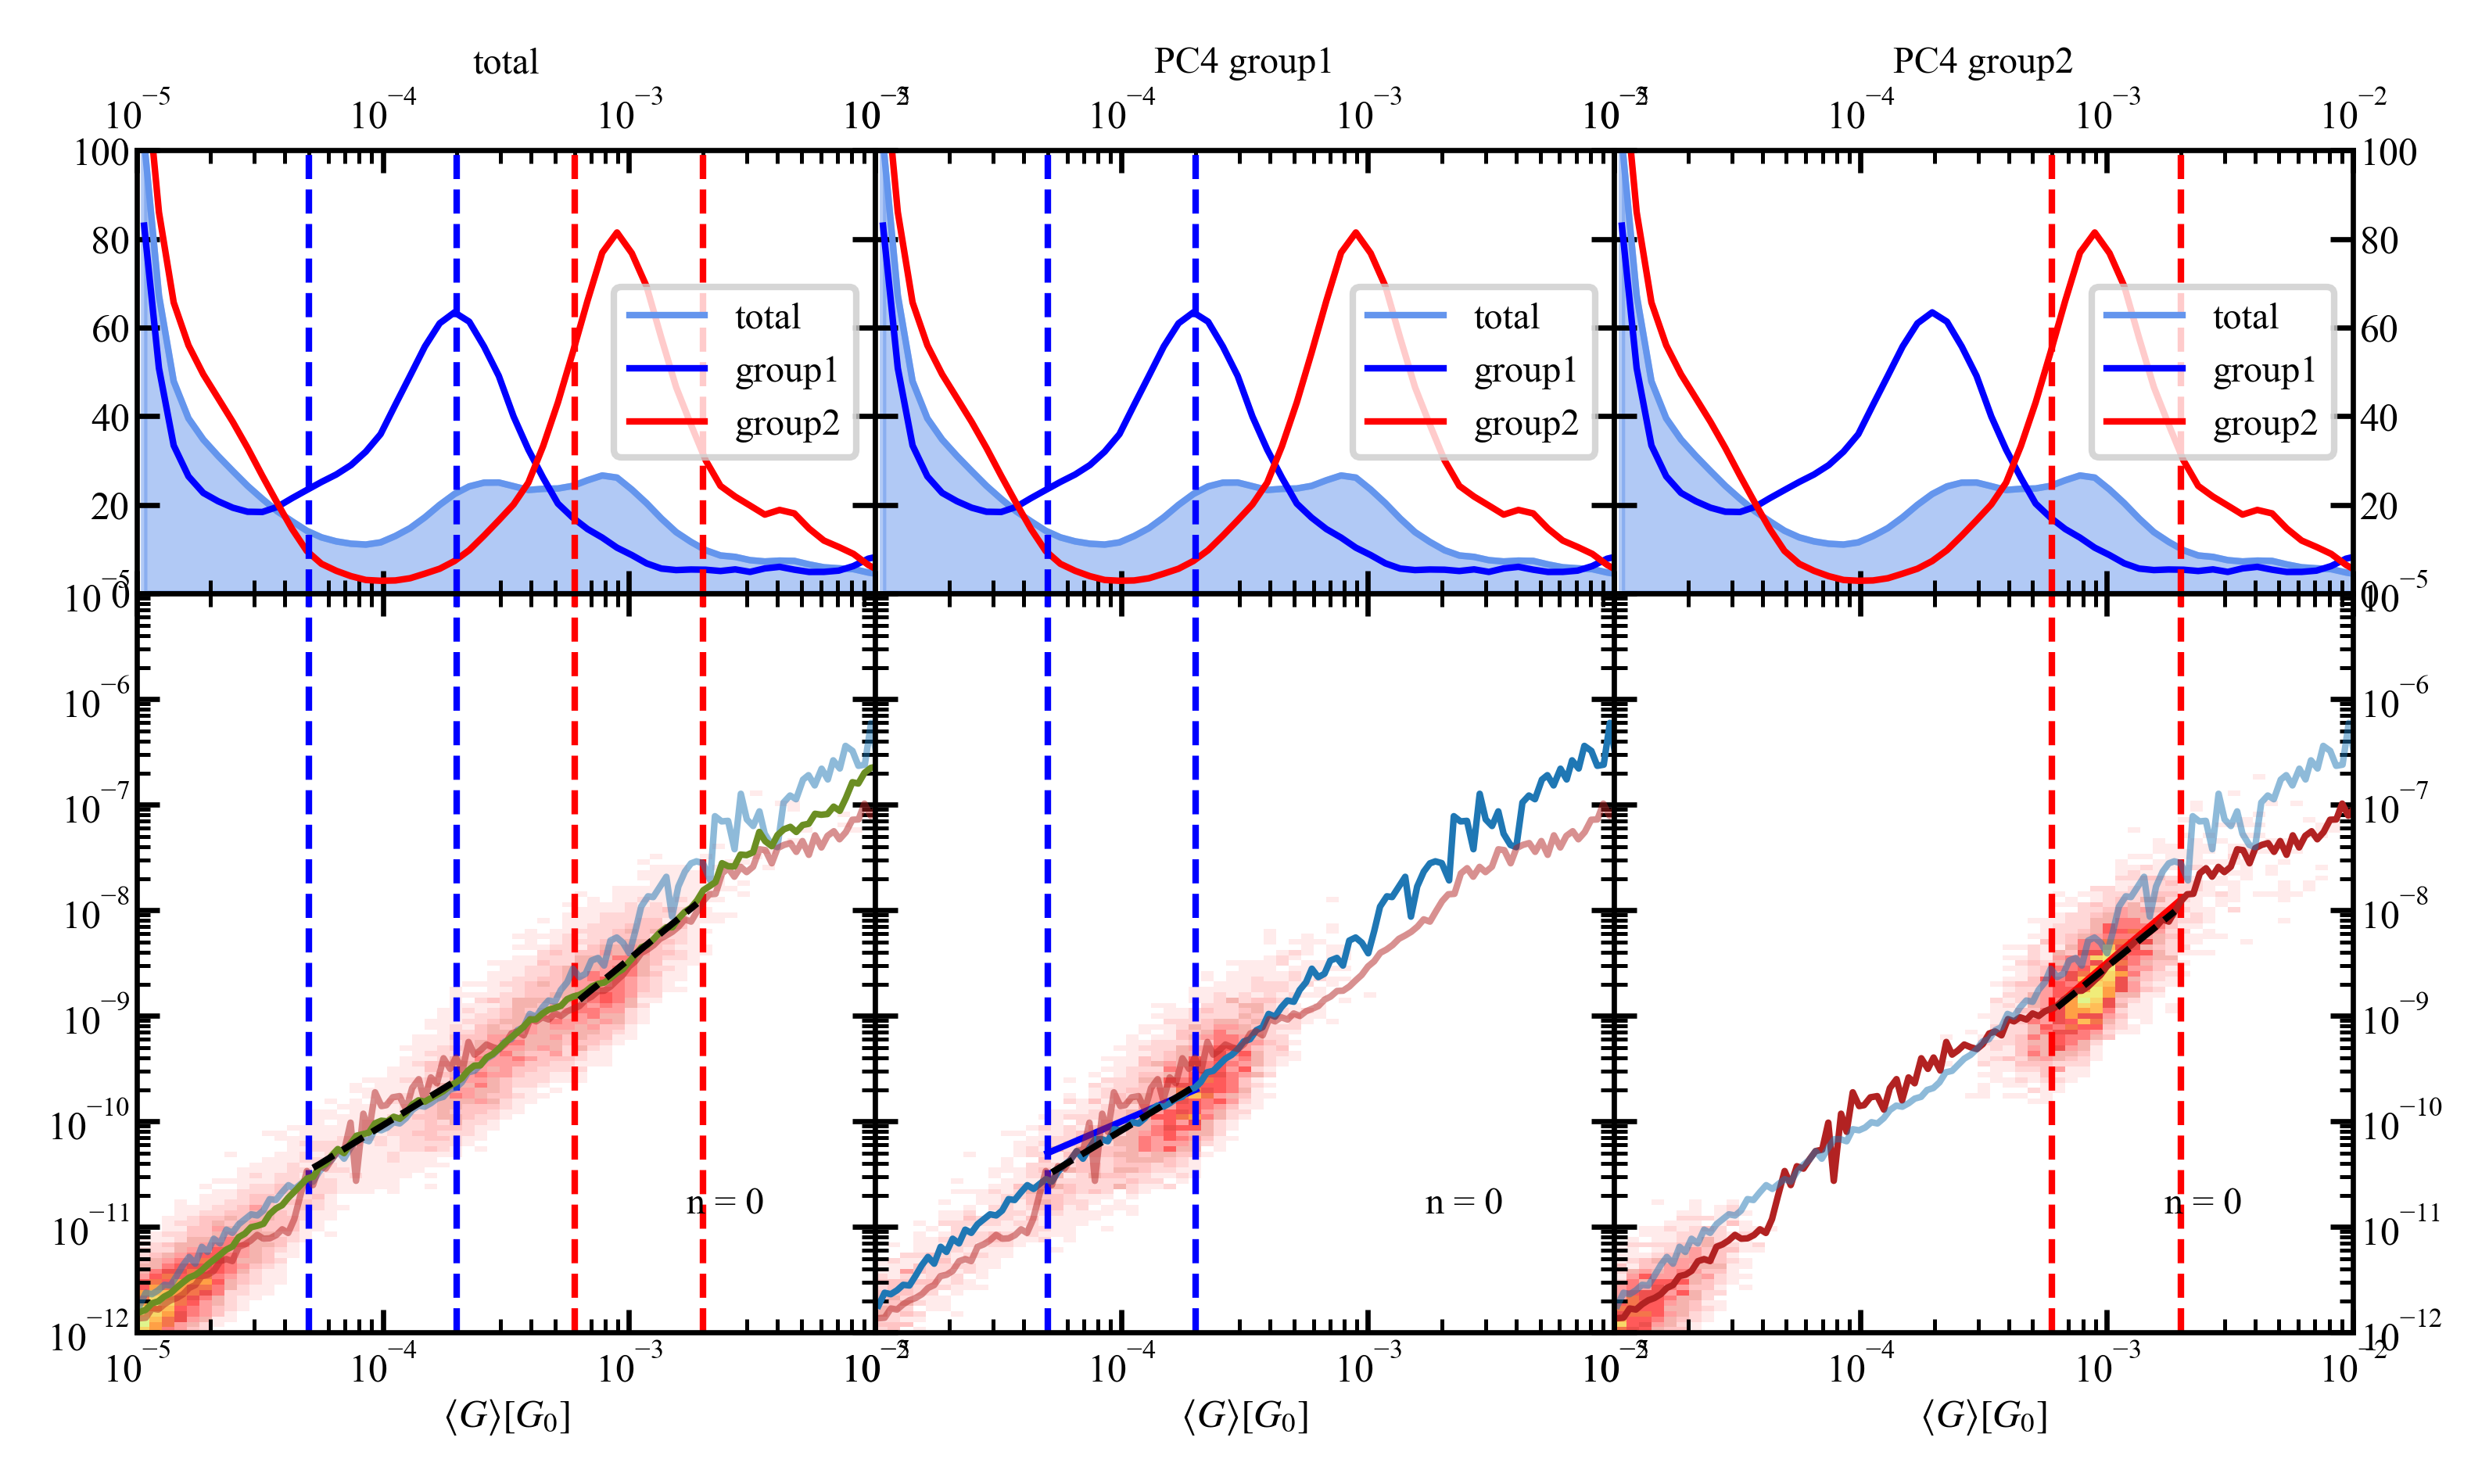

In [38]:
fig = plt.figure(figsize=utils.cm2inch(15, 8), dpi=600)  # figsize: (width, height) in inches
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 1), height_ratios=(3, 5),
                       figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0, hspace=0)

ax_hist_total = fig.add_subplot(gs[0, 0])
ax_hist_gr1 = fig.add_subplot(gs[0, 1])
ax_hist_gr2 = fig.add_subplot(gs[0, 2])

ax_total = fig.add_subplot(gs[1, 0])
ax_gr1 = fig.add_subplot(gs[1, 1])
ax_gr2 = fig.add_subplot(gs[1, 2])

ax_hist_total.xaxis.tick_top()
ax_hist_total.xaxis.set_label_position('top')
ax_hist_total.xaxis.set_ticks_position('both')
ax_hist_gr1.xaxis.tick_top()
ax_hist_gr1.xaxis.set_label_position('top')
ax_hist_gr1.xaxis.set_ticks_position('both')
ax_hist_gr2.xaxis.tick_top()
ax_hist_gr2.xaxis.set_label_position('top')
ax_hist_gr2.xaxis.set_ticks_position('both')

ax_hist_total.yaxis.set_ticks_position('both')
ax_hist_gr1.yaxis.set_ticks_position('both')
ax_hist_gr2.yaxis.tick_right()
ax_hist_gr2.yaxis.set_label_position('right')
ax_hist_gr2.yaxis.set_ticks_position('both')

# ax2 = fig.add_subplot(gs[1, 1])

# ax_gr1.xaxis.tick_top()
# ax_gr1.xaxis.set_label_position('top')
# ax_gr2.xaxis.tick_top()
# ax_gr2.xaxis.set_label_position('top')
ax_gr1.xaxis.set_ticks_position('both')
ax_gr2.xaxis.set_ticks_position('both')
ax_gr2.yaxis.tick_right()
ax_gr2.yaxis.set_label_position('right')
ax_gr1.yaxis.set_ticks_position('both')
ax_gr2.yaxis.set_ticks_position('both')

ax_total.xaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax_total.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

ax_hist_gr1.set_title('PC4 group1', fontsize='xx-small', pad=3)
ax_hist_gr2.set_title('PC4 group2', fontsize='xx-small', pad=3)
ax_hist_total.set_title('total', fontsize='xx-small', pad=3)

ax_hist_gr1.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr1.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr1.set_xscale('log')
ax_hist_gr1.set_xlim(1e-5, 1e-2)
ax_hist_gr1.set_ylim(0, 100)
ax_hist_gr1.legend(fontsize='xx-small')

ax_hist_gr2.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr2.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr2.set_xscale('log')
ax_hist_gr2.set_xlim(1e-5, 1e-2)
ax_hist_gr2.set_ylim(0, 100)
ax_hist_gr2.legend(fontsize='xx-small')

ax_hist_total.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_total.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_total.set_xscale('log')
ax_hist_total.set_xlim(1e-5, 1e-2)
ax_hist_total.set_ylim(0, 100)
ax_hist_total.legend(fontsize='xx-small')

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_1.flatten(),
                              noise_power=areas_pull_4_1.flatten(),
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-12, 1e-5),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr1, cmap=utils.cmap_geo32, vmax=200)

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_2.flatten(),
                              noise_power=areas_pull_4_2.flatten(),
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-12, 1e-5),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr2, cmap=utils.cmap_geo32, vmax=200)

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_all.flatten(),
                              noise_power=areas_pull_all.flatten(),
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-12, 1e-5),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_total, cmap=utils.cmap_geo32, vmax=500)

ax_gr1.yaxis.set_ticklabels([])
ax_hist_gr1.yaxis.set_ticklabels([])

xbins1=np.logspace(np.log10(G_low[0]), np.log10(G_low[1]), num=20)
xbins2=np.logspace(np.log10(G_high[0]), np.log10(G_high[1]), num=20)
shift1=-6
shift2=-2.5
ax_gr1.plot(xbins1, 10 ** (1 * np.log10(xbins1) + shift1), c='b', ls='-', lw=1)
ax_gr2.plot(xbins2, 10 ** (2 * np.log10(xbins2) + shift2), c='r', ls='-', lw=1)
shift1=-3
shift2=-1.2

ax_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_gr1.axvline(G_low[1], ls='--', c='b', lw=1)

ax_total.axvline(G_low[0], ls='--', c='b', lw=1)
ax_total.axvline(G_low[1], ls='--', c='b', lw=1)
ax_total.axvline(G_high[0], ls='--', c='r', lw=1)
ax_total.axvline(G_high[1], ls='--', c='r', lw=1)

ax_gr2.axvline(G_high[0], ls='--', c='r', lw=1)
ax_gr2.axvline(G_high[1], ls='--', c='r', lw=1)

ax_hist_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_hist_gr1.axvline(G_low[1], ls='--', c='b', lw=1)

ax_hist_total.axvline(G_low[0], ls='--', c='b', lw=1)
ax_hist_total.axvline(G_low[1], ls='--', c='b', lw=1)
ax_hist_total.axvline(G_high[0], ls='--', c='r', lw=1)
ax_hist_total.axvline(G_high[1], ls='--', c='r', lw=1)

ax_hist_gr2.axvline(G_high[0], ls='--', c='r', lw=1)
ax_hist_gr2.axvline(G_high[1], ls='--', c='r', lw=1)

ax_gr1.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1)
# ax_gr1.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0]-3*noise_err_4_1[cond_mean_4_1 > 0], lw=1)
# ax_gr1.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0]+3*noise_err_4_1[cond_mean_4_1 > 0], lw=1)
ax_gr2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick')

ax_gr2.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_gr1.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick', alpha=0.5)

ax_total.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], alpha=0.5, lw=1)
ax_total.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick', alpha=0.5, lw=1)

ax_total.plot(cond_mean_all[cond_mean_all > 0], noise_mean_all[cond_mean_all > 0], lw=1, c='olivedrab')

ax_gr1.plot(10**xdata_4_1, 10**(xdata_4_1*popt_4_1[0]+popt_4_1[1]), c='k', ls='--', lw=1)
ax_gr2.plot(10**xdata_4_2, 10**(xdata_4_2*popt_4_2[0]+popt_4_2[1]), c='k', ls='--', lw=1)

ax_total.plot(10**xdata_4_1, 10**(xdata_all_low*popt_all_1[0]+popt_all_1[1]), c='k', ls='--', lw=1)
ax_total.plot(10**xdata_4_2, 10**(xdata_all_high*popt_all_2[0]+popt_all_2[1]), c='k', ls='--', lw=1)

# ax2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')

In [81]:
num_of_decs_x = np.log10(1e-2) - np.log10(1e-5)
num_of_decs_y = np.log10(1) - np.log10(1e-2)

xbins = np.logspace(np.log10(1e-5), np.log10(1e-2), num=int(20 * num_of_decs_x)+1)
ybins = np.logspace(np.log10(1e-2), np.log10(1), num=int(20 * num_of_decs_y)+1)

h, xedges, yedges = np.histogram2d(cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
                                   np.sqrt(areas_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0])/(cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0]), bins=[xbins, ybins])
x_mesh, y_mesh = np.meshgrid(xedges, yedges)

In [77]:
num_of_decs_x = np.log10(1e-2) - np.log10(1e-5)
num_of_decs_y = np.log10(1) - np.log10(1e-2)

xbins = np.logspace(np.log10(1e-5), np.log10(1e-2), num=int(20 * num_of_decs_x)+1)
ybins = np.logspace(np.log10(1e-2), np.log10(1), num=int(20 * num_of_decs_y)+1)

h, xedges, yedges = np.histogram2d(cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten()>0],
                                   np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten()>0])/(cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten()>0]), bins=[xbins, ybins])
x_mesh, y_mesh = np.meshgrid(xedges, yedges)

In [75]:
num_of_decs_x = np.log10(1e-2) - np.log10(1e-5)
num_of_decs_y = np.log10(1) - np.log10(1e-2)

xbins = np.logspace(np.log10(1e-5), np.log10(1e-2), num=int(20 * num_of_decs_x)+1)
ybins = np.logspace(np.log10(1e-2), np.log10(1), num=int(20 * num_of_decs_y)+1)

h, xedges, yedges = np.histogram2d(cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten()>0],
                                   np.sqrt(areas_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten()>0])/(cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten()>0]), bins=[xbins, ybins])
x_mesh, y_mesh = np.meshgrid(xedges, yedges)

In [68]:
h.T

array([[0., 0., 0., ..., 2., 0., 3.],
       [0., 0., 0., ..., 5., 2., 2.],
       [0., 0., 0., ..., 5., 1., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [82]:
np.savetxt(home_folder.joinpath('results/noise_power_2d_all_8000.txt'), h)
np.savetxt(home_folder.joinpath('results/noise_power_2d_x_mesh_all_8000.txt'), x_mesh)
np.savetxt(home_folder.joinpath('results/noise_power_2d_y_mesh_all_8000.txt'), y_mesh)

In [58]:
np.unique(h.T > 0, return_counts=True)

(array([False,  True]), array([ 503, 1798], dtype=int64))

In [ ]:
print(f'total G_low: {popt_all_1[0]}')
print(f'total G_high: {popt_all_2[0]}')
print(f'PC4 group1: {popt_4_1[0]}')
print(f'PC4 group2: {popt_4_2[0]}')

In [ ]:
noise_mean_4_1, noise_err_4_1, cond_mean_4_1, cond_err_4_1 = plots.calc_noise_mean_in_bins(xbins=xbins,
                                                                                           noise=areas_pull_4_1[cond_avg_in_win_pull_4_1 > 0],
                                                                                           conductance=cond_avg_in_win_pull_4_1[cond_avg_in_win_pull_4_1 > 0],
                                                                                           noise_type='dG/G')

popt_4_1, pcov_4_1 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_4_1[np.bitwise_and(cond_mean_4_1 > G_low[0], cond_mean_4_1 < G_low[1])]),
                                              np.log10(noise_mean_4_1[np.bitwise_and(cond_mean_4_1 > G_low[0], cond_mean_4_1 < G_low[1])]))

In [ ]:
noise_mean_4_2, noise_err_4_2, cond_mean_4_2, cond_err_4_2 = plots.calc_noise_mean_in_bins(xbins=xbins,
                                                                                           noise=areas_pull_4_2[cond_avg_in_win_pull_4_2 > 0],
                                                                                           conductance=cond_avg_in_win_pull_4_2[cond_avg_in_win_pull_4_2 > 0],
                                                                                           noise_type='dG/G')

popt_4_2, pcov_4_2 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_4_2[np.bitwise_and(cond_mean_4_2 > G_high[0], cond_mean_4_2 < G_high[1])]),
                                              np.log10(noise_mean_4_2[np.bitwise_and(cond_mean_4_2 > G_high[0], cond_mean_4_2 < G_high[1])]))

In [43]:
noise_mean_all, noise_err_all, cond_mean_all, cond_err_all = plots.calc_noise_mean_in_bins(xbins=xbins,
                                                                                           noise=areas_pull_all,
                                                                                           conductance=cond_avg_in_win_pull_all,
                                                                                           noise_type='dG/G')

popt_all_1, pcov_all_1 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_all[np.bitwise_and(cond_mean_all > G_low[0], cond_mean_all < G_low[1])]),
                                              np.log10(noise_mean_all[np.bitwise_and(cond_mean_all > G_low[0], cond_mean_all < G_low[1])]))
popt_all_2, pcov_all_2 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_all[np.bitwise_and(cond_mean_all > G_high[0], cond_mean_all < G_high[1])]),
                                              np.log10(noise_mean_all[np.bitwise_and(cond_mean_all > G_high[0], cond_mean_all < G_high[1])]))

In [46]:
cmap_geo32_alpha = ListedColormap(np.array([[255 / 255, 255 / 255, 255 / 255, 0],
                                      [255 / 255, 235 / 255, 235 / 255, 0.1],
                                      [255 / 255, 215 / 255, 215 / 255, 0.2],
                                      [255 / 255, 196 / 255, 196 / 255, 0.3],
                                      [245 / 255, 179 / 255, 174 / 255, 1],
                                      [255 / 255, 158 / 255, 158 / 255, 1],
                                      [255 / 255, 124 / 255, 124 / 255, 1],
                                      [255 / 255, 90 / 255, 90 / 255, 1],
                                      [238 / 255, 80 / 255, 78 / 255, 1],
                                      [244 / 255, 117 / 255, 75 / 255, 1],
                                      [255 / 255, 160 / 255, 69 / 255, 1],
                                      [255 / 255, 189 / 255, 87 / 255, 1],
                                      [247 / 255, 215 / 255, 104 / 255, 1],
                                      [240 / 255, 236 / 255, 121 / 255, 1],
                                      [223 / 255, 245 / 255, 141 / 255, 1],
                                      [205 / 255, 255 / 255, 162 / 255, 1],
                                      [172 / 255, 245 / 255, 168 / 255, 1],
                                      [138 / 255, 236 / 255, 174 / 255, 1],
                                      [124 / 255, 235 / 255, 200 / 255, 1],
                                      [106 / 255, 235 / 255, 225 / 255, 1],
                                      [97 / 255, 225 / 255, 240 / 255, 1],
                                      [68 / 255, 202 / 255, 255 / 255, 1],
                                      [50 / 255, 190 / 255, 255 / 255, 1],
                                      [25 / 255, 175 / 255, 255 / 255, 1],
                                      [13 / 255, 129 / 255, 248 / 255, 1],
                                      [26 / 255, 102 / 255, 240 / 255, 1],
                                      [0 / 255, 40 / 255, 224 / 255, 1],
                                      [0 / 255, 25 / 255, 212 / 255, 1],
                                      [0 / 255, 10 / 255, 200 / 255, 1],
                                      [20 / 255, 5 / 255, 175 / 255, 1],
                                      [40 / 255, 0 / 255, 150 / 255, 1],
                                      [10 / 255, 0 / 255, 121 / 255, 1]]))

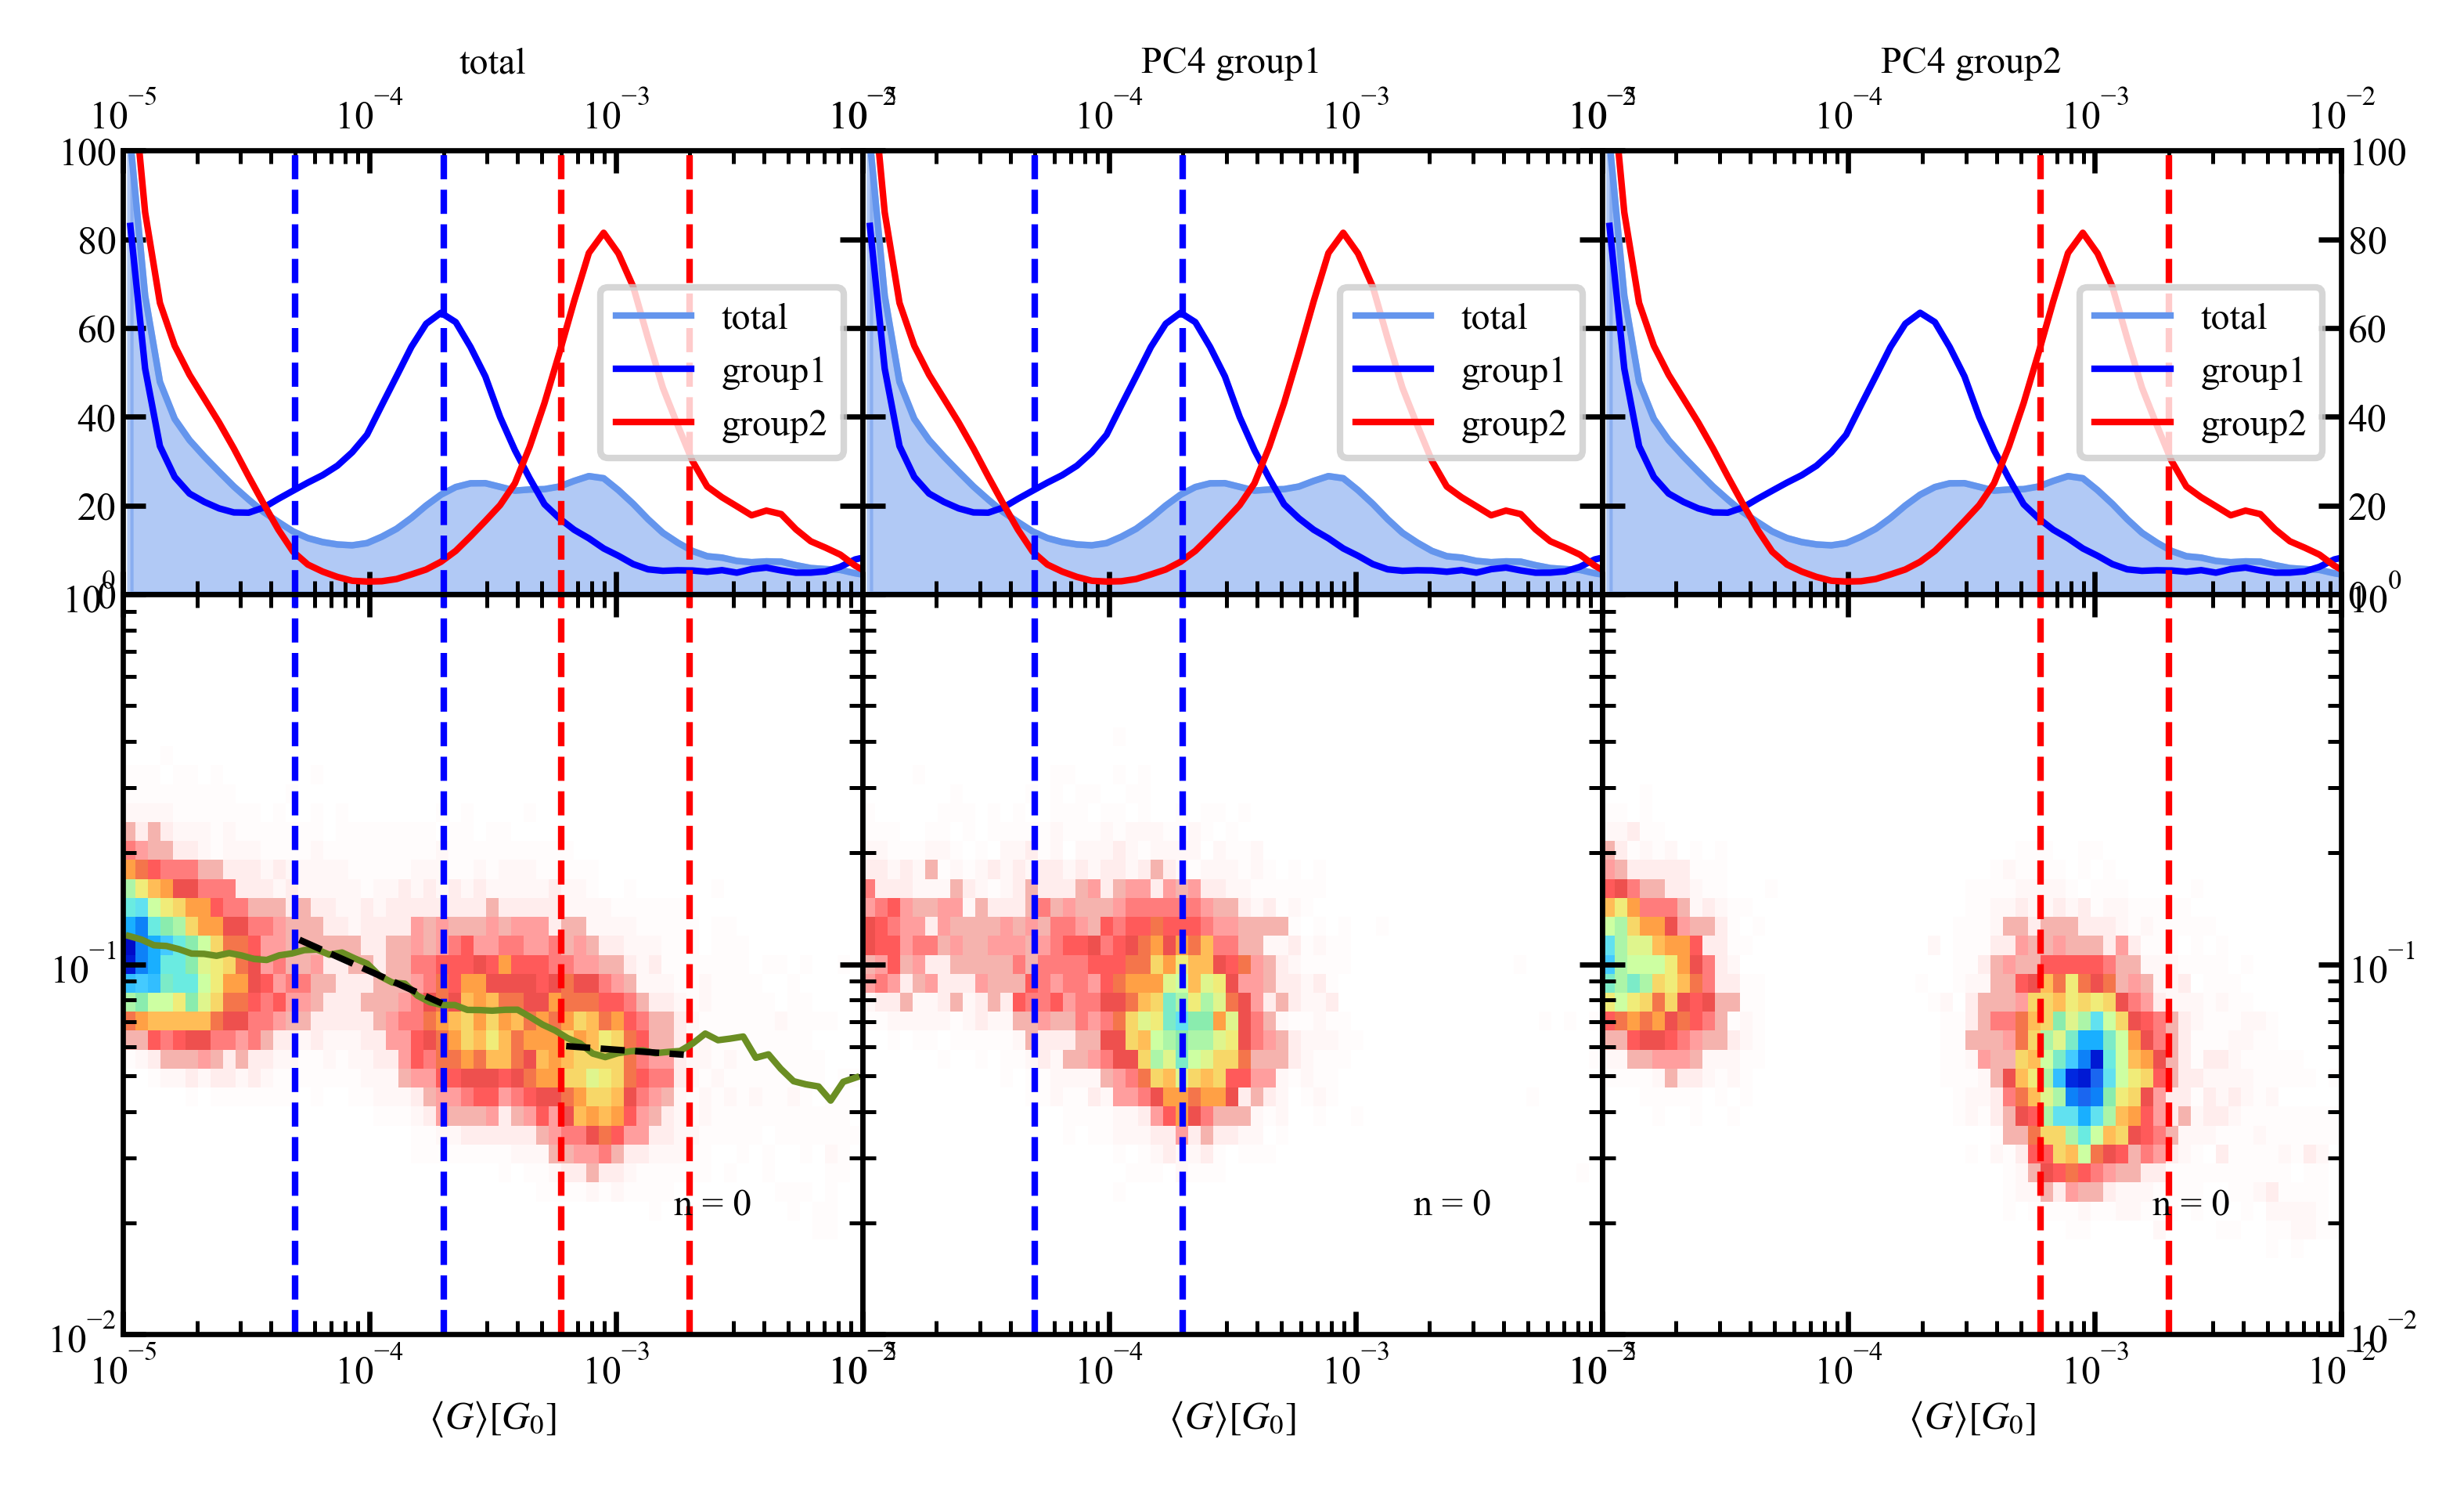

In [47]:
fig = plt.figure(figsize=utils.cm2inch(15, 8), dpi=600)  # figsize: (width, height) in inches
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 1), height_ratios=(3, 5),
                       figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0, hspace=0)

ax_hist_total = fig.add_subplot(gs[0, 0])
ax_hist_gr1 = fig.add_subplot(gs[0, 1])
ax_hist_gr2 = fig.add_subplot(gs[0, 2])

ax_total = fig.add_subplot(gs[1, 0])
ax_gr1 = fig.add_subplot(gs[1, 1])
ax_gr2 = fig.add_subplot(gs[1, 2])

ax_hist_total.xaxis.tick_top()
ax_hist_total.xaxis.set_label_position('top')
ax_hist_total.xaxis.set_ticks_position('both')
ax_hist_gr1.xaxis.tick_top()
ax_hist_gr1.xaxis.set_label_position('top')
ax_hist_gr1.xaxis.set_ticks_position('both')
ax_hist_gr2.xaxis.tick_top()
ax_hist_gr2.xaxis.set_label_position('top')
ax_hist_gr2.xaxis.set_ticks_position('both')

ax_hist_total.yaxis.set_ticks_position('both')
ax_hist_gr1.yaxis.set_ticks_position('both')
ax_hist_gr2.yaxis.tick_right()
ax_hist_gr2.yaxis.set_label_position('right')
ax_hist_gr2.yaxis.set_ticks_position('both')

# ax2 = fig.add_subplot(gs[1, 1])

# ax_gr1.xaxis.tick_top()
# ax_gr1.xaxis.set_label_position('top')
# ax_gr2.xaxis.tick_top()
# ax_gr2.xaxis.set_label_position('top')
ax_gr1.xaxis.set_ticks_position('both')
ax_gr2.xaxis.set_ticks_position('both')
ax_gr2.yaxis.tick_right()
ax_gr2.yaxis.set_label_position('right')
ax_gr1.yaxis.set_ticks_position('both')
ax_gr2.yaxis.set_ticks_position('both')

ax_total.xaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax_total.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

ax_hist_gr1.set_title('PC4 group1', fontsize='xx-small', pad=3)
ax_hist_gr2.set_title('PC4 group2', fontsize='xx-small', pad=3)
ax_hist_total.set_title('total', fontsize='xx-small', pad=3)

ax_hist_gr1.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr1.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr1.set_xscale('log')
ax_hist_gr1.set_xlim(1e-5, 1e-2)
ax_hist_gr1.set_ylim(0, 100)
ax_hist_gr1.legend(fontsize='xx-small')

ax_hist_gr2.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr2.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr2.set_xscale('log')
ax_hist_gr2.set_xlim(1e-5, 1e-2)
ax_hist_gr2.set_ylim(0, 100)
ax_hist_gr2.legend(fontsize='xx-small')

ax_hist_total.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_total.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_total.set_xscale('log')
ax_hist_total.set_xlim(1e-5, 1e-2)
ax_hist_total.set_ylim(0, 100)
ax_hist_total.legend(fontsize='xx-small')

# ax_gr1, n1 = plots.plot_correlation(n=N, correlation=pull_corrall, axis=ax_gr1)
# ax_gr2, n2 = plots.plot_correlation(n=N, correlation=pull_corrall, axis=ax_gr2)

xbins = np.logspace(np.log10(1e-5), np.log10(1e-2), num=int(20 * 3))
ybins = np.logspace(np.log10(1e-2), np.log10(10), num=int(20 * 2))

h, xedges, yedges = np.histogram2d(cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   bins=[xbins, ybins])
x_mesh, y_mesh = np.meshgrid(xedges, yedges)

h = h.T



plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                              noise_power=np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-2, 1),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr1, cmap=cmap_geo32_alpha, vmax=200)

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0],
                              noise_power=np.sqrt(areas_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0])/cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0],
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-2, 1),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr2, cmap=cmap_geo32_alpha, vmax=200)

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
                              noise_power=np.sqrt(areas_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0])/cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-2, 1),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_total, cmap=cmap_geo32_alpha, vmax=500)

ax_gr1.yaxis.set_ticklabels([])
ax_hist_gr1.yaxis.set_ticklabels([])

xbins1=np.logspace(np.log10(G_low[0]), np.log10(G_low[1]), num=20)
xbins2=np.logspace(np.log10(G_high[0]), np.log10(G_high[1]), num=20)
shift1=-6
shift2=-2.5
ax_gr1.plot(xbins1, 10 ** (1 * np.log10(xbins1) + shift1), c='b', ls='-', lw=1)
ax_gr2.plot(xbins2, 10 ** (2 * np.log10(xbins2) + shift2), c='r', ls='-', lw=1)
shift1=-3
shift2=-1.2

ax_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_gr1.axvline(G_low[1], ls='--', c='b', lw=1)

ax_total.axvline(G_low[0], ls='--', c='b', lw=1)
ax_total.axvline(G_low[1], ls='--', c='b', lw=1)
ax_total.axvline(G_high[0], ls='--', c='r', lw=1)
ax_total.axvline(G_high[1], ls='--', c='r', lw=1)

ax_gr2.axvline(G_high[0], ls='--', c='r', lw=1)
ax_gr2.axvline(G_high[1], ls='--', c='r', lw=1)

ax_hist_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_hist_gr1.axvline(G_low[1], ls='--', c='b', lw=1)

ax_hist_total.axvline(G_low[0], ls='--', c='b', lw=1)
ax_hist_total.axvline(G_low[1], ls='--', c='b', lw=1)
ax_hist_total.axvline(G_high[0], ls='--', c='r', lw=1)
ax_hist_total.axvline(G_high[1], ls='--', c='r', lw=1)

ax_hist_gr2.axvline(G_high[0], ls='--', c='r', lw=1)
ax_hist_gr2.axvline(G_high[1], ls='--', c='r', lw=1)

ax_gr1.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1)
ax_gr2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick')

ax_gr2.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_gr1.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick', alpha=0.5)

ax_total.plot(cond_mean_all[cond_mean_all > 0], noise_mean_all[cond_mean_all > 0], lw=1, c='olivedrab')
ax_total.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_total.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick', alpha=0.5)

ax_gr1.plot(10**xdata_4_1, 10**(xdata_4_1*popt_4_1[0]+popt_4_1[1]), c='k', ls='--', lw=1)
ax_gr2.plot(10**xdata_4_2, 10**(xdata_4_2*popt_4_2[0]+popt_4_2[1]), c='k', ls='--', lw=1)

ax_total.plot(10**xdata_4_1, 10**(xdata_4_1*popt_all_1[0]+popt_all_1[1]), c='k', ls='--', lw=1)
ax_total.plot(10**xdata_4_2, 10**(xdata_4_2*popt_all_2[0]+popt_all_2[1]), c='k', ls='--', lw=1)

# ax2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')

In [ ]:
fig = plt.figure(figsize=utils.cm2inch(15, 8), dpi=600)  # figsize: (width, height) in inches
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 1), height_ratios=(3, 5),
                       figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0, hspace=0)

ax_hist_total = fig.add_subplot(gs[0, 0])
ax_hist_gr1 = fig.add_subplot(gs[0, 1])
ax_hist_gr2 = fig.add_subplot(gs[0, 2])

ax_total = fig.add_subplot(gs[1, 0])
ax_gr1 = fig.add_subplot(gs[1, 1])
ax_gr2 = fig.add_subplot(gs[1, 2])

ax_hist_total.xaxis.tick_top()
ax_hist_total.xaxis.set_label_position('top')
ax_hist_total.xaxis.set_ticks_position('both')
ax_hist_gr1.xaxis.tick_top()
ax_hist_gr1.xaxis.set_label_position('top')
ax_hist_gr1.xaxis.set_ticks_position('both')
ax_hist_gr2.xaxis.tick_top()
ax_hist_gr2.xaxis.set_label_position('top')
ax_hist_gr2.xaxis.set_ticks_position('both')

ax_hist_total.yaxis.set_ticks_position('both')
ax_hist_gr1.yaxis.set_ticks_position('both')
ax_hist_gr2.yaxis.tick_right()
ax_hist_gr2.yaxis.set_label_position('right')
ax_hist_gr2.yaxis.set_ticks_position('both')

# ax2 = fig.add_subplot(gs[1, 1])

# ax_gr1.xaxis.tick_top()
# ax_gr1.xaxis.set_label_position('top')
# ax_gr2.xaxis.tick_top()
# ax_gr2.xaxis.set_label_position('top')
ax_gr1.xaxis.set_ticks_position('both')
ax_gr2.xaxis.set_ticks_position('both')
ax_gr2.yaxis.tick_right()
ax_gr2.yaxis.set_label_position('right')
ax_gr1.yaxis.set_ticks_position('both')
ax_gr2.yaxis.set_ticks_position('both')

ax_total.xaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax_total.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

ax_hist_gr1.set_title('PC4 group1', fontsize='xx-small', pad=3)
ax_hist_gr2.set_title('PC4 group2', fontsize='xx-small', pad=3)
ax_hist_total.set_title('total', fontsize='xx-small', pad=3)

ax_hist_gr1.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr1.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr1.set_xscale('log')
ax_hist_gr1.set_xlim(1e-5, 1e-2)
ax_hist_gr1.set_ylim(0, 100)
ax_hist_gr1.legend(fontsize='xx-small')

ax_hist_gr2.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr2.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr2.set_xscale('log')
ax_hist_gr2.set_xlim(1e-5, 1e-2)
ax_hist_gr2.set_ylim(0, 100)
ax_hist_gr2.legend(fontsize='xx-small')

ax_hist_total.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_total.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_total.set_xscale('log')
ax_hist_total.set_xlim(1e-5, 1e-2)
ax_hist_total.set_ylim(0, 100)
ax_hist_total.legend(fontsize='xx-small')

# ax_gr1, n1 = plots.plot_correlation(n=N, correlation=pull_corrall, axis=ax_gr1)
# ax_gr2, n2 = plots.plot_correlation(n=N, correlation=pull_corrall, axis=ax_gr2)

xbins = np.logspace(np.log10(1e-5), np.log10(1e-2), num=int(20 * 3))
ybins = np.logspace(np.log10(1e-2), np.log10(10), num=int(20 * 2))

h, xedges, yedges = np.histogram2d(cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   bins=[xbins, ybins])
x_mesh, y_mesh = np.meshgrid(xedges, yedges)

h = h.T



plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                              noise_power=np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-2, 1),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr1, cmap=cmap_geo32_alpha, vmax=150)

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0],
                              noise_power=np.sqrt(areas_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0])/cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0],
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-2, 1),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr2, cmap=cmap_geo32_alpha, vmax=150)

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
                              noise_power=np.sqrt(areas_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0])/cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-2, 1),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_total, cmap=cmap_geo32_alpha, vmax=500)

ax_gr1.yaxis.set_ticklabels([])
ax_hist_gr1.yaxis.set_ticklabels([])

xbins1=np.logspace(np.log10(G_low[0]), np.log10(G_low[1]), num=20)
xbins2=np.logspace(np.log10(G_high[0]), np.log10(G_high[1]), num=20)
shift1=-6
shift2=-2.5
ax_gr1.plot(xbins1, 10 ** (1 * np.log10(xbins1) + shift1), c='b', ls='-', lw=1)
ax_gr2.plot(xbins2, 10 ** (2 * np.log10(xbins2) + shift2), c='r', ls='-', lw=1)
shift1=-3
shift2=-1.2

ax_gr1.axvline(G_low[0], ls='--', c='k', lw=0.6)
ax_gr1.axvline(G_low[1], ls='--', c='k', lw=0.6)

ax_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_gr1.axvline(5e-4, ls='--', c='b', lw=1)

ax_total.axvline(G_low[0], ls='--', c='k', lw=1)
ax_total.axvline(G_low[1], ls='--', c='k', lw=1)
ax_total.axvline(G_high[0], ls='--', c='k', lw=1)
ax_total.axvline(G_high[1], ls='--', c='k', lw=1)

ax_gr2.axvline(G_high[0], ls='--', c='k', lw=0.6)
ax_gr2.axvline(G_high[1], ls='--', c='k', lw=0.6)
ax_gr2.axvline(4e-4, ls='--', c='r', lw=1)
ax_gr2.axvline(3e-3, ls='--', c='r', lw=1)

ax_hist_gr1.axvline(G_low[0], ls='--', c='k', lw=0.6)
ax_hist_gr1.axvline(G_low[1], ls='--', c='k', lw=0.6)

ax_hist_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_hist_gr1.axvline(5e-4, ls='--', c='b', lw=1)

ax_hist_total.axvline(G_low[0], ls='--', c='k', lw=1)
ax_hist_total.axvline(G_low[1], ls='--', c='k', lw=1)
ax_hist_total.axvline(G_high[0], ls='--', c='k', lw=1)
ax_hist_total.axvline(G_high[1], ls='--', c='k', lw=1)

ax_hist_gr2.axvline(G_high[0], ls='--', c='k', lw=0.6)
ax_hist_gr2.axvline(G_high[1], ls='--', c='k', lw=0.6)

ax_hist_gr2.axvline(4e-4, ls='--', c='r', lw=1)
ax_hist_gr2.axvline(3e-3, ls='--', c='r', lw=1)

ax_gr1.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1)
ax_gr2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick')

ax_gr2.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_gr1.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick', alpha=0.5)

ax_total.plot(cond_mean_all[cond_mean_all > 0], noise_mean_all[cond_mean_all > 0], lw=1, c='olivedrab')
ax_total.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_total.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick', alpha=0.5)

ax_gr1.plot(10**xdata_4_1, 10**(xdata_4_1*popt_4_1[0]+popt_4_1[1]), c='k', ls='--', lw=1)
ax_gr2.plot(10**xdata_4_2, 10**(xdata_4_2*popt_4_2[0]+popt_4_2[1]), c='k', ls='--', lw=1)

ax_total.plot(10**xdata_4_1, 10**(xdata_4_1*popt_all_1[0]+popt_all_1[1]), c='k', ls='--', lw=1)
ax_total.plot(10**xdata_4_2, 10**(xdata_4_2*popt_all_2[0]+popt_all_2[1]), c='k', ls='--', lw=1)

# ax2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')

hist_bins_1, hist4_1_mean = utils.calc_hist_1d_single(data=cond_avg_in_win_pull_4_1.flatten(), xrange=(1e-6, 10),
                                                xbins_num= 100, log_scale= True, bin_mode='total')
hist_bins_2, hist4_2_mean = utils.calc_hist_1d_single(data=cond_avg_in_win_pull_4_2.flatten(), xrange=(1e-6, 10),
                                                xbins_num= 100, log_scale= True, bin_mode='total')

ax_hist_gr1.plot(hist_bins_1, hist4_1_mean/40, label='mean1', lw=1)
ax_hist_gr2.plot(hist_bins_2, hist4_2_mean/40, label='mean2', c='FireBrick', lw=1)

In [ ]:
fig = plt.figure(figsize=utils.cm2inch(15, 8), dpi=600)  # figsize: (width, height) in inches
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 1), height_ratios=(3, 5),
                       figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0, hspace=0)

ax_hist_total = fig.add_subplot(gs[0, 0])
ax_hist_gr1 = fig.add_subplot(gs[0, 1])
ax_hist_gr2 = fig.add_subplot(gs[0, 2])

ax_total = fig.add_subplot(gs[1, 0])
ax_gr1 = fig.add_subplot(gs[1, 1])
ax_gr2 = fig.add_subplot(gs[1, 2])

ax_hist_total.xaxis.tick_top()
ax_hist_total.xaxis.set_label_position('top')
ax_hist_total.xaxis.set_ticks_position('both')
ax_hist_gr1.xaxis.tick_top()
ax_hist_gr1.xaxis.set_label_position('top')
ax_hist_gr1.xaxis.set_ticks_position('both')
ax_hist_gr2.xaxis.tick_top()
ax_hist_gr2.xaxis.set_label_position('top')
ax_hist_gr2.xaxis.set_ticks_position('both')

ax_hist_total.yaxis.set_ticks_position('both')
ax_hist_gr1.yaxis.set_ticks_position('both')
ax_hist_gr2.yaxis.tick_right()
ax_hist_gr2.yaxis.set_label_position('right')
ax_hist_gr2.yaxis.set_ticks_position('both')

# ax2 = fig.add_subplot(gs[1, 1])

# ax_gr1.xaxis.tick_top()
# ax_gr1.xaxis.set_label_position('top')
# ax_gr2.xaxis.tick_top()
# ax_gr2.xaxis.set_label_position('top')
ax_gr1.xaxis.set_ticks_position('both')
ax_gr2.xaxis.set_ticks_position('both')
ax_gr2.yaxis.tick_right()
ax_gr2.yaxis.set_label_position('right')
ax_gr1.yaxis.set_ticks_position('both')
ax_gr2.yaxis.set_ticks_position('both')

ax_total.xaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax_total.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

ax_hist_gr1.set_title('PC4 group1', fontsize='xx-small', pad=3)
ax_hist_gr2.set_title('PC4 group2', fontsize='xx-small', pad=3)
ax_hist_total.set_title('total', fontsize='xx-small', pad=3)

ax_hist_gr1.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr1.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr1.set_xscale('log')
ax_hist_gr1.set_xlim(1e-5, 1e-2)
ax_hist_gr1.set_ylim(0, 100)
ax_hist_gr1.legend(fontsize='xx-small')

ax_hist_gr2.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr2.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr2.set_xscale('log')
ax_hist_gr2.set_xlim(1e-5, 1e-2)
ax_hist_gr2.set_ylim(0, 100)
ax_hist_gr2.legend(fontsize='xx-small')

ax_hist_total.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_total.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_total.set_xscale('log')
ax_hist_total.set_xlim(1e-5, 1e-2)
ax_hist_total.set_ylim(0, 100)
ax_hist_total.legend(fontsize='xx-small')

# ax_gr1, n1 = plots.plot_correlation(n=N, correlation=pull_corrall, axis=ax_gr1)
# ax_gr2, n2 = plots.plot_correlation(n=N, correlation=pull_corrall, axis=ax_gr2)

xbins = np.logspace(np.log10(1e-5), np.log10(1e-2), num=int(20 * 3))
ybins = np.logspace(np.log10(1e-2), np.log10(10), num=int(20 * 2))

h, xedges, yedges = np.histogram2d(cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   bins=[xbins, ybins])
x_mesh, y_mesh = np.meshgrid(xedges, yedges)

h = h.T



# plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
#                               noise_power=np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
#                               n=0,
#                               xrange=(1e-5, 1e-2),
#                               yrange=(1e-2, 1),
#                               num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr1, cmap=cmap_geo32_alpha, vmax=150)

# plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0],
#                               noise_power=np.sqrt(areas_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0])/cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0],
#                               n=0,
#                               xrange=(1e-5, 1e-2),
#                               yrange=(1e-2, 1),
#                               num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr2, cmap=cmap_geo32_alpha, vmax=150)

# plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
#                               noise_power=np.sqrt(areas_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0])/cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
#                               n=0,
#                               xrange=(1e-5, 1e-2),
#                               yrange=(1e-2, 1),
#                               num_bins=(20, 20), shift=-4, normalize=False, axis=ax_total, cmap=cmap_geo32_alpha, vmax=500)

ax_gr1.set_xscale('log')
ax_gr2.set_xscale('log')
ax_total.set_xscale('log')
ax_gr1.set_yscale('log')
ax_gr2.set_yscale('log')
ax_total.set_yscale('log')

ax_gr1.set_xlim(1e-5, 1e-2)
ax_gr2.set_xlim(1e-5, 1e-2)
ax_total.set_xlim(1e-5, 1e-2)
ax_gr1.set_ylim(3e-2, 3e-1)
ax_gr2.set_ylim(3e-2, 3e-1)
ax_total.set_ylim(3e-2, 3e-1)

ax_gr1.yaxis.set_ticklabels([])
ax_hist_gr1.yaxis.set_ticklabels([])

xbins1=np.logspace(np.log10(G_low[0]), np.log10(G_low[1]), num=20)
xbins2=np.logspace(np.log10(G_high[0]), np.log10(G_high[1]), num=20)
shift1=-6
shift2=-2.5
ax_gr1.plot(xbins1, 10 ** (1 * np.log10(xbins1) + shift1), c='b', ls='-', lw=1)
ax_gr2.plot(xbins2, 10 ** (2 * np.log10(xbins2) + shift2), c='r', ls='-', lw=1)
shift1=-3
shift2=-1.2

ax_gr1.axvline(G_low[0], ls='--', c='k', lw=0.6)
ax_gr1.axvline(G_low[1], ls='--', c='k', lw=0.6)

ax_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_gr1.axvline(5e-4, ls='--', c='b', lw=1)

ax_total.axvline(G_low[0], ls='--', c='k', lw=1)
ax_total.axvline(G_low[1], ls='--', c='k', lw=1)
ax_total.axvline(G_high[0], ls='--', c='k', lw=1)
ax_total.axvline(G_high[1], ls='--', c='k', lw=1)

ax_gr2.axvline(G_high[0], ls='--', c='k', lw=0.6)
ax_gr2.axvline(G_high[1], ls='--', c='k', lw=0.6)
ax_gr2.axvline(4e-4, ls='--', c='r', lw=1)
ax_gr2.axvline(3e-3, ls='--', c='r', lw=1)

ax_hist_gr1.axvline(G_low[0], ls='--', c='k', lw=0.6)
ax_hist_gr1.axvline(G_low[1], ls='--', c='k', lw=0.6)

ax_hist_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_hist_gr1.axvline(5e-4, ls='--', c='b', lw=1)

ax_hist_total.axvline(G_low[0], ls='--', c='k', lw=1)
ax_hist_total.axvline(G_low[1], ls='--', c='k', lw=1)
ax_hist_total.axvline(G_high[0], ls='--', c='k', lw=1)
ax_hist_total.axvline(G_high[1], ls='--', c='k', lw=1)

ax_hist_gr2.axvline(G_high[0], ls='--', c='k', lw=0.6)
ax_hist_gr2.axvline(G_high[1], ls='--', c='k', lw=0.6)

ax_hist_gr2.axvline(4e-4, ls='--', c='r', lw=1)
ax_hist_gr2.axvline(3e-3, ls='--', c='r', lw=1)

ax_gr1.scatter(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], s=3, edgecolor='None')
ax_gr2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick')

ax_gr2.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_gr1.scatter(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], s=3, edgecolor='None', c='Firebrick', alpha=0.5)


ax_total.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_total.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick', alpha=0.5)
ax_total.plot(cond_mean_all[cond_mean_all > 0], noise_mean_all[cond_mean_all > 0], lw=1.5, c='olivedrab')

ax_gr1.plot(10**xdata_4_1, 10**(xdata_4_1*popt_4_1[0]+popt_4_1[1]), c='k', ls='--', lw=1)
ax_gr2.plot(10**xdata_4_2, 10**(xdata_4_2*popt_4_2[0]+popt_4_2[1]), c='k', ls='--', lw=1)

ax_total.plot(10**xdata_4_1, 10**(xdata_4_1*popt_all_1[0]+popt_all_1[1]), c='k', ls='--', lw=1)
ax_total.plot(10**xdata_4_2, 10**(xdata_4_2*popt_all_2[0]+popt_all_2[1]), c='k', ls='--', lw=1)

# ax2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')

hist_bins_1, hist4_1_mean = utils.calc_hist_1d_single(data=cond_avg_in_win_pull_4_1.flatten(), xrange=(1e-6, 10),
                                                xbins_num= 100, log_scale= True, bin_mode='total')
hist_bins_2, hist4_2_mean = utils.calc_hist_1d_single(data=cond_avg_in_win_pull_4_2.flatten(), xrange=(1e-6, 10),
                                                xbins_num= 100, log_scale= True, bin_mode='total')

ax_hist_gr1.plot(hist_bins_1, hist4_1_mean/40, label='mean1', lw=1)
ax_hist_gr2.plot(hist_bins_2, hist4_2_mean/40, label='mean2', c='FireBrick', lw=1)

In [ ]:
cond_avg_in_win_pull_4_2.shape

In [ ]:
print(f'total G_low: {popt_all_1[0]}')
print(f'total G_high: {popt_all_2[0]}')
print(f'PC4 group1: {popt_4_1[0]}')
print(f'PC4 group2: {popt_4_2[0]}')

In [ ]:
xbins = pc.hist_group1['PC4'].hist_1d_bins
ybins = np.logspace(np.log10(1e-2), np.log10(10), num=int(20 * 2))

h, xedges, yedges = np.histogram2d(cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   bins=[xbins, ybins])
x_mesh, y_mesh = np.meshgrid(xedges, yedges)

h = h.T
print(h.shape)

In [ ]:
pc.hist_group1['PC4'].hist_1d_bins.shape

#### Comparison

In [ ]:
fig, axs = plt.subplots(5, dpi=300, figsize=(10, 4*5))

for i, ax in enumerate(axs):
    ax.set_xscale('log')
    ax.set_ylim(0, 200)
    ax.set_xlim(1e-5, 10)

    ax.plot(hist.hist_1d_bins, hist.hist_1d_pull, label='total', c='cornflowerblue')
    ax.fill_between(hist.hist_1d_bins, np.zeros_like(hist.hist_1d_pull), hist.hist_1d_pull,
                       alpha=0.5, color='cornflowerblue')

    ax.plot(pc10_hist_group1[pc.pc_keys[i]].hist_1d_bins,
               pc10_hist_group1[pc.pc_keys[i]].hist_1d_pull, label='group1 10%', c=utils.blues[0])
    
    ax.plot(pc10_hist_group2[pc.pc_keys[i]].hist_1d_bins,
               pc10_hist_group2[pc.pc_keys[i]].hist_1d_pull, label='group2 10%', c=utils.reds[0])
    
    ax.plot(pc20_hist_group1[pc.pc_keys[i]].hist_1d_bins,
               pc20_hist_group1[pc.pc_keys[i]].hist_1d_pull, label='group1 20%', c=utils.blues[1])
    
    ax.plot(pc20_hist_group2[pc.pc_keys[i]].hist_1d_bins,
               pc20_hist_group2[pc.pc_keys[i]].hist_1d_pull, label='group2 20%', c=utils.reds[1])
    
    ax.plot(pc30_hist_group1[pc.pc_keys[i]].hist_1d_bins,
               pc30_hist_group1[pc.pc_keys[i]].hist_1d_pull, label='group1 30%', c=utils.blues[2])
    
    ax.plot(pc30_hist_group2[pc.pc_keys[i]].hist_1d_bins,
               pc30_hist_group2[pc.pc_keys[i]].hist_1d_pull, label='group2 30%', c=utils.reds[2])
    
    ax.plot(pc40_hist_group1[pc.pc_keys[i]].hist_1d_bins,
               pc40_hist_group1[pc.pc_keys[i]].hist_1d_pull, label='group1 40%', c=utils.blues[i])
    
    ax.plot(pc40_hist_group2[pc.pc_keys[i]].hist_1d_bins,
               pc40_hist_group2[pc.pc_keys[i]].hist_1d_pull, label='group2 40%', c=utils.reds[i])
    
#     ax.plot(pc50_hist_group1[pc.pc_keys[i]].hist_1d_bins,
#                pc50_hist_group1[pc.pc_keys[i]].hist_1d_pull, label='group1 50%', c=utils.blues[i])
    
#     ax.plot(pc50_hist_group2[pc.pc_keys[i]].hist_1d_bins,
#                pc50_hist_group2[pc.pc_keys[i]].hist_1d_pull, label='group2 50%', c=utils.reds[i])
    
#     ax.plot(pc60_hist_group1[pc.pc_keys[i]].hist_1d_bins,
#                pc60_hist_group1[pc.pc_keys[i]].hist_1d_pull, label='group1 60%', c=utils.blues[i])
    
#     ax.plot(pc60_hist_group2[pc.pc_keys[i]].hist_1d_bins,
#                pc60_hist_group2[pc.pc_keys[i]].hist_1d_pull, label='group2 60%', c=utils.reds[i])
    
    ax.set_title(pc.pc_keys[i], fontsize='xx-small', pad=3)
    ax.legend(fontsize='xx-small')

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=4, dpi=300, figsize=(4*5, 5*5))

for i in range(len(pc.pc_keys)):
    for j, pcx_hist_group1 in enumerate((pc10_hist_group1, pc20_hist_group1, pc30_hist_group1, pc40_hist_group1)):  #, pc40_hist_group1, pc50_hist_group1, pc60_hist_group1)
        axs[i, j] = pcx_hist_group1[pc.pc_keys[i]].plot_hist_2d_one(direction='pull', ax=axs[i, j], vmax=5_000*(j+1))
        axs[i, j].set_xlim(-0.5, 0.5)

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=4, dpi=300, figsize=(4*5, 5*5))

for i in range(len(pc.pc_keys)):
    for j, pcx_hist_group1 in enumerate((pc10_hist_group1, pc20_hist_group1, pc30_hist_group1, pc40_hist_group1)):  #, pc40_hist_group1, pc50_hist_group1, pc60_hist_group1)
        axs[i, j] = pcx_hist_group1[pc.pc_keys[i]].plot_hist_2d_one(direction='push', ax=axs[i, j], vmax=5_000*(j+1))
#         axs[i, j].set_xlim(-0.5, 0.5)

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=4, dpi=300, figsize=(4*5, 5*5))

for i in range(len(pc.pc_keys)):
    for j, pcx_hist_group2 in enumerate((pc10_hist_group2, pc20_hist_group2, pc30_hist_group2, pc40_hist_group2)):  #, pc40_hist_group1, pc50_hist_group1, pc60_hist_group1)
        axs[i, j] = pcx_hist_group2[pc.pc_keys[i]].plot_hist_2d_one(direction='pull', ax=axs[i, j], vmax=5_000*(j+1))
        axs[i, j].set_xlim(-0.5, 0.5)

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=4, dpi=300, figsize=(4*5, 5*5))

for i in range(len(pc.pc_keys)):
    for j, pcx_hist_group2 in enumerate((pc10_hist_group2, pc20_hist_group2, pc30_hist_group2, pc40_hist_group2)):  #, pc40_hist_group1, pc50_hist_group1, pc60_hist_group1)
        axs[i, j] = pcx_hist_group2[pc.pc_keys[i]].plot_hist_2d_one(direction='push', ax=axs[i, j], vmax=5_000*(j+1))
#         axs[i, j].set_xlim(-0.5, 0.5)

In [ ]:
pc.traces_group1['PC4'].shape

In [ ]:
G_high = (6e-4, 2e-3)
G_low = (5e-5, 2e-4)

In [ ]:
rand_selection_gr1 = np.random.choice(pc.traces_group1['PC4'], 10)

In [ ]:
# example+=1
ax = hist.plot_example_traces(traces=tuple(rand_selection_gr1), shift=0.25, lw=0.5)
ax.set_xlim(-0.2, 3.2)
for i in range(2):
    ax.axhline(G_low[i], ls='--', lw=0.5, c='b')
    ax.axhline(G_high[i], ls='--', lw=0.5, c='r')
    
ax.axvline(0, ls='--', c='k', lw=0.5)
ax.axvline(200/trace_pair.sample_rate*trace_pair.rate, ls='--', c='grey', lw=0.5)
for i in range(1, 4):
    ax.axvline((200+i*256)/trace_pair.sample_rate*trace_pair.rate, ls='--', c='lightgrey', lw=0.5)
    
ax.axvline(0+0.25, ls='--', c='k', lw=0.5)
ax.axvline(200/trace_pair.sample_rate*trace_pair.rate+0.25, ls='--', c='grey', lw=0.5)
for i in range(1, 4):
    ax.axvline((200+i*256)/trace_pair.sample_rate*trace_pair.rate+0.25, ls='--', c='lightgrey', lw=0.5)
    
ax.set_title('PC4 group1 example traces', fontsize='xx-small', pad=3)
plt.savefig(home_folder.joinpath(f'example_traces_PC4_group1.png'), bbox_inches='tight', facecolor='white')

In [ ]:
rand_selection_gr2 = np.random.choice(pc.traces_group2['PC4'], 10)

In [ ]:
# example+=1
ax = hist.plot_example_traces(traces=tuple(rand_selection_gr2), shift=0.25, lw=0.5)
ax.set_xlim(-0.2, 3.2)
for i in range(2):
    ax.axhline(G_low[i], ls='--', lw=0.5, c='b')
    ax.axhline(G_high[i], ls='--', lw=0.5, c='r')
    
ax.axvline(0, ls='--', c='k', lw=0.5)
ax.axvline(200/trace_pair.sample_rate*trace_pair.rate, ls='--', c='grey', lw=0.5)
for i in range(1, 4):
    ax.axvline((200+i*256)/trace_pair.sample_rate*trace_pair.rate, ls='--', c='lightgrey', lw=0.5)
    
ax.axvline(0+0.25, ls='--', c='k', lw=0.5)
ax.axvline(200/trace_pair.sample_rate*trace_pair.rate+0.25, ls='--', c='grey', lw=0.5)
for i in range(1, 4):
    ax.axvline((200+i*256)/trace_pair.sample_rate*trace_pair.rate+0.25, ls='--', c='lightgrey', lw=0.5)
    
ax.set_title('PC4 group2 example traces', fontsize='xx-small', pad=3)
plt.savefig(home_folder.joinpath(f'example_traces_PC4_group2.png'), bbox_inches='tight', facecolor='white')

In [ ]:
updated_gr1, cond_pull_gr1, piez_pull_gr1 = collect_traces(rand_selection_gr1, align_val=2e-2)

In [ ]:
xmesh_gr1, ymesh_gr1, hist_2d_gr1 = calc_2d_hist_for_collected(updated_gr1, cond_pull_gr1, piez_pull_gr1)

In [ ]:
areas_pull_gr1, cond_avg_in_win_pull_gr1, psd_all_gr1, fft_freqs_gr1 = noise_analysis(updated_gr1, cond_pull_gr1, piez_pull_gr1, win_size=256, step_size=None, skip_points=50, end_point=3000)

In [ ]:
updated_gr2, cond_pull_gr2, piez_pull_gr2 = collect_traces(rand_selection_gr2, align_val=2e-2)

In [ ]:
xmesh_gr2, ymesh_gr2, hist_2d_gr2 = calc_2d_hist_for_collected(updated_gr2, cond_pull_gr2, piez_pull_gr2)

In [ ]:
areas_pull_gr2, cond_avg_in_win_pull_gr2, psd_all_gr2, fft_freqs_gr2 = noise_analysis(updated_gr2, cond_pull_gr2, piez_pull_gr2, win_size=256, step_size=None, skip_points=50, end_point=3000)

In [ ]:
fig = plt.figure(figsize=utils.cm2inch(20, 5), dpi=600)  # figsize: (width, height) in inches
gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=(1, 1, 1, 1),
                       figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0, hspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

ax1.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))
ax2.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))
ax3.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))
ax4.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))

ax3.xaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax3.yaxis.set_ticks_position('both')
ax4.yaxis.set_ticks_position('both')

ax1.xaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax1.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

ax1.set_title('Noise power group1', fontsize='xx-small', pad=3)
ax2.set_title('Noise power group2', fontsize='xx-small', pad=3)
ax3.set_title('dG/G group1', fontsize='xx-small', pad=3)
ax4.set_title('dG/G group2', fontsize='xx-small', pad=3)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax4.set_xscale('log')
ax4.set_yscale('log')

for trace in range(len(updated_gr1)):
    ax1.scatter(cond_avg_in_win_pull_gr1[trace, :], areas_pull_gr1[trace, :], s=1)
    
for trace in range(len(updated_gr2)):
    ax2.scatter(cond_avg_in_win_pull_gr2[trace, :], areas_pull_gr2[trace, :], s=1)
    
for trace in range(len(updated_gr1)):
    ax3.scatter(cond_avg_in_win_pull_gr1[trace, :],
                np.sqrt(areas_pull_gr1[trace, :])/cond_avg_in_win_pull_gr1[trace, :], s=1)
    
for trace in range(len(updated_gr2)):
    ax4.scatter(cond_avg_in_win_pull_gr2[trace, :],
                np.sqrt(areas_pull_gr2[trace, :])/cond_avg_in_win_pull_gr2[trace, :], s=1)

ax1.set_ylim(1e-12, 1e-5)
ax2.set_ylim(ax1.get_ylim())
ax3.set_ylim(1e-3, 10)
ax4.set_ylim(ax3.get_ylim())

ax1.set_xlim(1e-5, 0.1)
ax2.set_xlim(ax1.get_xlim())
ax3.set_xlim(ax1.get_xlim())
ax4.set_xlim(ax1.get_xlim())

ax1.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax1.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax1.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax2.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax2.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax2.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax3.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax3.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax3.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax4.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax4.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax4.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))

# xbins1=np.logspace(np.log10(G_low[0]), np.log10(G_low[1]), num=20)
# xbins2=np.logspace(np.log10(G_high[0]), np.log10(G_high[1]), num=20)
# shift1=-6
# shift2=-2.5
# ax3.plot(xbins1, 10 ** (1 * np.log10(xbins1) + shift1), c='b', ls='-', lw=1)
# ax4.plot(xbins2, 10 ** (2 * np.log10(xbins2) + shift2), c='r', ls='-', lw=1)
# shift1=-3
# shift2=-1.2

ax3.axvline(G_low[0], ls='--', c='b', lw=1)
ax3.axvline(G_low[1], ls='--', c='b', lw=1)

ax1.axvline(G_low[0], ls='--', c='b', lw=1)
ax1.axvline(G_low[1], ls='--', c='b', lw=1)
ax1.axvline(G_high[0], ls='--', c='r', lw=1)
ax1.axvline(G_high[1], ls='--', c='r', lw=1)

ax2.axvline(G_low[0], ls='--', c='b', lw=1)
ax2.axvline(G_low[1], ls='--', c='b', lw=1)
ax2.axvline(G_high[0], ls='--', c='r', lw=1)
ax2.axvline(G_high[1], ls='--', c='r', lw=1)

ax4.axvline(G_high[0], ls='--', c='r', lw=1)
ax4.axvline(G_high[1], ls='--', c='r', lw=1)

# ax2.plot(cond_mean_both[cond_mean_both > 0], noise_mean_both[cond_mean_both > 0])
# ax2.plot(10**xdata_4_1, 10**(xdata_4_1*popt_both_1[0]+popt_both_1[1]), c='k', ls='--', lw=1)
# ax2.plot(10**xdata_4_2, 10**(xdata_4_2*popt_both_2[0]+popt_both_2[1]), c='k', ls='--', lw=1)

# ax3.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0])
# ax4.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')

# ax4.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0])
# ax3.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')

# ax1.plot(cond_mean_all[cond_mean_all > 0], noise_mean_all[cond_mean_all > 0])

# ax3.plot(10**xdata_4_1, 10**(xdata_4_1*popt_4_1[0]+popt_4_1[1]), c='k', ls='--', lw=1)
# ax4.plot(10**xdata_4_2, 10**(xdata_4_2*popt_4_2[0]+popt_4_2[1]), c='k', ls='--', lw=1)

# ax1.plot(10**xdata_4_1, 10**(xdata_4_1*popt_all_1[0]+popt_all_1[1]), c='k', ls='--', lw=1)
# ax1.plot(10**xdata_4_2, 10**(xdata_4_2*popt_all_2[0]+popt_all_2[1]), c='k', ls='--', lw=1)

# ax2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')
plt.savefig(home_folder.joinpath(f'noise_for example_traces_gr1-2_factor5.png'), bbox_inches='tight', facecolor='white')

In [ ]:
rand_selection_gr1 == updated_gr1

In [ ]:
# pc.traces_group2['PC4']

def plot_example_traces_w_noise(rand_selection_group,
                                cond_avg_in_win_pull_group,
                                areas_pull_group,
                                group=1,
                                save_fig = None):
    fig = plt.figure(figsize=utils.cm2inch(10, 10), dpi=300)  # figsize: (width, height) in inches
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=(1, 1),
                           figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0, hspace=0.1)
    gs_noise = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, width_ratios=(1, 1),
                                                subplot_spec=gs[1],
                                                wspace=0.1, hspace=0)

    ax_traces = fig.add_subplot(gs[0])
    ax_noise_pow = fig.add_subplot(gs_noise[0])
    ax_cond_noise = fig.add_subplot(gs_noise[1])

    ax_traces.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))
    ax_noise_pow.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))
    ax_cond_noise.set_prop_cycle = cycler('color', colormaps['tab10'](np.linspace(0, 1, 10)))

    ax_traces.xaxis.set_ticks_position('both')
    ax_traces.yaxis.set_ticks_position('both')

    ax_noise_pow.xaxis.set_ticks_position('both')
    ax_noise_pow.yaxis.set_ticks_position('both')
    ax_cond_noise.xaxis.set_ticks_position('both')
    ax_cond_noise.yaxis.tick_right()
    ax_cond_noise.yaxis.set_label_position('right')
    ax_cond_noise.yaxis.set_ticks_position('both')

    ax_noise_pow.set_ylim(1e-12, 1e-5)
    ax_cond_noise.set_ylim(1e-3, 10)

    ax_noise_pow.set_xlim(1e-5, 0.1)
    ax_cond_noise.set_xlim(ax_noise_pow.get_xlim())

    ax_noise_pow.set_xscale('log')
    ax_noise_pow.set_yscale('log')
    ax_cond_noise.set_xscale('log')
    ax_cond_noise.set_yscale('log')

    ax_traces = hist.plot_example_traces(traces=tuple(rand_selection_group), shift=0.25, lw=0.5, ax=ax_traces)
    ax_traces.set_xlim(-0.2, 3.2)
    for i in range(2):
        ax_traces.axhline(G_low[i], ls='--', lw=0.5, c='b')
        ax_traces.axhline(G_high[i], ls='--', lw=0.5, c='r')

    ax_traces.axvline(0, ls='--', c='k', lw=0.5)
    ax_traces.axvline(200/trace_pair.sample_rate*trace_pair.rate, ls='--', c='grey', lw=0.5)
    for i in range(1, 4):
        ax_traces.axvline((200+i*256)/trace_pair.sample_rate*trace_pair.rate, ls='--', c='lightgrey', lw=0.5)

    ax_traces.axvline(0+0.25, ls='--', c='k', lw=0.5)
    ax_traces.axvline(200/trace_pair.sample_rate*trace_pair.rate+0.25, ls='--', c='grey', lw=0.5)
    for i in range(1, 4):
        ax_traces.axvline((200+i*256)/trace_pair.sample_rate*trace_pair.rate+0.25, ls='--', c='lightgrey', lw=0.5)

    ax_traces.set_title(f'PC4 group{group} example traces', fontsize='xx-small', pad=3)

    for trace in range(len(rand_selection_group)):
        ax_noise_pow.scatter(cond_avg_in_win_pull_group[trace, :], areas_pull_group[trace, :], s=1)

    for trace in range(len(rand_selection_group)):
        ax_cond_noise.scatter(cond_avg_in_win_pull_group[trace, :],
                              np.sqrt(areas_pull_group[trace, :])/cond_avg_in_win_pull_group[trace, :], s=1)

    ax_noise_pow.axvline(G_high[0], ls='--', c='r', lw=0.5)
    ax_noise_pow.axvline(G_high[1], ls='--', c='r', lw=0.5)
    ax_cond_noise.axvline(G_high[0], ls='--', c='r', lw=0.5)
    ax_cond_noise.axvline(G_high[1], ls='--', c='r', lw=0.5)

    ax_noise_pow.axvline(G_low[0], ls='--', c='b', lw=0.5)
    ax_noise_pow.axvline(G_low[1], ls='--', c='b', lw=0.5)
    ax_cond_noise.axvline(G_low[0], ls='--', c='b', lw=0.5)
    ax_cond_noise.axvline(G_low[1], ls='--', c='b', lw=0.5)
    
    if save_fig is not None:
        plt.savefig(home_folder.joinpath(f'results/images/{save_fig}.png'), bbox_inches='tight', facecolor='white')

In [ ]:
for i in range(1, 6):
    rand_selection_gr1 = np.random.choice(pc.traces_group1['PC4'], 10)
    updated_gr1, cond_pull_gr1, piez_pull_gr1 = collect_traces(rand_selection_gr1, align_val=2e-2)
    print(all(rand_selection_gr1 == updated_gr1))
    xmesh_gr1, ymesh_gr1, hist_2d_gr1 = calc_2d_hist_for_collected(updated_gr1, cond_pull_gr1, piez_pull_gr1)
    areas_pull_gr1, cond_avg_in_win_pull_gr1, psd_all_gr1, fft_freqs_gr1 = noise_analysis(updated_gr1, cond_pull_gr1, piez_pull_gr1, win_size=256, step_size=None, skip_points=50, end_point=3000)
    plot_example_traces_w_noise(rand_selection_group=rand_selection_gr1,
                                cond_avg_in_win_pull_group=cond_avg_in_win_pull_gr1,
                                areas_pull_group=areas_pull_gr1,
                                save_fig=f'example_traces_with_noise_PC4_group1_{i}')

In [ ]:
for i in range(1, 6):
    rand_selection_gr2 = np.random.choice(pc.traces_group2['PC4'], 10)
    updated_gr2, cond_pull_gr2, piez_pull_gr2 = collect_traces(rand_selection_gr2, align_val=2e-2)
    print(all(rand_selection_gr2 == updated_gr2))
    xmesh_gr2, ymesh_gr2, hist_2d_gr2 = calc_2d_hist_for_collected(updated_gr2, cond_pull_gr2, piez_pull_gr2)
    areas_pull_gr2, cond_avg_in_win_pull_gr2, psd_all_gr2, fft_freqs_gr2 = noise_analysis(updated_gr2, cond_pull_gr2, piez_pull_gr2, win_size=256, step_size=None, skip_points=50, end_point=3000)
    plot_example_traces_w_noise(rand_selection_group=rand_selection_gr2,
                                cond_avg_in_win_pull_group=cond_avg_in_win_pull_gr2,
                                areas_pull_group=areas_pull_gr2,
                                save_fig=f'example_traces_with_noise_PC4_group2_{i}')

In [ ]:
trace_num = rand_selection_gr1[2]
# trace_num = 41297

fig, ax_psd = plt.subplots(1, dpi=300)
color_cyc = cycler('color', colormaps['Reds'](np.linspace(0.2, 1, 42)))

# color_cyc = cycler(color=cm.get_cmap(colormap)(np.linspace(1, 0.25, len(bias_steps), endpoint=False)))
# color_cyc = cycler(color=cm.get_cmap(colormap)(np.linspace(0, 1, len(bias_steps), endpoint=False)))
ax_psd.set_prop_cycle(color_cyc)

ax_psd.set_xscale('log')
ax_psd.set_yscale('log')

# ax_psd.set_ylim(1e-30, 1e-16)

# ax_psd.xaxis.set_ticks_position('both')
# ax_psd.yaxis.set_ticks_position('both')
# ax_psd.yaxis.set_label_position('left')

ax_psd.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=5))

ax_psd.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=5))
ax_psd.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=20))
ax_psd.yaxis.set_minor_formatter(ticker.NullFormatter())

for i, psd in enumerate(psd_all_gr1[str(trace_num)]):
    if cond_avg_in_win_pull_gr1[tuple(rand_selection_gr1).index(trace_num), i] > 1e-6:
        ax_psd.plot(fft_freqs_gr1, psd, lw=0.5, alpha=1, label=str(i))
    
# ax_psd.legend(fontsize='xx-small')

In [ ]:
trace_num = 39006

fig, ax_psd = plt.subplots(1, dpi=300)
color_cyc = cycler('color', colormaps['Reds'](np.linspace(0.2, 1, 42)))

# color_cyc = cycler(color=cm.get_cmap(colormap)(np.linspace(1, 0.25, len(bias_steps), endpoint=False)))
# color_cyc = cycler(color=cm.get_cmap(colormap)(np.linspace(0, 1, len(bias_steps), endpoint=False)))
ax_psd.set_prop_cycle(color_cyc)

ax_psd.set_xscale('log')
ax_psd.set_yscale('log')

# ax_psd.set_ylim(1e-18, 1e-8)

# ax_psd.xaxis.set_ticks_position('both')
# ax_psd.yaxis.set_ticks_position('both')
# ax_psd.yaxis.set_label_position('left')

ax_psd.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=5))

ax_psd.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=5))
ax_psd.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=20))
ax_psd.yaxis.set_minor_formatter(ticker.NullFormatter())

for i, psd in enumerate(psd_all_gr2[str(trace_num)]):
    if cond_avg_in_win_pull_gr2[tuple(rand_selection_gr2).index(trace_num), i] > 2e-5:
        ax_psd.plot(fft_freqs_gr2, psd, lw=0.5, alpha=1, label=str(i))

ax_psd.plot(fft_freqs_gr2, psd_all_gr2[str(trace_num)][-1], lw=0.5, alpha=1, label=str(i), c='k')
ax_psd.axvline(2000, ls='--', lw=1, c='grey')
ax_psd.axvline(5000, ls='--', lw=1, c='grey')


In [ ]:
pc.select_percentage(percentage=20, calc_histograms=True)

In [ ]:
def fit_line(x, a, b):
    return a*x+b

xbins = np.logspace(-5, -1, num=40*4)

In [ ]:
updated_4_1, cond_pull_4_1, piez_pull_4_1 = collect_traces(pc.traces_group1['PC4'], align_val=2e-2)

xmesh_4_1, ymesh_4_1, hist_2d_4_1 = calc_2d_hist_for_collected(updated_4_1, cond_pull_4_1, piez_pull_4_1)

areas_pull_4_1, cond_avg_in_win_pull_4_1, psd_all_4_1, fft_freqs_4_1, psd_intervals_all_4_1 = noise_analysis(updated_4_1, cond_pull_4_1, piez_pull_4_1, win_size=256, step_size=None, skip_points=50, end_point=3000)

In [ ]:
noise_mean_4_1, noise_err_4_1, cond_mean_4_1, cond_err_4_1 = plots.calc_noise_mean_in_bins(xbins=xbins,
                                                                                           noise=areas_pull_4_1[cond_avg_in_win_pull_4_1>0],
                                                                                           conductance=cond_avg_in_win_pull_4_1[cond_avg_in_win_pull_4_1>0],
                                                                                           noise_type='noise_power')

popt_4_1, pcov_4_1 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_4_1[np.bitwise_and(cond_mean_4_1 > G_low[0], cond_mean_4_1 < G_low[1])]),
                                              np.log10(noise_mean_4_1[np.bitwise_and(cond_mean_4_1 > G_low[0], cond_mean_4_1 < G_low[1])]))

In [ ]:
updated_4_2, cond_pull_4_2, piez_pull_4_2 = collect_traces(pc.traces_group2['PC4'], align_val=2e-2)

xmesh_4_2, ymesh_4_2, hist_2d_4_2 = calc_2d_hist_for_collected(updated_4_2, cond_pull_4_2, piez_pull_4_2)

areas_pull_4_2, cond_avg_in_win_pull_4_2, psd_all_4_2, fft_freqs_4_2, psd_intervals_all_4_2 = noise_analysis(updated_4_2, cond_pull_4_2, piez_pull_4_2, win_size=256, step_size=None, skip_points=50, end_point=3000)

In [ ]:
noise_mean_4_2, noise_err_4_2, cond_mean_4_2, cond_err_4_2 = plots.calc_noise_mean_in_bins(xbins=xbins,
                                                                                           noise=areas_pull_4_2[cond_avg_in_win_pull_4_2>0],
                                                                                           conductance=cond_avg_in_win_pull_4_2[cond_avg_in_win_pull_4_2>0],
                                                                                           noise_type='noise_power')

popt_4_2, pcov_4_2 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_4_2[np.bitwise_and(cond_mean_4_2 > G_high[0], cond_mean_4_2 < G_high[1])]),
                                              np.log10(noise_mean_4_2[np.bitwise_and(cond_mean_4_2 > G_high[0], cond_mean_4_2 < G_high[1])]))

In [ ]:
updated_all, cond_pull_all, piez_pull_all = collect_traces(hist.traces, align_val=2e-2)

xmesh_all, ymesh_all, hist_2d_all = calc_2d_hist_for_collected(updated_all, cond_pull_all, piez_pull_all)

areas_pull_all, cond_avg_in_win_pull_all, psd_all_all, fft_freqs_all, psd_intervals_all_all = noise_analysis(updated_all, cond_pull_all, piez_pull_all, win_size=256, step_size=None, skip_points=50, end_point=3000)

In [ ]:
noise_mean_all, noise_err_all, cond_mean_all, cond_err_all = plots.calc_noise_mean_in_bins(xbins=xbins,
                                                                                           noise=areas_pull_all[cond_avg_in_win_pull_all>0],
                                                                                           conductance=cond_avg_in_win_pull_all[cond_avg_in_win_pull_all>0],
                                                                                           noise_type='noise_power')

popt_all_1, pcov_all_1 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_all[np.bitwise_and(cond_mean_all > G_low[0], cond_mean_all < G_low[1])]),
                                              np.log10(noise_mean_all[np.bitwise_and(cond_mean_all > G_low[0], cond_mean_all < G_low[1])]))
popt_all_2, pcov_all_2 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_all[np.bitwise_and(cond_mean_all > G_high[0], cond_mean_all < G_high[1])]),
                                              np.log10(noise_mean_all[np.bitwise_and(cond_mean_all > G_high[0], cond_mean_all < G_high[1])]))

In [ ]:
xdata_4_1 = np.log10(cond_mean_4_1[np.bitwise_and(cond_mean_4_1 > G_low[0], cond_mean_4_1 < G_low[1])])
xdata_4_2 = np.log10(cond_mean_4_2[np.bitwise_and(cond_mean_4_2 > G_high[0], cond_mean_4_2 < G_high[1])])
xdata_all_low = np.log10(cond_mean_all[np.bitwise_and(cond_mean_all > G_low[0], cond_mean_all < G_low[1])])
xdata_all_high = np.log10(cond_mean_all[np.bitwise_and(cond_mean_all > G_high[0], cond_mean_all < G_high[1])])

In [ ]:
fig = plt.figure(figsize=utils.cm2inch(15, 8), dpi=600)  # figsize: (width, height) in inches
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 1), height_ratios=(3, 5),
                       figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0, hspace=0)

ax_hist_total = fig.add_subplot(gs[0, 0])
ax_hist_gr1 = fig.add_subplot(gs[0, 1])
ax_hist_gr2 = fig.add_subplot(gs[0, 2])

ax_total = fig.add_subplot(gs[1, 0])
ax_gr1 = fig.add_subplot(gs[1, 1])
ax_gr2 = fig.add_subplot(gs[1, 2])

ax_hist_total.xaxis.tick_top()
ax_hist_total.xaxis.set_label_position('top')
ax_hist_total.xaxis.set_ticks_position('both')
ax_hist_gr1.xaxis.tick_top()
ax_hist_gr1.xaxis.set_label_position('top')
ax_hist_gr1.xaxis.set_ticks_position('both')
ax_hist_gr2.xaxis.tick_top()
ax_hist_gr2.xaxis.set_label_position('top')
ax_hist_gr2.xaxis.set_ticks_position('both')

ax_hist_total.yaxis.set_ticks_position('both')
ax_hist_gr1.yaxis.set_ticks_position('both')
ax_hist_gr2.yaxis.tick_right()
ax_hist_gr2.yaxis.set_label_position('right')
ax_hist_gr2.yaxis.set_ticks_position('both')

# ax2 = fig.add_subplot(gs[1, 1])

# ax_gr1.xaxis.tick_top()
# ax_gr1.xaxis.set_label_position('top')
# ax_gr2.xaxis.tick_top()
# ax_gr2.xaxis.set_label_position('top')
ax_gr1.xaxis.set_ticks_position('both')
ax_gr2.xaxis.set_ticks_position('both')
ax_gr2.yaxis.tick_right()
ax_gr2.yaxis.set_label_position('right')
ax_gr1.yaxis.set_ticks_position('both')
ax_gr2.yaxis.set_ticks_position('both')

ax_total.xaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax_total.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

ax_hist_gr1.set_title('PC4 group1', fontsize='xx-small', pad=3)
ax_hist_gr2.set_title('PC4 group2', fontsize='xx-small', pad=3)
ax_hist_total.set_title('total', fontsize='xx-small', pad=3)

ax_hist_gr1.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr1.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr1.set_xscale('log')
ax_hist_gr1.set_xlim(1e-5, 1e-2)
ax_hist_gr1.set_ylim(0, 100)
ax_hist_gr1.legend(fontsize='xx-small')

ax_hist_gr2.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr2.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr2.set_xscale('log')
ax_hist_gr2.set_xlim(1e-5, 1e-2)
ax_hist_gr2.set_ylim(0, 100)
ax_hist_gr2.legend(fontsize='xx-small')

ax_hist_total.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_total.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_total.set_xscale('log')
ax_hist_total.set_xlim(1e-5, 1e-2)
ax_hist_total.set_ylim(0, 100)
ax_hist_total.legend(fontsize='xx-small')

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_1.flatten(),
                              noise_power=areas_pull_4_1.flatten(),
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-12, 1e-5),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr1, cmap=utils.cmap_geo32, vmax=200)

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_2.flatten(),
                              noise_power=areas_pull_4_2.flatten(),
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-12, 1e-5),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr2, cmap=utils.cmap_geo32, vmax=200)

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_all.flatten(),
                              noise_power=areas_pull_all.flatten(),
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-12, 1e-5),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_total, cmap=utils.cmap_geo32, vmax=500)

ax_gr1.yaxis.set_ticklabels([])
ax_hist_gr1.yaxis.set_ticklabels([])

xbins1=np.logspace(np.log10(G_low[0]), np.log10(G_low[1]), num=20)
xbins2=np.logspace(np.log10(G_high[0]), np.log10(G_high[1]), num=20)
shift1=-6
shift2=-2.5
ax_gr1.plot(xbins1, 10 ** (1 * np.log10(xbins1) + shift1), c='b', ls='-', lw=1)
ax_gr2.plot(xbins2, 10 ** (2 * np.log10(xbins2) + shift2), c='r', ls='-', lw=1)
shift1=-3
shift2=-1.2

ax_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_gr1.axvline(G_low[1], ls='--', c='b', lw=1)

ax_total.axvline(G_low[0], ls='--', c='b', lw=1)
ax_total.axvline(G_low[1], ls='--', c='b', lw=1)
ax_total.axvline(G_high[0], ls='--', c='r', lw=1)
ax_total.axvline(G_high[1], ls='--', c='r', lw=1)

ax_gr2.axvline(G_high[0], ls='--', c='r', lw=1)
ax_gr2.axvline(G_high[1], ls='--', c='r', lw=1)

ax_hist_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_hist_gr1.axvline(G_low[1], ls='--', c='b', lw=1)

ax_hist_total.axvline(G_low[0], ls='--', c='b', lw=1)
ax_hist_total.axvline(G_low[1], ls='--', c='b', lw=1)
ax_hist_total.axvline(G_high[0], ls='--', c='r', lw=1)
ax_hist_total.axvline(G_high[1], ls='--', c='r', lw=1)

ax_hist_gr2.axvline(G_high[0], ls='--', c='r', lw=1)
ax_hist_gr2.axvline(G_high[1], ls='--', c='r', lw=1)

ax_gr1.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1)
ax_gr2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick')

ax_gr2.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_gr1.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick', alpha=0.5)

ax_total.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], alpha=0.5, lw=1)
ax_total.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick', alpha=0.5, lw=1)

ax_total.plot(cond_mean_all[cond_mean_all > 0], noise_mean_all[cond_mean_all > 0], lw=1, c='olivedrab')

ax_gr1.plot(10**xdata_4_1, 10**(xdata_4_1*popt_4_1[0]+popt_4_1[1]), c='k', ls='--', lw=1)
ax_gr2.plot(10**xdata_4_2, 10**(xdata_4_2*popt_4_2[0]+popt_4_2[1]), c='k', ls='--', lw=1)

ax_total.plot(10**xdata_4_1, 10**(xdata_all_low*popt_all_1[0]+popt_all_1[1]), c='k', ls='--', lw=1)
ax_total.plot(10**xdata_4_2, 10**(xdata_all_high*popt_all_2[0]+popt_all_2[1]), c='k', ls='--', lw=1)

# ax2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')

In [ ]:
print(f'total G_low: {popt_all_1[0]}')
print(f'total G_high: {popt_all_2[0]}')
print(f'PC4 group1: {popt_4_1[0]}')
print(f'PC4 group2: {popt_4_2[0]}')

In [ ]:
noise_mean_4_1, noise_err_4_1, cond_mean_4_1, cond_err_4_1 = plots.calc_noise_mean_in_bins(xbins=xbins,
                                                                                           noise=areas_pull_4_1[cond_avg_in_win_pull_4_1 > 0],
                                                                                           conductance=cond_avg_in_win_pull_4_1[cond_avg_in_win_pull_4_1 > 0],
                                                                                           noise_type='dG/G')

popt_4_1, pcov_4_1 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_4_1[np.bitwise_and(cond_mean_4_1 > G_low[0], cond_mean_4_1 < G_low[1])]),
                                              np.log10(noise_mean_4_1[np.bitwise_and(cond_mean_4_1 > G_low[0], cond_mean_4_1 < G_low[1])]))

In [ ]:
noise_mean_4_2, noise_err_4_2, cond_mean_4_2, cond_err_4_2 = plots.calc_noise_mean_in_bins(xbins=xbins,
                                                                                           noise=areas_pull_4_2[cond_avg_in_win_pull_4_2 > 0],
                                                                                           conductance=cond_avg_in_win_pull_4_2[cond_avg_in_win_pull_4_2 > 0],
                                                                                           noise_type='dG/G')

popt_4_2, pcov_4_2 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_4_2[np.bitwise_and(cond_mean_4_2 > G_high[0], cond_mean_4_2 < G_high[1])]),
                                              np.log10(noise_mean_4_2[np.bitwise_and(cond_mean_4_2 > G_high[0], cond_mean_4_2 < G_high[1])]))

In [ ]:
noise_mean_all, noise_err_all, cond_mean_all, cond_err_all = plots.calc_noise_mean_in_bins(xbins=xbins,
                                                                                           noise=areas_pull_all,
                                                                                           conductance=cond_avg_in_win_pull_all,
                                                                                           noise_type='dG/G')

popt_all_1, pcov_all_1 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_all[np.bitwise_and(cond_mean_all > G_low[0], cond_mean_all < G_low[1])]),
                                              np.log10(noise_mean_all[np.bitwise_and(cond_mean_all > G_low[0], cond_mean_all < G_low[1])]))
popt_all_2, pcov_all_2 = scipy.optimize.curve_fit(fit_line,
                                              np.log10(cond_mean_all[np.bitwise_and(cond_mean_all > G_high[0], cond_mean_all < G_high[1])]),
                                              np.log10(noise_mean_all[np.bitwise_and(cond_mean_all > G_high[0], cond_mean_all < G_high[1])]))

In [ ]:
cmap_geo32_alpha = ListedColormap(np.array([[255 / 255, 255 / 255, 255 / 255, 0],
                                      [255 / 255, 235 / 255, 235 / 255, 0.1],
                                      [255 / 255, 215 / 255, 215 / 255, 0.2],
                                      [255 / 255, 196 / 255, 196 / 255, 0.3],
                                      [245 / 255, 179 / 255, 174 / 255, 1],
                                      [255 / 255, 158 / 255, 158 / 255, 1],
                                      [255 / 255, 124 / 255, 124 / 255, 1],
                                      [255 / 255, 90 / 255, 90 / 255, 1],
                                      [238 / 255, 80 / 255, 78 / 255, 1],
                                      [244 / 255, 117 / 255, 75 / 255, 1],
                                      [255 / 255, 160 / 255, 69 / 255, 1],
                                      [255 / 255, 189 / 255, 87 / 255, 1],
                                      [247 / 255, 215 / 255, 104 / 255, 1],
                                      [240 / 255, 236 / 255, 121 / 255, 1],
                                      [223 / 255, 245 / 255, 141 / 255, 1],
                                      [205 / 255, 255 / 255, 162 / 255, 1],
                                      [172 / 255, 245 / 255, 168 / 255, 1],
                                      [138 / 255, 236 / 255, 174 / 255, 1],
                                      [124 / 255, 235 / 255, 200 / 255, 1],
                                      [106 / 255, 235 / 255, 225 / 255, 1],
                                      [97 / 255, 225 / 255, 240 / 255, 1],
                                      [68 / 255, 202 / 255, 255 / 255, 1],
                                      [50 / 255, 190 / 255, 255 / 255, 1],
                                      [25 / 255, 175 / 255, 255 / 255, 1],
                                      [13 / 255, 129 / 255, 248 / 255, 1],
                                      [26 / 255, 102 / 255, 240 / 255, 1],
                                      [0 / 255, 40 / 255, 224 / 255, 1],
                                      [0 / 255, 25 / 255, 212 / 255, 1],
                                      [0 / 255, 10 / 255, 200 / 255, 1],
                                      [20 / 255, 5 / 255, 175 / 255, 1],
                                      [40 / 255, 0 / 255, 150 / 255, 1],
                                      [10 / 255, 0 / 255, 121 / 255, 1]]))

In [ ]:
fig = plt.figure(figsize=utils.cm2inch(15, 8), dpi=600)  # figsize: (width, height) in inches
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 1), height_ratios=(3, 5),
                       figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0, hspace=0)

ax_hist_total = fig.add_subplot(gs[0, 0])
ax_hist_gr1 = fig.add_subplot(gs[0, 1])
ax_hist_gr2 = fig.add_subplot(gs[0, 2])

ax_total = fig.add_subplot(gs[1, 0])
ax_gr1 = fig.add_subplot(gs[1, 1])
ax_gr2 = fig.add_subplot(gs[1, 2])

ax_hist_total.xaxis.tick_top()
ax_hist_total.xaxis.set_label_position('top')
ax_hist_total.xaxis.set_ticks_position('both')
ax_hist_gr1.xaxis.tick_top()
ax_hist_gr1.xaxis.set_label_position('top')
ax_hist_gr1.xaxis.set_ticks_position('both')
ax_hist_gr2.xaxis.tick_top()
ax_hist_gr2.xaxis.set_label_position('top')
ax_hist_gr2.xaxis.set_ticks_position('both')

ax_hist_total.yaxis.set_ticks_position('both')
ax_hist_gr1.yaxis.set_ticks_position('both')
ax_hist_gr2.yaxis.tick_right()
ax_hist_gr2.yaxis.set_label_position('right')
ax_hist_gr2.yaxis.set_ticks_position('both')

# ax2 = fig.add_subplot(gs[1, 1])

# ax_gr1.xaxis.tick_top()
# ax_gr1.xaxis.set_label_position('top')
# ax_gr2.xaxis.tick_top()
# ax_gr2.xaxis.set_label_position('top')
ax_gr1.xaxis.set_ticks_position('both')
ax_gr2.xaxis.set_ticks_position('both')
ax_gr2.yaxis.tick_right()
ax_gr2.yaxis.set_label_position('right')
ax_gr1.yaxis.set_ticks_position('both')
ax_gr2.yaxis.set_ticks_position('both')

ax_total.xaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax_total.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

ax_hist_gr1.set_title('PC4 group1', fontsize='xx-small', pad=3)
ax_hist_gr2.set_title('PC4 group2', fontsize='xx-small', pad=3)
ax_hist_total.set_title('total', fontsize='xx-small', pad=3)

ax_hist_gr1.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr1.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr1.set_xscale('log')
ax_hist_gr1.set_xlim(1e-5, 1e-2)
ax_hist_gr1.set_ylim(0, 100)
ax_hist_gr1.legend(fontsize='xx-small')

ax_hist_gr2.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr2.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr2.set_xscale('log')
ax_hist_gr2.set_xlim(1e-5, 1e-2)
ax_hist_gr2.set_ylim(0, 100)
ax_hist_gr2.legend(fontsize='xx-small')

ax_hist_total.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_total.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_total.set_xscale('log')
ax_hist_total.set_xlim(1e-5, 1e-2)
ax_hist_total.set_ylim(0, 100)
ax_hist_total.legend(fontsize='xx-small')

# ax_gr1, n1 = plots.plot_correlation(n=N, correlation=pull_corrall, axis=ax_gr1)
# ax_gr2, n2 = plots.plot_correlation(n=N, correlation=pull_corrall, axis=ax_gr2)

xbins = np.logspace(np.log10(1e-5), np.log10(1e-2), num=int(20 * 3))
ybins = np.logspace(np.log10(1e-2), np.log10(10), num=int(20 * 2))

h, xedges, yedges = np.histogram2d(cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   bins=[xbins, ybins])
x_mesh, y_mesh = np.meshgrid(xedges, yedges)

h = h.T



plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                              noise_power=np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-2, 1),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr1, cmap=cmap_geo32_alpha, vmax=200)

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0],
                              noise_power=np.sqrt(areas_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0])/cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0],
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-2, 1),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr2, cmap=cmap_geo32_alpha, vmax=200)

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
                              noise_power=np.sqrt(areas_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0])/cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-2, 1),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_total, cmap=cmap_geo32_alpha, vmax=500)

ax_gr1.yaxis.set_ticklabels([])
ax_hist_gr1.yaxis.set_ticklabels([])

xbins1=np.logspace(np.log10(G_low[0]), np.log10(G_low[1]), num=20)
xbins2=np.logspace(np.log10(G_high[0]), np.log10(G_high[1]), num=20)
shift1=-6
shift2=-2.5
ax_gr1.plot(xbins1, 10 ** (1 * np.log10(xbins1) + shift1), c='b', ls='-', lw=1)
ax_gr2.plot(xbins2, 10 ** (2 * np.log10(xbins2) + shift2), c='r', ls='-', lw=1)
shift1=-3
shift2=-1.2

ax_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_gr1.axvline(G_low[1], ls='--', c='b', lw=1)

ax_total.axvline(G_low[0], ls='--', c='b', lw=1)
ax_total.axvline(G_low[1], ls='--', c='b', lw=1)
ax_total.axvline(G_high[0], ls='--', c='r', lw=1)
ax_total.axvline(G_high[1], ls='--', c='r', lw=1)

ax_gr2.axvline(G_high[0], ls='--', c='r', lw=1)
ax_gr2.axvline(G_high[1], ls='--', c='r', lw=1)

ax_hist_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_hist_gr1.axvline(G_low[1], ls='--', c='b', lw=1)

ax_hist_total.axvline(G_low[0], ls='--', c='b', lw=1)
ax_hist_total.axvline(G_low[1], ls='--', c='b', lw=1)
ax_hist_total.axvline(G_high[0], ls='--', c='r', lw=1)
ax_hist_total.axvline(G_high[1], ls='--', c='r', lw=1)

ax_hist_gr2.axvline(G_high[0], ls='--', c='r', lw=1)
ax_hist_gr2.axvline(G_high[1], ls='--', c='r', lw=1)

ax_gr1.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1)
ax_gr2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick')

ax_gr2.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_gr1.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick', alpha=0.5)

ax_total.plot(cond_mean_all[cond_mean_all > 0], noise_mean_all[cond_mean_all > 0], lw=1, c='olivedrab')
ax_total.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_total.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick', alpha=0.5)

ax_gr1.plot(10**xdata_4_1, 10**(xdata_4_1*popt_4_1[0]+popt_4_1[1]), c='k', ls='--', lw=1)
ax_gr2.plot(10**xdata_4_2, 10**(xdata_4_2*popt_4_2[0]+popt_4_2[1]), c='k', ls='--', lw=1)

ax_total.plot(10**xdata_4_1, 10**(xdata_4_1*popt_all_1[0]+popt_all_1[1]), c='k', ls='--', lw=1)
ax_total.plot(10**xdata_4_2, 10**(xdata_4_2*popt_all_2[0]+popt_all_2[1]), c='k', ls='--', lw=1)

# ax2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')

In [ ]:
fig = plt.figure(figsize=utils.cm2inch(15, 8), dpi=600)  # figsize: (width, height) in inches
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 1), height_ratios=(3, 5),
                       figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0, hspace=0)

ax_hist_total = fig.add_subplot(gs[0, 0])
ax_hist_gr1 = fig.add_subplot(gs[0, 1])
ax_hist_gr2 = fig.add_subplot(gs[0, 2])

ax_total = fig.add_subplot(gs[1, 0])
ax_gr1 = fig.add_subplot(gs[1, 1])
ax_gr2 = fig.add_subplot(gs[1, 2])

ax_hist_total.xaxis.tick_top()
ax_hist_total.xaxis.set_label_position('top')
ax_hist_total.xaxis.set_ticks_position('both')
ax_hist_gr1.xaxis.tick_top()
ax_hist_gr1.xaxis.set_label_position('top')
ax_hist_gr1.xaxis.set_ticks_position('both')
ax_hist_gr2.xaxis.tick_top()
ax_hist_gr2.xaxis.set_label_position('top')
ax_hist_gr2.xaxis.set_ticks_position('both')

ax_hist_total.yaxis.set_ticks_position('both')
ax_hist_gr1.yaxis.set_ticks_position('both')
ax_hist_gr2.yaxis.tick_right()
ax_hist_gr2.yaxis.set_label_position('right')
ax_hist_gr2.yaxis.set_ticks_position('both')

# ax2 = fig.add_subplot(gs[1, 1])

# ax_gr1.xaxis.tick_top()
# ax_gr1.xaxis.set_label_position('top')
# ax_gr2.xaxis.tick_top()
# ax_gr2.xaxis.set_label_position('top')
ax_gr1.xaxis.set_ticks_position('both')
ax_gr2.xaxis.set_ticks_position('both')
ax_gr2.yaxis.tick_right()
ax_gr2.yaxis.set_label_position('right')
ax_gr1.yaxis.set_ticks_position('both')
ax_gr2.yaxis.set_ticks_position('both')

ax_total.xaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax_total.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

ax_hist_gr1.set_title('PC4 group1', fontsize='xx-small', pad=3)
ax_hist_gr2.set_title('PC4 group2', fontsize='xx-small', pad=3)
ax_hist_total.set_title('total', fontsize='xx-small', pad=3)

ax_hist_gr1.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr1.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr1.set_xscale('log')
ax_hist_gr1.set_xlim(1e-5, 1e-2)
ax_hist_gr1.set_ylim(0, 100)
ax_hist_gr1.legend(fontsize='xx-small')

ax_hist_gr2.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr2.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr2.set_xscale('log')
ax_hist_gr2.set_xlim(1e-5, 1e-2)
ax_hist_gr2.set_ylim(0, 100)
ax_hist_gr2.legend(fontsize='xx-small')

ax_hist_total.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_total.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_total.set_xscale('log')
ax_hist_total.set_xlim(1e-5, 1e-2)
ax_hist_total.set_ylim(0, 100)
ax_hist_total.legend(fontsize='xx-small')

# ax_gr1, n1 = plots.plot_correlation(n=N, correlation=pull_corrall, axis=ax_gr1)
# ax_gr2, n2 = plots.plot_correlation(n=N, correlation=pull_corrall, axis=ax_gr2)

xbins = np.logspace(np.log10(1e-5), np.log10(1e-2), num=int(20 * 3))
ybins = np.logspace(np.log10(1e-2), np.log10(10), num=int(20 * 2))

h, xedges, yedges = np.histogram2d(cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   bins=[xbins, ybins])
x_mesh, y_mesh = np.meshgrid(xedges, yedges)

h = h.T



plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                              noise_power=np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-2, 1),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr1, cmap=cmap_geo32_alpha, vmax=150)

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0],
                              noise_power=np.sqrt(areas_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0])/cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0],
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-2, 1),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr2, cmap=cmap_geo32_alpha, vmax=150)

plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
                              noise_power=np.sqrt(areas_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0])/cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
                              n=0,
                              xrange=(1e-5, 1e-2),
                              yrange=(1e-2, 1),
                              num_bins=(20, 20), shift=-4, normalize=False, axis=ax_total, cmap=cmap_geo32_alpha, vmax=500)

ax_gr1.yaxis.set_ticklabels([])
ax_hist_gr1.yaxis.set_ticklabels([])

xbins1=np.logspace(np.log10(G_low[0]), np.log10(G_low[1]), num=20)
xbins2=np.logspace(np.log10(G_high[0]), np.log10(G_high[1]), num=20)
shift1=-6
shift2=-2.5
ax_gr1.plot(xbins1, 10 ** (1 * np.log10(xbins1) + shift1), c='b', ls='-', lw=1)
ax_gr2.plot(xbins2, 10 ** (2 * np.log10(xbins2) + shift2), c='r', ls='-', lw=1)
shift1=-3
shift2=-1.2

ax_gr1.axvline(G_low[0], ls='--', c='k', lw=0.6)
ax_gr1.axvline(G_low[1], ls='--', c='k', lw=0.6)

ax_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_gr1.axvline(5e-4, ls='--', c='b', lw=1)

ax_total.axvline(G_low[0], ls='--', c='k', lw=1)
ax_total.axvline(G_low[1], ls='--', c='k', lw=1)
ax_total.axvline(G_high[0], ls='--', c='k', lw=1)
ax_total.axvline(G_high[1], ls='--', c='k', lw=1)

ax_gr2.axvline(G_high[0], ls='--', c='k', lw=0.6)
ax_gr2.axvline(G_high[1], ls='--', c='k', lw=0.6)
ax_gr2.axvline(4e-4, ls='--', c='r', lw=1)
ax_gr2.axvline(3e-3, ls='--', c='r', lw=1)

ax_hist_gr1.axvline(G_low[0], ls='--', c='k', lw=0.6)
ax_hist_gr1.axvline(G_low[1], ls='--', c='k', lw=0.6)

ax_hist_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_hist_gr1.axvline(5e-4, ls='--', c='b', lw=1)

ax_hist_total.axvline(G_low[0], ls='--', c='k', lw=1)
ax_hist_total.axvline(G_low[1], ls='--', c='k', lw=1)
ax_hist_total.axvline(G_high[0], ls='--', c='k', lw=1)
ax_hist_total.axvline(G_high[1], ls='--', c='k', lw=1)

ax_hist_gr2.axvline(G_high[0], ls='--', c='k', lw=0.6)
ax_hist_gr2.axvline(G_high[1], ls='--', c='k', lw=0.6)

ax_hist_gr2.axvline(4e-4, ls='--', c='r', lw=1)
ax_hist_gr2.axvline(3e-3, ls='--', c='r', lw=1)

ax_gr1.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1)
ax_gr2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick')

ax_gr2.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_gr1.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick', alpha=0.5)

ax_total.plot(cond_mean_all[cond_mean_all > 0], noise_mean_all[cond_mean_all > 0], lw=1, c='olivedrab')
ax_total.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_total.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick', alpha=0.5)

ax_gr1.plot(10**xdata_4_1, 10**(xdata_4_1*popt_4_1[0]+popt_4_1[1]), c='k', ls='--', lw=1)
ax_gr2.plot(10**xdata_4_2, 10**(xdata_4_2*popt_4_2[0]+popt_4_2[1]), c='k', ls='--', lw=1)

ax_total.plot(10**xdata_4_1, 10**(xdata_4_1*popt_all_1[0]+popt_all_1[1]), c='k', ls='--', lw=1)
ax_total.plot(10**xdata_4_2, 10**(xdata_4_2*popt_all_2[0]+popt_all_2[1]), c='k', ls='--', lw=1)

# ax2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')

hist_bins_1, hist4_1_mean = utils.calc_hist_1d_single(data=cond_avg_in_win_pull_4_1.flatten(), xrange=(1e-6, 10),
                                                xbins_num= 100, log_scale= True, bin_mode='total')
hist_bins_2, hist4_2_mean = utils.calc_hist_1d_single(data=cond_avg_in_win_pull_4_2.flatten(), xrange=(1e-6, 10),
                                                xbins_num= 100, log_scale= True, bin_mode='total')

ax_hist_gr1.plot(hist_bins_1, hist4_1_mean/40, label='mean1', lw=1)
ax_hist_gr2.plot(hist_bins_2, hist4_2_mean/40, label='mean2', c='FireBrick', lw=1)

In [ ]:
fig = plt.figure(figsize=utils.cm2inch(15, 8), dpi=600)  # figsize: (width, height) in inches
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 1), height_ratios=(3, 5),
                       figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0, hspace=0)

ax_hist_total = fig.add_subplot(gs[0, 0])
ax_hist_gr1 = fig.add_subplot(gs[0, 1])
ax_hist_gr2 = fig.add_subplot(gs[0, 2])

ax_total = fig.add_subplot(gs[1, 0])
ax_gr1 = fig.add_subplot(gs[1, 1])
ax_gr2 = fig.add_subplot(gs[1, 2])

ax_hist_total.xaxis.tick_top()
ax_hist_total.xaxis.set_label_position('top')
ax_hist_total.xaxis.set_ticks_position('both')
ax_hist_gr1.xaxis.tick_top()
ax_hist_gr1.xaxis.set_label_position('top')
ax_hist_gr1.xaxis.set_ticks_position('both')
ax_hist_gr2.xaxis.tick_top()
ax_hist_gr2.xaxis.set_label_position('top')
ax_hist_gr2.xaxis.set_ticks_position('both')

ax_hist_total.yaxis.set_ticks_position('both')
ax_hist_gr1.yaxis.set_ticks_position('both')
ax_hist_gr2.yaxis.tick_right()
ax_hist_gr2.yaxis.set_label_position('right')
ax_hist_gr2.yaxis.set_ticks_position('both')

# ax2 = fig.add_subplot(gs[1, 1])

# ax_gr1.xaxis.tick_top()
# ax_gr1.xaxis.set_label_position('top')
# ax_gr2.xaxis.tick_top()
# ax_gr2.xaxis.set_label_position('top')
ax_gr1.xaxis.set_ticks_position('both')
ax_gr2.xaxis.set_ticks_position('both')
ax_gr2.yaxis.tick_right()
ax_gr2.yaxis.set_label_position('right')
ax_gr1.yaxis.set_ticks_position('both')
ax_gr2.yaxis.set_ticks_position('both')

ax_total.xaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax_total.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

ax_hist_gr1.set_title('PC4 group1', fontsize='xx-small', pad=3)
ax_hist_gr2.set_title('PC4 group2', fontsize='xx-small', pad=3)
ax_hist_total.set_title('total', fontsize='xx-small', pad=3)

ax_hist_gr1.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr1.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr1.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr1.set_xscale('log')
ax_hist_gr1.set_xlim(1e-5, 1e-2)
ax_hist_gr1.set_ylim(0, 100)
ax_hist_gr1.legend(fontsize='xx-small')

ax_hist_gr2.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_gr2.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_gr2.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_gr2.set_xscale('log')
ax_hist_gr2.set_xlim(1e-5, 1e-2)
ax_hist_gr2.set_ylim(0, 100)
ax_hist_gr2.legend(fontsize='xx-small')

ax_hist_total.plot(pc.hist.hist_1d_bins, pc.hist.hist_1d_pull, label='total', c='cornflowerblue', lw=1)
ax_hist_total.fill_between(pc.hist.hist_1d_bins, np.zeros_like(pc.hist.hist_1d_pull), pc.hist.hist_1d_pull,
                   alpha=0.5, color='cornflowerblue')
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group1['PC4'].hist_1d_pull, label='group1', c='b',
           lw=1)
ax_hist_total.plot(pc.hist_group1['PC4'].hist_1d_bins,
           pc.hist_group2['PC4'].hist_1d_pull, label='group2', c='r',
           lw=1)
ax_hist_total.set_xscale('log')
ax_hist_total.set_xlim(1e-5, 1e-2)
ax_hist_total.set_ylim(0, 100)
ax_hist_total.legend(fontsize='xx-small')

# ax_gr1, n1 = plots.plot_correlation(n=N, correlation=pull_corrall, axis=ax_gr1)
# ax_gr2, n2 = plots.plot_correlation(n=N, correlation=pull_corrall, axis=ax_gr2)

xbins = np.logspace(np.log10(1e-5), np.log10(1e-2), num=int(20 * 3))
ybins = np.logspace(np.log10(1e-2), np.log10(10), num=int(20 * 2))

h, xedges, yedges = np.histogram2d(cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
                                   bins=[xbins, ybins])
x_mesh, y_mesh = np.meshgrid(xedges, yedges)

h = h.T



# plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
#                               noise_power=np.sqrt(areas_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0])/cond_avg_in_win_pull_4_1.flatten()[cond_avg_in_win_pull_4_1.flatten() > 0],
#                               n=0,
#                               xrange=(1e-5, 1e-2),
#                               yrange=(1e-2, 1),
#                               num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr1, cmap=cmap_geo32_alpha, vmax=150)

# plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0],
#                               noise_power=np.sqrt(areas_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0])/cond_avg_in_win_pull_4_2.flatten()[cond_avg_in_win_pull_4_2.flatten() > 0],
#                               n=0,
#                               xrange=(1e-5, 1e-2),
#                               yrange=(1e-2, 1),
#                               num_bins=(20, 20), shift=-4, normalize=False, axis=ax_gr2, cmap=cmap_geo32_alpha, vmax=150)

# plots.plot_noise_power_2dhist(conductance_avgs=cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
#                               noise_power=np.sqrt(areas_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0])/cond_avg_in_win_pull_all.flatten()[cond_avg_in_win_pull_all.flatten()>0],
#                               n=0,
#                               xrange=(1e-5, 1e-2),
#                               yrange=(1e-2, 1),
#                               num_bins=(20, 20), shift=-4, normalize=False, axis=ax_total, cmap=cmap_geo32_alpha, vmax=500)

ax_gr1.set_xscale('log')
ax_gr2.set_xscale('log')
ax_total.set_xscale('log')
ax_gr1.set_yscale('log')
ax_gr2.set_yscale('log')
ax_total.set_yscale('log')

ax_gr1.set_xlim(1e-5, 1e-2)
ax_gr2.set_xlim(1e-5, 1e-2)
ax_total.set_xlim(1e-5, 1e-2)
ax_gr1.set_ylim(3e-2, 3e-1)
ax_gr2.set_ylim(3e-2, 3e-1)
ax_total.set_ylim(3e-2, 3e-1)

ax_gr1.yaxis.set_ticklabels([])
ax_hist_gr1.yaxis.set_ticklabels([])

xbins1=np.logspace(np.log10(G_low[0]), np.log10(G_low[1]), num=20)
xbins2=np.logspace(np.log10(G_high[0]), np.log10(G_high[1]), num=20)
shift1=-6
shift2=-2.5
ax_gr1.plot(xbins1, 10 ** (1 * np.log10(xbins1) + shift1), c='b', ls='-', lw=1)
ax_gr2.plot(xbins2, 10 ** (2 * np.log10(xbins2) + shift2), c='r', ls='-', lw=1)
shift1=-3
shift2=-1.2

ax_gr1.axvline(G_low[0], ls='--', c='k', lw=0.6)
ax_gr1.axvline(G_low[1], ls='--', c='k', lw=0.6)

ax_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_gr1.axvline(5e-4, ls='--', c='b', lw=1)

ax_total.axvline(G_low[0], ls='--', c='k', lw=1)
ax_total.axvline(G_low[1], ls='--', c='k', lw=1)
ax_total.axvline(G_high[0], ls='--', c='k', lw=1)
ax_total.axvline(G_high[1], ls='--', c='k', lw=1)

ax_gr2.axvline(G_high[0], ls='--', c='k', lw=0.6)
ax_gr2.axvline(G_high[1], ls='--', c='k', lw=0.6)
ax_gr2.axvline(4e-4, ls='--', c='r', lw=1)
ax_gr2.axvline(3e-3, ls='--', c='r', lw=1)

ax_hist_gr1.axvline(G_low[0], ls='--', c='k', lw=0.6)
ax_hist_gr1.axvline(G_low[1], ls='--', c='k', lw=0.6)

ax_hist_gr1.axvline(G_low[0], ls='--', c='b', lw=1)
ax_hist_gr1.axvline(5e-4, ls='--', c='b', lw=1)

ax_hist_total.axvline(G_low[0], ls='--', c='k', lw=1)
ax_hist_total.axvline(G_low[1], ls='--', c='k', lw=1)
ax_hist_total.axvline(G_high[0], ls='--', c='k', lw=1)
ax_hist_total.axvline(G_high[1], ls='--', c='k', lw=1)

ax_hist_gr2.axvline(G_high[0], ls='--', c='k', lw=0.6)
ax_hist_gr2.axvline(G_high[1], ls='--', c='k', lw=0.6)

ax_hist_gr2.axvline(4e-4, ls='--', c='r', lw=1)
ax_hist_gr2.axvline(3e-3, ls='--', c='r', lw=1)

ax_gr1.scatter(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], s=3, edgecolor='None')
ax_gr2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick')

ax_gr2.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_gr1.scatter(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], s=3, edgecolor='None', c='Firebrick', alpha=0.5)


ax_total.plot(cond_mean_4_1[cond_mean_4_1 > 0], noise_mean_4_1[cond_mean_4_1 > 0], lw=1, alpha=0.5)
ax_total.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], lw=1, c='Firebrick', alpha=0.5)
ax_total.plot(cond_mean_all[cond_mean_all > 0], noise_mean_all[cond_mean_all > 0], lw=1.5, c='olivedrab')

ax_gr1.plot(10**xdata_4_1, 10**(xdata_4_1*popt_4_1[0]+popt_4_1[1]), c='k', ls='--', lw=1)
ax_gr2.plot(10**xdata_4_2, 10**(xdata_4_2*popt_4_2[0]+popt_4_2[1]), c='k', ls='--', lw=1)

ax_total.plot(10**xdata_4_1, 10**(xdata_4_1*popt_all_1[0]+popt_all_1[1]), c='k', ls='--', lw=1)
ax_total.plot(10**xdata_4_2, 10**(xdata_4_2*popt_all_2[0]+popt_all_2[1]), c='k', ls='--', lw=1)

# ax2.plot(cond_mean_4_2[cond_mean_4_2 > 0], noise_mean_4_2[cond_mean_4_2 > 0], c='Firebrick')

hist_bins_1, hist4_1_mean = utils.calc_hist_1d_single(data=cond_avg_in_win_pull_4_1.flatten(), xrange=(1e-6, 10),
                                                xbins_num= 100, log_scale= True, bin_mode='total')
hist_bins_2, hist4_2_mean = utils.calc_hist_1d_single(data=cond_avg_in_win_pull_4_2.flatten(), xrange=(1e-6, 10),
                                                xbins_num= 100, log_scale= True, bin_mode='total')

ax_hist_gr1.plot(hist_bins_1, hist4_1_mean/40, label='mean1', lw=1)
ax_hist_gr2.plot(hist_bins_2, hist4_2_mean/40, label='mean2', c='FireBrick', lw=1)

In [ ]:
cond_avg_in_win_pull_4_2.shape

In [ ]:
print(f'total G_low: {popt_all_1[0]}')
print(f'total G_high: {popt_all_2[0]}')
print(f'PC4 group1: {popt_4_1[0]}')
print(f'PC4 group2: {popt_4_2[0]}')

In [ ]:
npcond_mean_4_2[cond_mean_4_2>0].shape

In [ ]:
np.savetxt()

In [ ]:
for trace_ind in tqdm(range(421, 799, 1)):  # between [0, 7993)
    
    trace = list(psd_intervals_4_2.keys())[trace_ind]

    small_interval_inds = np.where(np.bitwise_and(cond_avg_in_win_pull_4_2[trace_ind] > 4e-4, cond_avg_in_win_pull_4_2[trace_ind] < 6e-4))[0]
    if len(small_interval_inds) > 0:
        print(trace_ind)
        print(small_interval_inds)
        print(trace)

        fig, ax = plt.subplots(2, dpi=300, figsize=utils.cm2inch((10, 10)))
        for i in small_interval_inds:
            ax[0].plot(psd_intervals_4_2[trace][i], alpha=0.7, label=str(i))
            ax[0].set_yscale('log')
#             ax[0].set_ylim(1e-4, 1e-3)

            ax[1].plot(fft_freqs_4_2, psd_all_4_2[trace][i], alpha=0.7)
            ax[1].set_xscale('log')
            ax[1].set_yscale('log')
        
        ax[0].plot(psd_intervals_4_2[trace][-1], alpha=0.7, label=str(-1), c='k')
        ax[0].set_ylim(5e-6, 5e-3)
        ax[1].plot(fft_freqs_4_2, psd_all_4_2[trace][-1], c='k', lw=1)
        ax[0].set_title(f'Example intervals and PSD {trace}', fontsize='xx-small', pad=1)
        break
        
plt.savefig(home_folder.joinpath(f'results/images/example_intervals_psd_{trace}'), bbox_inches='tight', facecolor='white')